# Data Download & Modeling Notebook

Notebook to begin ingesting pipelined data, run some basic EDA, and begin to build some modelling infrastructure.

In [0]:
#Import Packages. 
import sys
import os
import requests
import warnings
import glob
import time
import re
from pathlib import Path

import matplotlib.pyplot as plt
import seaborn as sns
import numpy.ma as ma
import numpy as np
import pandas as pd

#For writing to s3
import boto3
from botocore import UNSIGNED
from botocore.config import Config
import io
import pickle

#Spark
from pyspark.sql import functions as sf
from pyspark.sql.functions import col, lit,isnan, when, count, substring, date_format
from pyspark.sql.types import DoubleType, IntegerType, TimestampType, DateType, FloatType, LongType, StringType, StructField, StructType
from pyspark.sql.window import Window
from pyspark.ml.feature import Imputer
from datetime import datetime, timedelta
# from pyspark.ml.feature import OneHotEncoder
from pyspark.ml.feature import StringIndexer
from pyspark.ml.feature import StandardScaler
from pyspark.ml.feature import *
from pyspark.ml import Pipeline
from pyspark.mllib.stat import Statistics
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import VectorIndexer
# from pyspark.ml.regression import DecisionTreeRegressor
# from pyspark.ml.evaluation import RegressionEvaluator
# from pyspark.ml.regression import GBTRegressor
#from pyspark.ml.regression import LinearRegression
# from sparkdl.xgboost import XgboostRegressor
from pyspark.ml.feature import PCA

from pyspark.sql.functions import dayofyear
from pyspark.sql.functions import dayofmonth
from pyspark.sql.functions import dayofweek
from pyspark.sql.functions import weekofyear
from pyspark.sql.functions import month
from pyspark.sql.functions import year
#TODO: Import holidays package (https://towardsdatascience.com/5-minute-guide-to-detecting-holidays-in-python-c270f8479387) package to get country's holidays. 


warnings.simplefilter('ignore')

Notebook setup.

In [0]:
access_key = "INSERT HERE"
secret_key = dbutils.secrets.get(scope = "capstone-s3", key = access_key)
encoded_secret_key = secret_key.replace("/", "%2F")
aws_bucket_name = "capstone-particulate-storage"
mount_name = "capstone"

# dbutils.fs.mount("s3a://%s:%s@%s" % (access_key, encoded_secret_key, aws_bucket_name), "/mnt/%s" % mount_name)
display(dbutils.fs.ls("/mnt/%s" % mount_name))

path name size modificationTime dbfs:/mnt/capstone/lat_lon_level_gfs_elev_aod_labels.parquet/ lat_lon_level_gfs_elev_aod_labels.parquet/ 0 1649714606450 dbfs:/mnt/capstone/less/ less/ 0 1649714606450 dbfs:/mnt/capstone/model/ model/ 0 1649714606450 dbfs:/mnt/capstone/test/ test/ 0 1649714606450 dbfs:/mnt/capstone/train/ train/ 0 1649714606450

In [0]:
print(secret_key)

[REDACTED]

In [0]:
#Set desired stages to True to run. 
INIT_DATASETS = False
RUN_EDA = False
USE_IMPUTE = False
GFS_TIME_AVG = False
FEATURE_ENG_TIME = True
FEATURE_ENG_AVG = False
FEATURE_ENG_TRAILING = False
FEATURE_ENG_DELTA = False
IMPUTE_VALUES = False
RUN_BASELINES = False
RUN_CROSSVAL = False
RUN_SPLIT = False
UPDATE_INF = True
SELECT_FEATURES = False

In [0]:
if INIT_DATASETS == False: 
    # All AOD with MISR
    #aod_gfs_joined_with_labels_read= spark.read.parquet("dbfs:/mnt/capstone/train/aod_gfs_elev_misr_wlabels.parquet")
#     # All AOD. 
    aod_gfs_joined_with_labels_read = spark.read.parquet("/mnt/capstone/lat_lon_level_gfs_elev_aod_labels.parquet")
    # Clean AOD 
#     aod_gfs_joined_with_labels = spark.read.parquet("dbfs:/mnt/capstone/train/aod_filtered_gfs_elev_wlabels_joined.parquet")
#     # Imputed AOD 
    #aod_gfs_joined_with_labels = spark.read.parquet("dbfs:/mnt/capstone/train/aod_filtered_gfs_elev_wlabels_joined_wimputations.parquet")
    

In [0]:
#Try grouping by grid_id
# aod_gfs_joined_with_labels_read = aod_gfs_joined_with_labels_read.where('grid_id IS NOT NULL').groupBy(['date_utc', 'datetime_utc', 'grid_id']).mean()

In [0]:
display(aod_gfs_joined_with_labels_read)

date_utc location parameter country city latitude longitude datetime_utc value value_lag1day difflag value_lag7day value_lag30day difflag_lag1day difflag_lag7day difflag_lag30day grid_id Optical_Depth_047 min_elevation max_elevation avg_elevation t_surface00 pbl_surface00 hindex_surface00 gust_surface00 r_atmosphere00 pwat_atmosphere00 u_pbl00 v_pbl00 vrate_pbl00 t_surface06 pbl_surface06 hindex_surface06 gust_surface06 r_atmosphere06 pwat_atmosphere06 u_pbl06 v_pbl06 vrate_pbl06 t_surface12 pbl_surface12 hindex_surface12 gust_surface12 r_atmosphere12 pwat_atmosphere12 u_pbl12 v_pbl12 vrate_pbl12 t_surface18 pbl_surface18 hindex_surface18 gust_surface18 r_atmosphere18 pwat_atmosphere18 u_pbl18 v_pbl18 vrate_pbl18 2020-04-30 Wanhua pm25 TW tpe 25.046503 121.507972 2020-04-30T23:00:00.000+0000 24.217391304347824 19.066666666666666 -5.150724637681158 14.5 10.380952380952381 -1.8166666666666664 -9.131578947368421 -0.7559523809523814 XJF9O 375.5 -11.52 1087.12 23.344316898148147 298.2590026855469 710.6195068359375 -Infinity 7.209692478179932 40.0 33.5 -6.927459716796875 -1.907556176185608 5000.0 298.27410888671875 718.604736328125 -Infinity 8.542747497558594 34.0 28.700000762939453 -7.487692356109619 -2.2575225830078125 6000.0 298.33892822265625 796.3096313476562 -Infinity 8.723906517028809 36.0 30.700000762939453 -8.002578735351562 -1.485626220703125 6900.0 298.3489990234375 714.2930297851562 -Infinity 7.403266906738281 37.0 33.0 -6.8768157958984375 1.453942894935608 5400.0 2020-03-09 Punjabi Bagh, Delhi - DPCC pm25 IN dl 28.674045 77.131023 2020-03-09T23:45:00.000+0000 88.41666666666667 72.03614457831326 -16.380522088353416 93.07407407407408 143.89285714285714 -2.264214753751858 -46.370949074074076 -0.2783993115318424 SZLMT 279.25 176.04 336.64 209.25515617283952 293.79998779296875 313.5262451171875 5.0 8.103466987609863 39.20000076293945 25.600627899169922 -3.970123291015625 6.238195896148682 2400.0 288.8999938964844 43.421234130859375 5.0 3.9281184673309326 38.0 22.799999237060547 -1.4153045415878296 2.738931179046631 200.0 314.29510498046875 1319.6961669921875 5.0 2.9320878982543945 35.0 24.600000381469727 0.5550323724746704 3.2278289794921875 4200.0 302.009765625 2668.32861328125 6.0 3.5065135955810547 34.0 25.203842163085938 1.1942565441131592 3.4441895484924316 9600.0 2021-04-07 Anaheim pm25 US la 33.830586 -117.938509 2021-04-07T23:00:00.000+0000 12.949999999999996 11.6 -1.349999999999996 5.690909090909091 10.670588235294119 -1.1058823529411779 2.8140909090909076 -5.737254901960786 3S31A 224.0 -8.44 1723.8 236.60681898148147 311.0091857910156 1794.98095703125 6.0 6.804688930511475 14.199999809265137 8.160148620605469 -0.22432556748390198 -0.9954773187637329 10000.0 306.6000061035156 2732.588623046875 6.0 6.805068016052246 13.199999809265137 8.789175033569336 2.4296905994415283 -1.9810699224472046 17000.0 290.9365539550781 158.49542236328125 6.0 8.401636123657227 16.600000381469727 10.1616792678833 0.29455262422561646 0.3315368592739105 1000.0 285.8634033203125 39.448768615722656 6.0 4.135039806365967 16.600000381469727 9.323342323303223 0.3477233946323395 0.6680237054824829 0.0 2021-03-21 Punjabi Bagh, Delhi - DPCC pm25 IN dl 28.674045 77.131023 2021-03-21T22:30:00.000+0000 123.5 154.75 31.25 93.77777777777777 128.73333333333332 -67.08333333333333 34.0138888888889 -20.73333333333332 SZLMT 645.25 176.04 336.64 209.25515617283952 293.7561340332031 291.5259704589844 6.0 5.713051795959473 32.0 22.200000762939453 -2.715179443359375 3.705127000808716 1600.0 291.29998779296875 105.79766082763672 6.0 5.5040669441223145 29.0 18.799999237060547 -0.5306732058525085 4.329736232757568 1000.0 308.32525634765625 4691.7666015625 6.0 25.105175018310547 26.299999237060547 15.261248588562012 23.980571746826172 9.975860595703125 118000.0 299.2815246582031 3304.9189453125 6.0 17.807819366455078 3.9000000953674316 2.330446720123291 20.428356170654297 -1.577551245689392 68000.0 2020-10-28 Punjabi Bagh, Delhi - DPCC pm25 IN dl 28.674045 77.131023

In [0]:
# #Replace the negative (measurement error) and outlier positive values (> 600) with 0 and 600 respectively. 
# aod_gfs_joined_with_labels_read = aod_gfs_joined_with_labels_read.where(aod_gfs_joined_with_labels_read['value'] > 0) 
# aod_gfs_joined_with_labels_read = aod_gfs_joined_with_labels_read.where(aod_gfs_joined_with_labels_read['value'] <= 600)


In [0]:
cols_00 = [col for col in aod_gfs_joined_with_labels_read.columns if '00' in col]
cols_06 = [col for col in aod_gfs_joined_with_labels_read.columns if '06' in col]
cols_12 = [col for col in aod_gfs_joined_with_labels_read.columns if '12' in col]
cols_18 = [col for col in aod_gfs_joined_with_labels_read.columns if '18' in col]
# if GFS_TIME_AVG:
#     def avg_gfs_time_cols(array):
#         if array:
#             return sum(filter(None, array))/len(array)
#         else:
#             return None 
#     avg_cols = udf(lambda array: sum(filter(None, array))/len(array), DoubleType())

#     #averaging gfs time based features

#     for i in range(len(cols_00)):
#         colName = cols_00[i].replace("00","")
#         aod_gfs_joined_with_labels_read = aod_gfs_joined_with_labels_read.withColumn(colName, 
#                                                                                      avg_cols(sf.array(cols_00[i],cols_06[i],
#                                                                                                        cols_12[i],cols_18[i])))
#     aod_gfs_joined_with_labels_read = aod_gfs_joined_with_labels_read.drop(*cols_00)
#     aod_gfs_joined_with_labels_read = aod_gfs_joined_with_labels_read.drop(*cols_06)
#     aod_gfs_joined_with_labels_read = aod_gfs_joined_with_labels_read.drop(*cols_12)
#     aod_gfs_joined_with_labels_read = aod_gfs_joined_with_labels_read.drop(*cols_18)

### 1.) If (INIT_DATASET), Download data from s3, format, and join.

Define Helper Functions

In [0]:
def directory_to_sparkDF(directory, schema=None, drop_cols = None): 
    '''Iterate through all files in a provided directory (that are downloaded from s3 bucket) 
    and return a unioned Spark Dataframe.'''
    
    files = Path(directory).glob('*.parquet')
  
    first = True
    
    for file in files:
        # Must read into Pandas DF first so that we preserve the index column (i.e. grid_id for GFS data). 
        # TODO: Drop landn columns (can't include from 6/13/19 onwards). 
        df = pd.read_parquet(file, engine = 'pyarrow')
        df.reset_index(drop=False,inplace=True)
        if first: 
            df_out = spark.createDataFrame(df, schema=schema)
            if drop_cols: 
                df_out = df_out.drop(*drop_cols)
            first = False
        else: 
            # If files have mismatched column counts (a handful of files may be missing certain forecast times), 
            # continue without union (i.e. drop "corrupt" file from training). 
            try: 
                df_new = spark.createDataFrame(df, schema=schema)
                if drop_cols: 
                    df_new = df_new.drop(*drop_cols)
                df_out = df_new.union(df_out)
            except: 
                continue

    # Output shape so that we can quickly check that function works as intended. 
    print(f'Rows: {df_out.count()}, Columns: {len(df_out.columns)}')
    return df_out

Install AWS CLI and Pull Data from Public s3 Bucket

In [0]:
if INIT_DATASETS: 
#     # Comment out after first run. 
#     !curl "https://awscli.amazonaws.com/awscli-exe-linux-x86_64.zip" -o "awscliv2.zip"
#     !unzip awscliv2.zip
#     !sudo ./aws/install
#     !aws --version

    #Download GFS data from s3 bucket to Databricks workspace. We will then load these files into a Spark DF. 
    !aws s3 cp s3://capstone-particulate-storage/GFS/ train/GFS/ --no-sign-request --recursive
    #Download GFS data from s3 bucket to Databricks workspace. We will then load these files into a Spark DF. 
    !aws s3 cp s3://capstone-particulate-storage/geos/ train/GEOS/ --no-sign-request --recursive
    #Download AOD data from s3 bucket to Databricsk workspace. 
    !aws s3 cp s3://particulate-articulate-capstone/aod/ train/AOD/ --no-sign-request --recursive
    #Download Elevation data
    !aws s3 cp s3://particulate-articulate-capstone/elevation.parquet train/elevation/ --no-sign-request

In [0]:
if INIT_DATASETS:    
    # Download training labels. 
    file='meta_data/train_labels_grid.csv'
    bucket='capstone-particulate-storage'

    #buffer = io.BytesIO()
    s3_read_client = boto3.client('s3')
    s3_tl_obj = s3_read_client.get_object(Bucket= bucket, Key= file)
    #s3_tl_obj.download_fileobj(buffer)
    train_labels = pd.read_csv(s3_tl_obj['Body'],delimiter='|',header=0)
    train_labels_df = spark.createDataFrame(train_labels)
    train_labels_df = train_labels_df.withColumn("date", date_format(train_labels_df['datetime'],"yyyy-MM-dd"))

Now open downloaded GFS files and union into a full Spark Dataframe.

In [0]:
if INIT_DATASETS:    
    drop_cols = ['landn_surface00', 'landn_surface06', 'landn_surface12', 'landn_surface18']
#     create GFS Spark DataFrame 
    df_GFS = directory_to_sparkDF(directory = 'train/GFS/', drop_cols = ['landn_surface00', 'landn_surface06', 'landn_surface12', 'landn_surface18'])
#     Group GFS Data by date, grid_id
    df_GFS_agg = df_GFS.groupBy("grid_id", "date", "latitude", "longitude").mean()

In [0]:
# df_GFS.write.parquet("/mnt/capstone/train/df_GFS.parquet") 
# df_GFS_agg.write.parquet("/mnt/capstone/train/df_GFS_agg.parquet") 

--------------------------------------------------------------------------- 
 NameError Traceback (most recent call last)
 <command-3219284649905132> in <module> 
 ----> 1 df_GFS . write . parquet ( "/mnt/capstone/train/df_GFS.parquet" ) 
 2 df_GFS_agg . write . parquet ( "/mnt/capstone/train/df_GFS_agg.parquet" ) 

 NameError : name 'df_GFS' is not defined

In [0]:
if INIT_DATASETS:   
    # create AOD Dataframe
    AODCustomSchema = StructType([
            StructField("index", LongType(), True),
            StructField("lon", FloatType(), True),
            StructField("lat", FloatType(), True),
            StructField("Optical_Depth_047", FloatType(), True),
            StructField("Optical_Depth_055", FloatType(), True),
            StructField("AOD_Uncertainty", FloatType(), True),
            StructField("FineModeFraction", FloatType(), True),
            StructField("Column_WV", FloatType(), True),
            StructField("Injection_Height", FloatType(), True),
            StructField("AOD_QA", IntegerType(), True),
            StructField("grid_id", StringType(), True),
            StructField("utc_date", StringType(), True)])

    df_AOD = directory_to_sparkDF(directory = 'train/AOD/train/aod', schema=AODCustomSchema)

In [0]:
if INIT_DATASETS:  
    # create GEOS DataFrame
    elevation_df = spark.read.parquet("dbfs:/mnt/capstone/train/elevation/elevation.parquet")

AOD QA Engineering

In [0]:
def qa_format(val):
    if val:
        return '{0:016b}'.format(val)

In [0]:
def masks_to_int(s):
    if s:
        return int(s, 2)

In [0]:
udf_qa_format = sf.udf(lambda x:qa_format(x),StringType() )
udf_mask_int = sf.udf(lambda x:masks_to_int(x),StringType() )

In [0]:
if INIT_DATASETS:    
    #Recast columns
    df_AOD=df_AOD.withColumn("AOD_qa_str",udf_qa_format(col("AOD_QA")))
    df_AOD = df_AOD.withColumn('AOD_QA_Cloud_Mask_str', substring('AOD_qa_str', 0,3))\
        .withColumn('AOD_QA_LWS_Mask_str', substring('AOD_qa_str', 3,2))\
        .withColumn('AOD_QA_Adj_Mask_str', substring('AOD_qa_str', 5,3))\
        .withColumn('AOD_Level_str', substring('AOD_qa_str', 8,1))\
        .withColumn('Algo_init_str', substring('AOD_qa_str', 9,1))\
        .withColumn('BRF_over_snow_str', substring('AOD_qa_str', 10,1))\
        .withColumn('BRF_climatology_str', substring('AOD_qa_str', 11,1))\
        .withColumn('AOD_QA_SC_Mask_str', substring('AOD_qa_str', 12,3))
    df_AOD = df_AOD.withColumn('AOD_QA_Cloud_Mask', udf_mask_int(col("AOD_QA_Cloud_Mask_str")))\
        .withColumn('AOD_QA_LWS_Mask', udf_mask_int(col("AOD_QA_Cloud_Mask_str")))\
        .withColumn('AOD_QA_Adj_Mask', udf_mask_int(col("AOD_QA_Cloud_Mask_str")))\
        .withColumn('AOD_Level', udf_mask_int(col("AOD_QA_Cloud_Mask_str")))\
        .withColumn('Algo_init', udf_mask_int(col("AOD_QA_Cloud_Mask_str")))\
        .withColumn('BRF_over_snow', udf_mask_int(col("AOD_QA_Cloud_Mask_str")))\
        .withColumn('BRF_climatology', udf_mask_int(col("AOD_QA_Cloud_Mask_str")))\
        .withColumn('AOD_QA_SC_Mask', udf_mask_int(col("AOD_QA_Cloud_Mask_str")))

    qa_masks_str_cols = ('AOD_QA_Cloud_Mask_str',
                        'AOD_QA_LWS_Mask_str',
                        'AOD_QA_Adj_Mask_str',
                        'AOD_Level_str',
                        'Algo_init_str',
                        'BRF_over_snow_str',
                        'BRF_climatology_str',
                        'AOD_QA_SC_Mask_str')
    df_AOD.drop(*qa_masks_str_cols)

    df_AOD.registerTempTable("aod")

    #AOD Lat-Lon pairs as list
    df_AOD = df_AOD.withColumn("lon-lat-pair", sf.concat_ws('_',df_AOD.lon,df_AOD.lat))

    lat_lon_list_df = df_AOD.groupBy("grid_id","utc_date")\
    .agg(sf.collect_list("lon-lat-pair").alias("aod_lon_lat_list"))

In [0]:
df_AOD.write.parquet("/mnt/capstone/train/df_AOD.parquet") 

--------------------------------------------------------------------------- 
 NameError Traceback (most recent call last)
 <command-3219284649905133> in <module> 
 ----> 1 df_AOD . write . parquet ( "/mnt/capstone/train/df_AOD.parquet" ) 

 NameError : name 'df_AOD' is not defined

Aggregate to grid level by taking summary statistics across grids.

In [0]:
if INIT_DATASETS:    
    df_AOD = df_AOD.withColumn('AOD_QA_Cloud_Mask', udf_mask_int(col("AOD_QA_Cloud_Mask_str")))\
        .withColumn('AOD_QA_LWS_Mask', udf_mask_int(col("AOD_QA_Cloud_Mask_str")))\
        .withColumn('AOD_QA_Adj_Mask', udf_mask_int(col("AOD_QA_Cloud_Mask_str")))\
        .withColumn('AOD_Level', udf_mask_int(col("AOD_QA_Cloud_Mask_str")))\
        .withColumn('Algo_init', udf_mask_int(col("AOD_QA_Cloud_Mask_str")))\
        .withColumn('BRF_over_snow', udf_mask_int(col("AOD_QA_Cloud_Mask_str")))\
        .withColumn('BRF_climatology', udf_mask_int(col("AOD_QA_Cloud_Mask_str")))\
        .withColumn('AOD_QA_SC_Mask', udf_mask_int(col("AOD_QA_Cloud_Mask_str")))

    df_aod_grid = spark.sql("SELECT grid_id, utc_date,\
                min(Optical_Depth_047) as min_Optical_Depth_047,\
                max(Optical_Depth_047) as max_Optical_Depth_047,\
                mean(Optical_Depth_047) as mean_Optical_Depth_047,\
                min(Optical_Depth_055) as min_Optical_Depth_055,\
                max(Optical_Depth_055) as max_Optical_Depth_055,\
                mean(Optical_Depth_055) as mean_Optical_Depth_055,\
                min(AOD_Uncertainty) as min_AOD_Uncertainty,\
                max(AOD_Uncertainty) as max_AOD_Uncertainty,\
                mean(AOD_Uncertainty) as mean_AOD_Uncertainty,\
                min(Column_WV) as min_Column_WV,\
                max(Column_WV) as max_Column_WV,\
                mean(Column_WV) as mean_Column_WV,\
                min(AOD_QA_Cloud_Mask) as min_AOD_QA_Cloud_Mask,\
                max(AOD_QA_Cloud_Mask) as max_AOD_QA_Cloud_Mask,\
                mean(AOD_QA_Cloud_Mask) as mean_AOD_QA_Cloud_Mask,\
                min(AOD_QA_LWS_Mask) as min_AOD_QA_LWS_Mask,\
                max(AOD_QA_LWS_Mask) as max_AOD_QA_LWS_Mask,\
                mean(AOD_QA_LWS_Mask) as mean_AOD_QA_LWS_Mask,\
                min(AOD_QA_Adj_Mask) as min_AOD_QA_Adj_Mask,\
                max(AOD_QA_Adj_Mask) as max_AOD_QA_Adj_Mask,\
                mean(AOD_QA_Adj_Mask) as mean_AOD_QA_Adj_Mask,\
                min(AOD_Level) as min_AOD_Level,\
                max(AOD_Level) as max_AOD_Level,\
                mean(AOD_Level) as mean_AOD_Level,\
                min(Algo_init) as min_Algo_init,\
                max(Algo_init) as max_Algo_init,\
                mean(Algo_init) as mean_Algo_init,\
                min(BRF_over_snow) as min_BRF_over_snow,\
                max(BRF_over_snow) as max_BRF_over_snow,\
                mean(BRF_over_snow) as mean_BRF_over_snow,\
                min(BRF_climatology) as min_BRF_climatology,\
                max(BRF_climatology) as max_BRF_climatology,\
                mean(BRF_climatology) as mean_BRF_climatology,\
                min(AOD_QA_SC_Mask) as min_AOD_QA_SC_Mask,\
                max(AOD_QA_SC_Mask) as max_AOD_QA_SC_Mask,\
                mean(AOD_QA_SC_Mask) as mean_AOD_QA_SC_Mask\
                FROM aod group by grid_id, utc_date WHERE AOD_QA_Cloud_Mask == 1")

    df_aod_grid = df_aod_grid.join(lat_lon_list_df, on=[df_aod_grid.grid_id == lat_lon_list_df.grid_id,  
                                                       df_aod_grid.utc_date == lat_lon_list_df.utc_date],
                                                    how="left").drop(lat_lon_list_df.grid_id).drop(lat_lon_list_df.utc_date)

Joins

In [0]:
if INIT_DATASETS:   
    # AOD + GFS
#     aod_gfs_joined = df_AOD.join(df_GFS, on=[df_AOD.grid_id == df_GFS.grid_id,  
#                                             df_AOD.utc_date == df_GFS.date, 
#                                             df_AOD.lat == df_GFS.latitude, 
#                                             df_AOD.lon == df_GFS.longitude],how="left").drop(df_GFS.grid_id).drop(df_GFS.date)
    aod_gfs_joined = df_aod_grid.join(df_GFS_agg, on=[df_aod_grid.grid_id == df_GFS_agg.grid_id,  
                                                df_aod_grid.utc_date == df_GFS_agg.date],how="inner").drop(df_GFS_agg.grid_id).drop(df_GFS_agg.date)

    # AOD + GFS + Labels 
    aod_gfs_joined_with_labels = aod_gfs_joined.join(train_labels_df, on=[aod_gfs_joined.grid_id == train_labels_df.grid_id,  
                                                aod_gfs_joined.utc_date == train_labels_df.date],how="inner").drop(aod_gfs_joined.grid_id).drop(aod_gfs_joined.utc_date)

In [0]:
if INIT_DATASETS:  
    #AOD + GFS + Labels + Elevation 
    aod_gfs_joined_with_labels = aod_gfs_joined_with_labels.join(elevation_df, on = [aod_gfs_joined_with_labels.grid_id == elevation_df.grid_id], 
                                                                                   how = "left").drop(elevation_df.polygon_coords).drop(elevation_df.grid_id)


In [0]:
if INIT_DATASETS:    
    aod_gfs_joined_with_labels.write.parquet("/mnt/capstone/train/aod_gfs_joined_with_labels_clean_AOD.parquet") 

In [0]:
aod_gfs_joined_with_labels.count()

Out[21]: 34252

### 3.) Feature Engineering

Date Components

In [0]:
def feature_eng_time(df):
    df = df.withColumn('day_of_month', dayofmonth(df.datetime_utc))
    df = df.withColumn('day_of_week', dayofweek(df.datetime_utc))
    df = df.withColumn('day_of_year', dayofyear(df.datetime_utc))
    df = df.withColumn('week_of_year', weekofyear(df.datetime_utc))
    df = df.withColumn('month', month(df.datetime_utc))
    df = df.withColumn('year', year(df.datetime_utc))
    return df

In [0]:
# def feature_eng_avg(df):
#     df = df.withColumn('avg_weekday_Optical_Depth_047', sf.mean('median_Optical_Depth_047').over(Window.partitionBy('grid_id', 'day_of_week')))
#     df = df.withColumn('avg_daily_Optical_Depth_047', sf.mean('median_Optical_Depth_047').over(Window.partitionBy('grid_id', 'day_of_year')))
#     df = df.withColumn('avg_weekly_Optical_Depth_047', sf.mean('median_Optical_Depth_047').over(Window.partitionBy('grid_id', 'week_of_year')))
#     df = df.withColumn('avg_monthly_Optical_Depth_047', sf.mean('median_Optical_Depth_047').over(Window.partitionBy('grid_id', 'month')))
#     df = df.withColumn('avg_yearly_Optical_Depth_047', sf.mean('median_Optical_Depth_047').over(Window.partitionBy('grid_id', 'year')))
#     return df

In [0]:
def trailing_features(df, cols):
    days = lambda i: i * 86400
    for col in cols:
        df = df.withColumn('trailing1d_'+col,sf.mean(df[col])\
                           .over(Window.partitionBy('grid_id').orderBy(df['datetime_utc'].cast("timestamp").cast("long"))\
                                 .rangeBetween(-days(1), 0)))
    return df

In [0]:
if FEATURE_ENG_TIME: 
    aod_gfs_joined_with_labels_read = feature_eng_time(aod_gfs_joined_with_labels_read)

In [0]:
# if FEATURE_ENG_AVG:   
#     aod_gfs_joined_with_labels_read = feature_eng_avg(aod_gfs_joined_with_labels_read)

In [0]:
cols_aod = [col for col in aod_gfs_joined_with_labels_read.columns if '_047' in col or '_055' in col]
# cols_aod = cols_aod + ['Aerosol_Optical_Depth','Absorption_Aerosol_Optical_Depth','Nonspherical_Aerosol_Optical_Depth',
#                  'Small_Mode_Aerosol_Optical_Depth','Medium_Mode_Aerosol_Optical_Depth','Large_Mode_Aerosol_Optical_Depth']

In [0]:
def aod_scale(x):
    if x:
        return (46.759*x)+7.1333
    else: 
        return None
aod_scale_udf = sf.udf(lambda x:aod_scale(x) ,DoubleType())

In [0]:
for col_aod in cols_aod:
    aod_gfs_joined_with_labels_read=aod_gfs_joined_with_labels_read.withColumn(col_aod+'_scaled',
                                                                               aod_scale_udf(aod_gfs_joined_with_labels_read[col_aod]))

In [0]:
aod_gfs_joined_with_labels_read = aod_gfs_joined_with_labels_read.drop(*cols_aod)

In [0]:
if FEATURE_ENG_TRAILING: 
    aod_gfs_joined_with_labels_read = trailing_features(aod_gfs_joined_with_labels_read,['Optical_Depth_047_scaled'])

In [0]:
# aod_gfs_joined_with_labels_read = aod_gfs_joined_with_labels_read.withColumn('wind_speed', 
#                    (((aod_gfs_joined_with_labels_read['avg(max(u_pbl_new))']**2)+
#                     (aod_gfs_joined_with_labels_read['avg(max(v_pbl_new))'])**2)**(1/2)))

--------------------------------------------------------------------------- 
 AnalysisException Traceback (most recent call last)
 <command-91131904349248> in <module> 
 1 aod_gfs_joined_with_labels_read = aod_gfs_joined_with_labels_read.withColumn('wind_speed', 
 ----> 2 (((aod_gfs_joined_with_labels_read['avg(max(u_pbl_new))']**2)+
 3 (aod_gfs_joined_with_labels_read['avg(max(v_pbl_new))'])**2)**(1/2)))

 /databricks/spark/python/pyspark/sql/dataframe.py in __getitem__ (self, item) 
 1775 """
 1776 if isinstance ( item , str ) : 
 -> 1777 jc = self . _jdf . apply ( item ) 
 1778 return Column ( jc ) 
 1779 elif isinstance ( item , Column ) : 

 /databricks/spark/python/lib/py4j-0.10.9.1-src.zip/py4j/java_gateway.py in __call__ (self, *args) 
 1302 
 1303 answer = self . gateway_client . send_command ( command ) 
 -> 1304 return_value = get_return_value(
 1305 answer, self.gateway_client, self.target_id, self.name)
 1306 

 /databricks/spark/python/pyspark/sql/utils.py in deco (*a, **kw) 
 121 # Hide where the exception came from that shows a non-Pythonic 
 122 # JVM exception message. 
 --> 123 raise converted from None 
 124 else : 
 125 raise 

 AnalysisException : Cannot resolve column name "avg(max(u_pbl_new))" among (date_utc, location, parameter, country, city, latitude, longitude, datetime_utc, value, value_lag1day, difflag, value_lag7day, value_lag30day, difflag_lag1day, difflag_lag7day, difflag_lag30day, grid_id, min_elevation, max_elevation, avg_elevation, t_surface00, pbl_surface00, hindex_surface00, gust_surface00, r_atmosphere00, pwat_atmosphere00, u_pbl00, v_pbl00, vrate_pbl00, t_surface06, pbl_surface06, hindex_surface06, gust_surface06, r_atmosphere06, pwat_atmosphere06, u_pbl06, v_pbl06, vrate_pbl06, t_surface12, pbl_surface12, hindex_surface12, gust_surface12, r_atmosphere12, pwat_atmosphere12, u_pbl12, v_pbl12, vrate_pbl12, t_surface18, pbl_surface18, hindex_surface18, gust_surface18, r_atmosphere18, pwat_atmosphere18, u_pbl18, v_pbl18, vrate_pbl18, day_of_month, day_of_week, day_of_year, week_of_year, month, year, Optical_Depth_047_scaled, trailing1d_Optical_Depth_047_scaled, trailing1d_value)

In [0]:
import math

In [0]:
if UPDATE_INF:
    cols_to_update_inf = cols_00+cols_06+cols_12+cols_18
    for i in cols_to_update_inf:
        aod_gfs_joined_with_labels_read = aod_gfs_joined_with_labels_read.withColumn(i,
                              when((aod_gfs_joined_with_labels_read[i]==-math.inf),None).otherwise(aod_gfs_joined_with_labels_read[i]))

In [0]:
#Drop the difflag columns 
# aod_gfs_joined_with_labels_read = aod_gfs_joined_with_labels_read.drop(*['difflag', 'difflag_lag1day'])

In [0]:
if SELECT_FEATURES:
    aod_gfs_joined_with_labels = aod_gfs_joined_with_labels_read.select(*['trailing1d_min_Optical_Depth_047_scaled',
                                                                          'trailing1d_max_Optical_Depth_047_scaled',
                                                                          'trailing1d_median_Optical_Depth_047_scaled',
                                                                            'day_of_year',
                                                                            'month',
                                                                            'week_of_year',
                                                                            'Aerosol_Optical_Depth_scaled',
                                                                            'min_Optical_Depth_047_scaled',
                                                                            'max_Optical_Depth_047_scaled',
                                                                            'median_Optical_Depth_047_scaled',
                                                                            'min_Optical_Depth_055_scaled',
                                                                            'max_Optical_Depth_055_scaled',
                                                                            'median_Optical_Depth_055_scaled',
                                                                            'Angstrom_Exponent_550_860nm',
                                                                            'min_elevation',
                                                                            'max_elevation',
                                                                            'avg_elevation',
                                                                            'avg(max(t_surface_new))',
                                                                            'avg(max(pbl_surface_new))',
                                                                            'avg(max(hindex_surface_new))',
                                                                            'avg(max(gust_surface_new))',
                                                                            'avg(max(r_atmosphere_new))',
                                                                            'avg(max(pwat_atmosphere_new))',
                                                                            'avg(max(vrate_pbl_new))',
                                                                            'wind_speed',
                                                                            'value',
                                                                            'pm25_date_d'
                                                                            ])

                                                                    
                                                                    
    #                                                                     ['location','datetime','value',
    #                                                                  'avg(AOD_distance_rank)','avg(AOD_distance_to_grid_center)',
    #                                                                  'avg(min_elevation)',
    #                                                                  'avg(max_elevation)','avg(avg_elevation)','avg(max(t_surface_new))',
    #                                                                  'avg(max(pbl_surface_new))','avg(max(hindex_surface_new))',
    #                                                                  'avg(max(gust_surface_new))','avg(max(r_atmosphere_new))',
    #                                                                  'avg(max(pwat_atmosphere_new))','avg(max(u_pbl_new))',
    #                                                                  'avg(max(v_pbl_new))','avg(max(vrate_pbl_new))',
    #                                                                  'month','day_of_year','day_of_week',
    #                                                                  'Angstrom_Exponent_550_860nm',
    #                                                                  'avg(avg(Optical_Depth_047))_scaled',
    #                                                                  'avg(avg(Optical_Depth_055))_scaled',
    #                                                                  'wind_speed','date']
else:
    aod_gfs_joined_with_labels = aod_gfs_joined_with_labels_read

## Split Strategy

In [0]:
import torch
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import TimeSeriesSplit

import pandas as pd
import numpy as np
np.random.seed(0)


import os
#import wget
from pathlib import Path

In [0]:
display(aod_gfs_joined_with_labels_test)

date_utc location parameter country city latitude longitude datetime_utc value value_lag1day difflag value_lag7day value_lag30day difflag_lag1day difflag_lag7day difflag_lag30day grid_id min_elevation max_elevation avg_elevation t_surface00 pbl_surface00 hindex_surface00 gust_surface00 r_atmosphere00 pwat_atmosphere00 u_pbl00 v_pbl00 vrate_pbl00 t_surface06 pbl_surface06 hindex_surface06 gust_surface06 r_atmosphere06 pwat_atmosphere06 u_pbl06 v_pbl06 vrate_pbl06 t_surface12 pbl_surface12 hindex_surface12 gust_surface12 r_atmosphere12 pwat_atmosphere12 u_pbl12 v_pbl12 vrate_pbl12 t_surface18 pbl_surface18 hindex_surface18 gust_surface18 r_atmosphere18 pwat_atmosphere18 u_pbl18 v_pbl18 vrate_pbl18 day_of_month day_of_week day_of_year week_of_year month year Optical_Depth_047_scaled 2021-04-07 Anaheim pm25 US la 33.830586 -117.938509 2021-04-07T23:00:00.000+0000 12.949999999999996 11.6 -1.349999999999996 5.690909090909091 10.670588235294119 -1.1058823529411779 2.8140909090909076 -5.737254901960786 3S31A -8.44 1723.8 236.60681898148147 311.0091857910156 1794.98095703125 6.0 6.804688930511475 14.199999809265137 8.160148620605469 -0.22432556748390198 -0.9954773187637329 10000.0 306.6000061035156 2732.588623046875 6.0 6.805068016052246 13.199999809265137 8.789175033569336 2.4296905994415283 -1.9810699224472046 17000.0 290.9365539550781 158.49542236328125 6.0 8.401636123657227 16.600000381469727 10.1616792678833 0.29455262422561646 0.3315368592739105 1000.0 285.8634033203125 39.448768615722656 6.0 4.135039806365967 16.600000381469727 9.323342323303223 0.3477233946323395 0.6680237054824829 0.0 7 4 97 14 4 2021 10481.1493 2021-03-21 Punjabi Bagh, Delhi - DPCC pm25 IN dl 28.674045 77.131023 2021-03-21T22:30:00.000+0000 123.5 154.75 31.25 93.77777777777777 128.73333333333332 -67.08333333333333 34.0138888888889 -20.73333333333332 SZLMT 176.04 336.64 209.25515617283952 293.7561340332031 291.5259704589844 6.0 5.713051795959473 32.0 22.200000762939453 -2.715179443359375 3.705127000808716 1600.0 291.29998779296875 105.79766082763672 6.0 5.5040669441223145 29.0 18.799999237060547 -0.5306732058525085 4.329736232757568 1000.0 308.32525634765625 4691.7666015625 6.0 25.105175018310547 26.299999237060547 15.261248588562012 23.980571746826172 9.975860595703125 118000.0 299.2815246582031 3304.9189453125 6.0 17.807819366455078 3.9000000953674316 2.330446720123291 20.428356170654297 -1.577551245689392 68000.0 21 1 80 11 3 2021 30178.378050000003 2021-03-27 Shadipur, Delhi - CPCB pm25 IN dl 28.6514781 77.1473105 2021-03-27T01:30:00.000+0000 104.43 65.69416666666666 -38.735833333333346 88.31400000000001 70.21333333333332 -21.568284313725478 -45.6849090909091 -16.846060606060597 KZ9W9 176.04 336.64 209.25515617283952 288.3339538574219 176.0374298095703 6.0 11.205700874328613 12.199999809265137 7.66572380065918 6.008889675140381 -1.150933861732483 2000.0 283.1725769042969 11.440587997436523 6.0 2.9000000953674316 6.199999809265137 3.745638847351074 1.5138641595840454 2.3865904808044434 0.0 321.45849609375 2897.86279296875 6.0 10.10439682006836 6.400000095367432 4.242483139038086 9.857345581054688 4.799487113952637 31900.0 301.92938232421875 2429.18994140625 6.0 8.71498966217041 6.199999809265137 4.2634806632995605 8.836349487304688 1.2026550769805908 20300.0 27 7 86 12 3 2021 23456.771800000002 2021-03-04 Shadipur, Delhi - CPCB pm25 IN dl 28.6514781 77.1473105 2021-03-04T23:30:00.000+0000 133.07000000000002 86.54000000000002 -46.53 70.21333333333332 92.9632 -50.91045454545456 -16.846060606060597 -18.754563636363628 KZ9W9 176.04 336.64 209.25515617283952 293.0352783203125 409.86993408203125 6.0 13.902103424072266 17.0 11.800000190734863 7.845542907714844 -1.8921546936035156 6000.0 286.800048828125 119.14691162109375 5.0 7.199999809265137 11.0 6.900000095367432 4.542987823486328 -2.7311019897460938 1000.0 306.4443359375 1588.410888671875 5.0 9.910789489746094 11.0 6.800859451293945 4.271724700927734 -7.585655212402344 18000.0 295.7477111816406 1852.9099121093

In [0]:
#INITAL SPLIT FOR TRAIN (will be broken for tuning) and TEST (unseen till final pred generation)
# aod_gfs_joined_with_labels_train = aod_gfs_joined_with_labels_read.where("date_utc < '2021-04-01'")
# aod_gfs_joined_with_labels_test = aod_gfs_joined_with_labels_read.where("date_utc >= '2021-04-01'")
aod_gfs_joined_with_labels_train = aod_gfs_joined_with_labels_read.where("(date_utc >= '2018-02-01') and (date_utc <= '2020-12-31')")
aod_gfs_joined_with_labels_test = aod_gfs_joined_with_labels_read.where("((date_utc >= '2017-01-01') and (date_utc <= '2018-01-31')) or ((date_utc >= '2021-01-01') and (date_utc <= '2021-08-31'))")

In [0]:
aod_gfs_joined_with_labels_test.agg({'date_utc':'max'}).show()

+-------------+
max(date_utc)|
+-------------+
 2022-03-31|
+-------------+

In [0]:
pdisplay(df_trailing)

date_utc value 2022-03-31 12.695454545454545 2022-03-30 8.42083333333333 2022-03-29 4.724999999999999 2022-03-28 7.081818181818182 2022-03-27 14.375000000000002 2022-03-26 6.504166666666667 2022-03-25 5.2772727272727264 2022-03-24 4.9 2022-03-22 5.342857142857143

In [0]:
#Plot trailing 10 day by location
df_trailing = aod_gfs_joined_with_labels_read.where("location == 'Santa Clarita' and date_utc >= date_sub(current_date(), 20)").sort('date_utc', ascending = False)
df_trailing = df_trailing.select('date_utc', 'value')
df_trailing = df_trailing.toPandas()
plt.bar(df_trailing['date_utc'], df_trailing['value'])

In [0]:
split_strategy = 'time'

In [0]:
if split_strategy == 'time':
    tabnet_df = aod_gfs_joined_with_labels_train.withColumn('rank', sf.percent_rank().over(Window.partitionBy().orderBy('date_utc')))

    #5-5-80-5-5 split
    tabnet_df = tabnet_df.withColumn("Set", when((tabnet_df.rank < .8), "train") \
                                                  .when((tabnet_df.rank < .9), "valid") \
                                                   .otherwise("test")).cache()

    #For 8-1-1 split: 
#     tabnet_df = tabnet_df.withColumn("Set", when((tabnet_df.rank < .08), "train") \
#                                                   .when((tabnet_df.rank < .09), "valid") \
#                                                  .when((tabnet_df.rank < .10), "test") \
#                                                  .when((tabnet_df.rank < .18), "train") \
#                                                  .when((tabnet_df.rank < .19), "valid") \
#                                                .when((tabnet_df.rank < .20), "test") \
#                                                .when((tabnet_df.rank < .28), "train") \
#                                                .when((tabnet_df.rank < .29), "valid") \
#                                                .when((tabnet_df.rank < .30), "test") \
#                                                .when((tabnet_df.rank < .38), "train") \
#                                                .when((tabnet_df.rank < .39), "valid") \
#                                                .when((tabnet_df.rank < .40), "test") \
#                                                .when((tabnet_df.rank < .48), "train") \
#                                                .when((tabnet_df.rank < .49), "valid") \
#                                                .when((tabnet_df.rank < .50), "test") \
#                                                .when((tabnet_df.rank < .58), "train") \
#                                                .when((tabnet_df.rank < .59), "valid") \
#                                                .when((tabnet_df.rank < .60), "test") \
#                                                .when((tabnet_df.rank < .68), "train") \
#                                                .when((tabnet_df.rank < .69), "valid") \
#                                                .when((tabnet_df.rank < .70), "test") \
#                                                .when((tabnet_df.rank < .78), "train") \
#                                                .when((tabnet_df.rank < .79), "valid") \
#                                                .when((tabnet_df.rank < .80), "test") \
#                                                .when((tabnet_df.rank < .88), "train") \
#                                                .when((tabnet_df.rank < .89), "valid") \
#                                                .when((tabnet_df.rank < .90), "test") \
#                                                .when((tabnet_df.rank < .98), "train") \
#                                                .when((tabnet_df.rank < .99), "valid") \
#                                                .otherwise("test")).cache()
    
    

    tabnet_df = tabnet_df.drop(*['datetime_utc', 'rank'])
                               #['aod_lon_lat_list', 'pm25_date_d', 'pm25_datetime_dt', 'rank', 'aod_reading_end',
                                # 'datetime','pm25_reading_date', 'tz'])
    tabnet_df = tabnet_df.withColumn('year',sf.year(tabnet_df['date_utc']))\
                         .withColumn('month',sf.month(tabnet_df['date_utc']))\
                         .withColumn('day',sf.month(tabnet_df['date_utc']))
    tabnet_df = tabnet_df.drop(*['date_utc'])
    train = tabnet_df.toPandas()
    target = 'value'

    train_indices = train[train.Set=="train"].index
    valid_indices = train[train.Set=="valid"].index
    test_indices = train[train.Set=="test"].index

In [0]:
if split_strategy == '2_fold': 
    tabnet_df = aod_gfs_joined_with_labels_train.withColumn('rank', sf.percent_rank().over(Window.partitionBy().orderBy('date_utc')))
    
    #5-5-80-5-5 split
    tabnet_df_1 = tabnet_df.withColumn("Set", when((tabnet_df.rank < .4), "train") \
                                                  .when((tabnet_df.rank < .45), "valid") \
                                                  .when((tabnet_df.rank <= .5), "test"))
    
    tabnet_df_2 = tabnet_df.withColumn("Set", when((tabnet_df.rank < .8), "train") \
                                                  .when((tabnet_df.rank < .9), "valid") \
                                                  .when((tabnet_df.rank <= 1.0), "test"))
    tabnet_df = tabnet_df.drop(*['datetime_utc','date_utc', 'rank'])                          
    tabnet_df_1 = tabnet_df_1.drop(*['datetime_utc','date_utc', 'rank'])
    tabnet_df_2 = tabnet_df_2.drop(*['datetime_utc','date_utc', 'rank'])
                                       
    target = 'value'                          
                                   
                                       
    train_1 = tabnet_df_1.toPandas()
    train_2 = tabnet_df_2.toPandas()

    train_indices_1 = train_1[train_1.Set=="train"].index
    valid_indices_1 = train_1[train_1.Set=="valid"].index
    test_indices_1 = train_1[train_1.Set=="test"].index   
                                       
    train_indices_2 = train_2[train_2.Set=="train"].index
    valid_indices_2 = train_1[train_2.Set=="valid"].index
    test_indices_2 = train_2[train_2.Set=="test"].index       

In [0]:
if split_strategy == 'random_day':
    train_split, val_split, test_split = aod_gfs_joined_with_labels_train.select("date_utc").distinct().randomSplit(weights=[0.8, 0.1, 0.1], seed = 43)

    train_split = train_split.withColumn("Set", lit("train"))
    val_split = val_split.withColumn("Set", lit("valid"))
    test_split = test_split.withColumn("Set", lit("test"))

    sets = train_split.union(val_split)
    sets = sets.union(test_split)
    
    tabnet_df = aod_gfs_joined_with_labels_train.join(sets, on = "date_utc", how = "left")
    tabnet_df = tabnet_df.drop(*['datetime_utc','date_utc', 'rank'])
    
    train = tabnet_df.toPandas()
    target = 'value'

    train_indices = train[train.Set=="train"].index
    valid_indices = train[train.Set=="valid"].index
    test_indices = train[train.Set=="test"].index

In [0]:
if split_strategy=='random':
    tabnet_df = aod_gfs_joined_with_labels
    tabnet_df = tabnet_df.drop(*['aod_lon_lat_list', 'pm25_date_d', 'pm25_datetime_dt', 'rank', 'aod_reading_end',
                                 'datetime','pm25_reading_date', 'tz'])
    train = tabnet_df.toPandas()
    target = 'value'
    if "Set" not in train.columns:
        train["Set"] = np.random.choice(["train", "valid", "test"], p =[.8, .1, .1], size=(train.shape[0],))

    train_indices = train[train.Set=="train"].index
    valid_indices = train[train.Set=="valid"].index
    test_indices = train[train.Set=="test"].index

In [0]:
USE_LAG = True

In [0]:
#https://stackoverflow.com/questions/21057621/sklearn-labelencoder-with-never-seen-before-values
class LabelEncoderExt(object):
    def __init__(self):
        """
        It differs from LabelEncoder by handling new classes and providing a value for it [Unknown]
        Unknown will be added in fit and transform will take care of new item. It gives unknown class id
        """
        self.label_encoder = LabelEncoder()
        # self.classes_ = self.label_encoder.classes_

    def fit(self, data_list):
        """
        This will fit the encoder for all the unique values and introduce unknown value
        :param data_list: A list of string
        :return: self
        """
        self.label_encoder = self.label_encoder.fit(list(data_list) + ['Unknown'])
        self.classes_ = self.label_encoder.classes_

        return self

    def transform(self, data_list):
        """
        This will transform the data_list to id list where the new values get assigned to Unknown class
        :param data_list:
        :return:
        """
        new_data_list = list(data_list)
        for unique_item in np.unique(data_list):
            if unique_item not in self.label_encoder.classes_:
                new_data_list = ['Unknown' if x==unique_item else x for x in new_data_list]

        return self.label_encoder.transform(new_data_list)

In [0]:
if split_strategy != '2_fold': 
    if USE_LAG: 
        lag_feats = []
    else: 
        lag_feats = [c for c in train.columns if 'lag' in c]

    for col in train.columns[train.dtypes != object]:
        if col != target:
            train[col].fillna(train.loc[train_indices, col].mean(), inplace=True)

    categorical_columns = []
    # categorical_dims =  {}
    for col in train.columns[train.dtypes == object]:
        l_enc = LabelEncoderExt()
        print(col, train[col].nunique())
        train[col] = train[col].fillna("VV_likely")
        l_enc.fit(train[col].values)
        train[col] = l_enc.transform(train[col].values)
        categorical_columns.append(col)
    #     categorical_dims[col] = len(l_enc.classes_)

    unused_feat = ['Set', 'rank', 'location', 'parameter', 'difflag'] + lag_feats

    #Drop all categorical features as location based features can be learned through lat, lon. 
    # features = [ col for col in train.columns if col not in unused_feat+categorical_columns+[target]] 
    features = [ col for col in train.columns if col not in unused_feat+[target]]
else: 
    #Train 1
    if USE_LAG: 
        lag_feats = []
    else: 
        lag_feats = [c for c in train_1.columns if 'lag' in c]

    for col in train_1.columns[train_1.dtypes != object]:
        if col != target:
            train_1[col].fillna(train_1.loc[train_indices_1, col].mean(), inplace=True)

    categorical_columns = []
    # categorical_dims =  {}
    for col in train_1.columns[train_1.dtypes == object]:
        l_enc = LabelEncoderExt()
        print(col, train_1[col].nunique())
        train_1[col] = train_1[col].fillna("VV_likely")
        l_enc.fit(train_1[col].values)
        train_1[col] = l_enc.transform(train_1[col].values)
        categorical_columns.append(col)
    #     categorical_dims[col] = len(l_enc.classes_)

    unused_feat = ['Set', 'rank', 'location', 'parameter', 'difflag'] + lag_feats

    #Drop all categorical features as location based features can be learned through lat, lon. 
    # features = [ col for col in train_1.columns if col not in unused_feat+categorical_columns+[target]] 
    features_1 = [ col for col in train_1.columns if col not in unused_feat+[target]]
    
    # Train 2
    if USE_LAG: 
        lag_feats = []
    else: 
        lag_feats = [c for c in train_2.columns if 'lag' in c]

    for col in train_2.columns[train_2.dtypes != object]:
        if col != target:
            train_2[col].fillna(train_2.loc[train_indices_2, col].mean(), inplace=True)

    categorical_columns = []
    # categorical_dims =  {}
    for col in train_2.columns[train_2.dtypes == object]:
        l_enc = LabelEncoderExt()
        print(col, train_2[col].nunique())
        train_2[col] = train_2[col].fillna("VV_likely")
        l_enc.fit(train_2[col].values)
        train_2[col] = l_enc.transform(train_2[col].values)
        categorical_columns.append(col)
    #     categorical_dims[col] = len(l_enc.classes_)

    unused_feat = ['Set', 'rank', 'location', 'parameter', 'difflag'] + lag_feats

    #Drop all categorical features as location based features can be learned through lat, lon. 
    # features = [ col for col in train_2.columns if col not in unused_feat+categorical_columns+[target]] 
    features_2 = [ col for col in train_2.columns if col not in unused_feat+[target]]


#One hot encode categorical variables
# train = l_enc.fit_transform(train)

location 64
parameter 1
country 3
city 3
grid_id 9
Set 3

In [0]:
features

Out[35]: ['country',
 'city',
 'latitude',
 'longitude',
 'value_lag1day',
 'value_lag7day',
 'value_lag30day',
 'difflag_lag1day',
 'difflag_lag7day',
 'difflag_lag30day',
 'grid_id',
 'min_elevation',
 'max_elevation',
 'avg_elevation',
 't_surface00',
 'pbl_surface00',
 'hindex_surface00',
 'gust_surface00',
 'r_atmosphere00',
 'pwat_atmosphere00',
 'u_pbl00',
 'v_pbl00',
 'vrate_pbl00',
 't_surface06',
 'pbl_surface06',
 'hindex_surface06',
 'gust_surface06',
 'r_atmosphere06',
 'pwat_atmosphere06',
 'u_pbl06',
 'v_pbl06',
 'vrate_pbl06',
 't_surface12',
 'pbl_surface12',
 'hindex_surface12',
 'gust_surface12',
 'r_atmosphere12',
 'pwat_atmosphere12',
 'u_pbl12',
 'v_pbl12',
 'vrate_pbl12',
 't_surface18',
 'pbl_surface18',
 'hindex_surface18',
 'gust_surface18',
 'r_atmosphere18',
 'pwat_atmosphere18',
 'u_pbl18',
 'v_pbl18',
 'vrate_pbl18',
 'day_of_month',
 'day_of_week',
 'day_of_year',
 'week_of_year',
 'month',
 'year',
 'Optical_Depth_047_scaled',
 'day']

In [0]:
# unused_feat = ['Set', 'rank', 'location', 'parameter']

# features = [ col for col in train.columns if col not in unused_feat+[target]] 

# cat_idxs = [ i for i, f in enumerate(features) if f in categorical_columns]

# cat_dims = [ categorical_dims[f] for i, f in enumerate(features) if f in categorical_columns]

# # define your embedding sizes : here just a random choice
# cat_emb_dim = cat_dims

--------------------------------------------------------------------------- 
 AttributeError Traceback (most recent call last)
 <command-91131904349257> in <module> 
 1 unused_feat = [ 'Set' , 'rank' , 'location' , 'parameter' ] 
 2 
 ----> 3 features = [ col for col in train . columns if col not in unused_feat + [ target ] ] 
 4 
 5 # cat_idxs = [ i for i, f in enumerate(features) if f in categorical_columns] 

 /databricks/python/lib/python3.8/site-packages/scipy/sparse/base.py in __getattr__ (self, attr) 
 685 return self . getnnz ( ) 
 686 else : 
 --> 687 raise AttributeError ( attr + " not found" ) 
 688 
 689 def transpose ( self , axes = None , copy = False ) : 

 AttributeError : columns not found

In [0]:
if split_strategy != '2_fold':
    X_train = train[features].values[train_indices]
    y_train = train[target].values[train_indices].reshape(-1, 1)

    X_valid = train[features].values[valid_indices]
    y_valid = train[target].values[valid_indices].reshape(-1, 1)

    X_test = train[features].values[test_indices]
    y_test = train[target].values[test_indices].reshape(-1, 1)
else: 
    X_train = train_1[features_1].values[train_indices_1]
    y_train = train_1[target].values[train_indices_1].reshape(-1, 1)

    X_valid = train_1[features_1].values[valid_indices_1]
    y_valid = train_1[target].values[valid_indices_1].reshape(-1, 1)

    X_test = train_1[features_1].values[test_indices_1]
    y_test = train_1[target].values[test_indices_1].reshape(-1, 1)


    X_train_2 = train_2[features_2].values[train_indices_2]
    y_train_2 = train_2[target].values[train_indices_2].reshape(-1, 1)

    X_valid_2 = train_2[features_2].values[valid_indices_2]
    y_valid_2 = train_2[target].values[valid_indices_2].reshape(-1, 1)

    X_test_2 = train_2[features_2].values[test_indices_2]
    y_test_2 = train_2[target].values[test_indices_2].reshape(-1, 1)

## Dimensionality Reduction

In [0]:
from sklearn.decomposition import PCA

In [0]:
def pca_features(train, val, test):
    
    pca = PCA(n_components = 'mle', svd_solver = 'full').fit(train)

    train_transformed_nmf = pca.transform(train)
    new_colnames = ['pca_' + 'gram_f_'+str(i+1) for i in range(train_transformed_nmf.shape[1])]
    df_train = pd.DataFrame(train_transformed_nmf, columns=new_colnames)
    
    if(val is not None):
        val_transformed_nmf = pca.transform(val)
        df_val = pd.DataFrame(val_transformed_nmf, columns=new_colnames)
    else:
        df_val = None
    if(test is not None):
        test_transformed_nmf = pca.transform(test)
        df_test = pd.DataFrame(test_transformed_nmf, columns=new_colnames)
    else:
        df_test = None
    return df_train, df_val, df_test

In [0]:
X_train, X_valid, X_test = pca_features(X_train, X_valid, X_test)

# MODELS

In [0]:
!pip install hyperopt

Collecting hyperopt
 Downloading hyperopt-0.2.7-py2.py3-none-any.whl (1.6 MB)
▏ | 10 kB 42.0 MB/s eta 0:00:01 |▍ | 20 kB 7.7 MB/s eta 0:00:01 |▋ | 30 kB 6.8 MB/s eta 0:00:01 |▉ | 40 kB 3.4 MB/s eta 0:00:01 |█ | 51 kB 3.5 MB/s eta 0:00:01 |█▎ | 61 kB 4.2 MB/s eta 0:00:01 |█▌ | 71 kB 4.4 MB/s eta 0:00:01 |█▋ | 81 kB 3.4 MB/s eta 0:00:01 |█▉ | 92 kB 3.8 MB/s eta 0:00:01 |██ | 102 kB 3.9 MB/s eta 0:00:01 |██▎ | 112 kB 3.9 MB/s eta 0:00:01 |██▌ | 122 kB 3.9 MB/s eta 0:00:01 |██▊ | 133 kB 3.9 MB/s eta 0:00:01 |███ | 143 kB 3.9 MB/s eta 0:00:01 |███ | 153 kB 3.9 MB/s eta 0:00:01 |███▎ | 163 kB 3.9 MB/s eta 0:00:01 |███▌ | 174 kB 3.9 MB/s eta 0:00:01 |███▊ | 184 kB 3.9 MB/s eta 0:00:01 |████ | 194 kB 3.9 MB/s eta 0:00:01 |████▏ | 204 kB 3.9 MB/s eta 0:00:01 |████▍ | 215 kB 3.9 MB/s eta 0:00:01 |████▌ | 225 kB 3.9 MB/s eta 0:00:01 |████▊ | 235 kB 3.9 MB/s eta 0:00:01 |█████ | 245 kB 3.9 MB/s eta 0:00:01 |█████▏ | 256 kB 3.9 MB/s eta 0:00:01 |█████▍ | 266 kB 3.9 MB/s eta 0:00:01 |█████▋ | 276 kB 3.9 MB/s eta 0:00:01 |█████▉ | 286 kB 3.9 MB/s eta 0:00:01 |██████ | 296 kB 3.9 MB/s eta 0:00:01 |██████▏ | 307 kB 3.9 MB/s eta 0:00:01 |██████▍ | 317 kB 3.9 MB/s eta 0:00:01 |██████▋ | 327 kB 3.9 MB/s eta 0:00:01 |██████▉ | 337 kB 3.9 MB/s eta 0:00:01 |███████ | 348 kB 3.9 MB/s eta 0:00:01 |███████▎ | 358 kB 3.9 MB/s eta 0:00:01 |███████▌ | 368 kB 3.9 MB/s eta 0:00:01 |███████▋ | 378 kB 3.9 MB/s eta 0:00:01 |███████▉ | 389 kB 3.9 MB/s eta 0:00:01 |████████ | 399 kB 3.9 MB/s eta 0:00:01 |████████▎ | 409 kB 3.9 MB/s eta 0:00:01 |████████▌ | 419 kB 3.9 MB/s eta 0:00:01 |████████▊ | 430 kB 3.9 MB/s eta 0:00:01 |█████████ | 440 kB 3.9 MB/s eta 0:00:01 |█████████ | 450 kB 3.9 MB/s eta 0:00:01 |█████████▎ | 460 kB 3.9 MB/s eta 0:00:01 |█████████▌ | 471 kB 3.9 MB/s eta 0:00:01 |█████████▊ | 481 kB 3.9 MB/s eta 0:00:01 |██████████ | 491 kB 3.9 MB/s eta 0:00:01 |██████████▏ | 501 kB 3.9 MB/s eta 0:00:01 |██████████▍ | 512 kB 3.9 MB/s eta 0:00:01 |██████████▌ | 522 kB 3.9 MB/s eta 0:00:01 |██████████▊ | 532 kB 3.9 MB/s eta 0:00:01 |███████████ | 542 kB 3.9 MB/s eta 0:00:01 |███████████▏ | 552 kB 3.9 MB/s eta 0:00:01 |███████████▍ | 563 kB 3.9 MB/s eta 0:00:01 |███████████▋ | 573 kB 3.9 MB/s eta 0:00:01 |███████████▉ | 583 kB 3.9 MB/s eta 0:00:01 |████████████ | 593 kB 3.9 MB/s eta 0:00:01 |████████████▏ | 604 kB 3.9 MB/s eta 0:00:01 |████████████▍ | 614 kB 3.9 MB/s eta 0:00:01 |████████████▋ | 624 kB 3.9 MB/s eta 0:00:01 |████████████▉ | 634 kB 3.9 MB/s eta 0:00:01 |█████████████ | 645 kB 3.9 MB/s eta 0:00:01 |█████████████▎ | 655 kB 3.9 MB/s eta 0:00:01 |█████████████▌ | 665 kB 3.9 MB/s eta 0:00:01 |█████████████▋ | 675 kB 3.9 MB/s eta 0:00:01 |█████████████▉ | 686 kB 3.9 MB/s eta 0:00:01 |██████████████ | 696 kB 3.9 MB/s eta 0:00:01 |██████████████▎ | 706 kB 3.9 MB/s eta 0:00:01 |██████████████▌ | 716 kB 3.9 MB/s eta 0:00:01 |██████████████▊ | 727 kB 3.9 MB/s eta 0:00:01 |███████████████ | 737 kB 3.9 MB/s eta 0:00:01 |███████████████ | 747 kB 3.9 MB/s eta 0:00:01 |███████████████▎ | 757 kB 3.9 MB/s eta 0:00:01 |███████████████▌ | 768 kB 3.9 MB/s eta 0:00:01 |███████████████▊ | 778 kB 3.9 MB/s eta 0:00:01 |████████████████ | 788 kB 3.9 MB/s eta 0:00:01 |████████████████▏ | 798 kB 3.9 MB/s eta 0:00:01 |████████████████▍ | 808 kB 3.9 MB/s eta 0:00:01 |████████████████▌ | 819 kB 3.9 MB/s eta 0:00:01 |████████████████▊ | 829 kB 3.9 MB/s eta 0:00:01 |█████████████████ | 839 kB 3.9 MB/s eta 0:00:01 |█████████████████▏ | 849 kB 3.9 MB/s eta 0:00:01 |█████████████████▍ | 860 kB 3.9 MB/s eta 0:00:01 |█████████████████▋ | 870 kB 3.9 MB/s eta 0:00:01 |█████████████████▉ | 880 kB 3.9 MB/s eta 0:00:01 |██████████████████ | 890 kB 3.9 MB/s eta 0:00:01 |██████████████████▏ | 901 kB 3.9 MB/s eta 0:00:01 |██████████████████▍ | 911 kB 3.9 MB/s eta 0:00:01 |██████████████████▋ | 921 kB 3.9 MB/s eta 0:00:01 |██████████████████▉ | 931 kB 3.9 MB/s eta 0:00:01 |███████████████████ | 94

In [0]:
!pip install pytorch-tabnet

Collecting pytorch-tabnet
 Downloading pytorch_tabnet-3.1.1-py3-none-any.whl (39 kB)
Requirement already satisfied: scikit_learn>0.21 in /databricks/python3/lib/python3.8/site-packages (from pytorch-tabnet) (0.24.1)
Requirement already satisfied: tqdm<5.0,>=4.36 in /databricks/python3/lib/python3.8/site-packages (from pytorch-tabnet) (4.59.0)
Requirement already satisfied: scipy>1.4 in /databricks/python3/lib/python3.8/site-packages (from pytorch-tabnet) (1.6.2)
Requirement already satisfied: numpy<2.0,>=1.17 in /databricks/python3/lib/python3.8/site-packages (from pytorch-tabnet) (1.20.1)
Requirement already satisfied: torch<2.0,>=1.2 in /databricks/python3/lib/python3.8/site-packages (from pytorch-tabnet) (1.10.2+cpu)
Requirement already satisfied: joblib>=0.11 in /databricks/python3/lib/python3.8/site-packages (from scikit_learn>0.21->pytorch-tabnet) (1.0.1)
Requirement already satisfied: threadpoolctl>=2.0.0 in /databricks/python3/lib/python3.8/site-packages (from scikit_learn>0.21->pytorch-tabnet) (2.1.0)
Requirement already satisfied: typing-extensions in /databricks/python3/lib/python3.8/site-packages (from torch<2.0,>=1.2->pytorch-tabnet) (3.7.4.3)
Installing collected packages: pytorch-tabnet
Successfully installed pytorch-tabnet-3.1.1
 WARNING: You are using pip version 21.0.1; however, version 22.0.4 is available.
You should consider upgrading via the '/databricks/python3/bin/python -m pip install --upgrade pip' command.

In [0]:
from hyperopt import hp
from hyperopt import fmin, tpe, space_eval
from hyperopt import SparkTrials, STATUS_OK, Trials, fmin, hp, tpe

##Setup for Ensemble

In [0]:
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import BaggingRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import StackingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.naive_bayes import GaussianNB 
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor
from sklearn import linear_model 

from pytorch_tabnet.tab_model import TabNetRegressor
from pytorch_tabnet.pretraining import TabNetPretrainer
import tensorflow as tf

--------------------------------------------------------------------------- 
 ModuleNotFoundError Traceback (most recent call last)
 <command-91131904349270> in <module> 
 14 from sklearn import linear_model
 15 
 ---> 16 from pytorch_tabnet . tab_model import TabNetRegressor
 17 from pytorch_tabnet . pretraining import TabNetPretrainer
 18 import tensorflow as tf

 /databricks/python_shell/dbruntime/PythonPackageImportsInstrumentation/__init__.py in import_patch (name, globals, locals, fromlist, level) 
 165 # Import the desired module. If you’re seeing this while debugging a failed import, 
 166 # look at preceding stack frames for relevant error information. 
 --> 167 original_result = python_builtin_import ( name , globals , locals , fromlist , level ) 
 168 
 169 is_root_import = thread_local . _nest_level == 1 

 ModuleNotFoundError : No module named 'pytorch_tabnet'

In [0]:
#for tabnet
max_epochs = 1000 if not os.getenv("CI", False) else 2
batch_size = 1024

def get_model_classes():
    model_classes = {}
    model_classes['knn'] = KNeighborsRegressor(algorithm='ball_tree',leaf_size=28.0, metric='jaccard', n_jobs=-1, 
                                               n_neighbors=7, weights='uniform')
    model_classes['svm'] = SVR() #Notes: Very slow, warnings about running on samples of 10,000+ 
    model_classes['rf'] = RandomForestRegressor(bootstrap=True, max_depth=9.0, max_features=15,
                                                min_samples_split=6, n_estimators=1000)
    model_classes['dt'] = DecisionTreeRegressor(max_depth=2.0, max_features=None, max_leaf_nodes=8, min_samples_leaf=6,
                                                min_weight_fraction_leaf=0.1, splitter='best')
    model_classes['et'] = ExtraTreesRegressor(max_depth=75.0, min_samples_leaf=45, min_samples_split=25, max_features=0.30000000000000004)
    model_classes['xgb'] = XGBRegressor(#booster='max_features',
                colsample_bylevel=0.9711210698757635,
                colsample_bynode=0.8189616926583123,
                colsample_bytree=0.5280616128778559,# enable_categorical=False,
                gamma=85.20914214282189, gpu_id=-1, importance_type=None,
                interaction_constraints=None, learning_rate=0.4537384532200076,
                max_delta_step=7, max_depth=6,
                min_child_weight=0.18345411371256903,
                monotone_constraints=None, n_estimators=700,# n_jobs=8,
                num_parallel_tree=None, predictor=None, random_state=0,
                reg_alpha=60.0, reg_lambda=246.0, scale_pos_weight=1,
                subsample=0.6329777403826279, tree_method='approx',
                validate_parameters=1, verbosity=None)
    model_classes['ada'] = AdaBoostRegressor(learning_rate=0.012332486258756601, n_estimators=200, random_state=1)
    model_classes['gbm'] = GradientBoostingRegressor(ccp_alpha=0.09438419349933552, criterion='friedman_mse',
                             learning_rate=0.07129112745042249,
                             max_depth=5.367967051232338, # max_features='log2',
                             min_impurity_decrease=0.19010339880135252,
                             min_samples_split=0.9, n_estimators=700, random_state=1,
                             subsample=0.6097113225774524)
    model_classes['lr'] = LinearRegression()
    model_classes['nb'] = GaussianNB() #Notes: not suited for our feature space
    model_classes['nn'] = MLPRegressor(activation='tanh', alpha=0.1665264267040525,
                beta_1=0.9437180891012691, beta_2=0.9983706527475311,
                epsilon=0.0008675215392752822, hidden_layer_sizes=(500, 1000, 500),
                learning_rate='adaptive', learning_rate_init=0.061284425608596774,
                momentum=0.6552790893692165)
    model_classes['bag'] = BaggingRegressor(bootstrap=True, bootstrap_features=False, oob_score=True,
                                            max_features=0.2220044064208537, max_samples=0.978651699251462, n_estimators=900)
    model_classes['tn'] = TabNetRegressor(cat_dims=cat_dims, 
                                         cat_emb_dim=cat_emb_dim, 
                                         cat_idxs=cat_idxs, 
                                         optimizer_fn=torch.optim.Adam, # Any optimizer works here
                                         optimizer_params=dict(lr=2e-2),
                                         scheduler_fn=torch.optim.lr_scheduler.OneCycleLR,
                                         scheduler_params={"is_batch_level":True,
                                                         "max_lr":5e-2,
                                                         "steps_per_epoch":int(train.shape[0] / batch_size)+1,
                                                         "epochs":max_epochs
                                                          },
                                         mask_type='entmax')
    return model_classes

In [0]:
def get_param_grids():
    param_grids = {}
    param_grids['svm'] = {
        'kernel': ['rbf', 'poly', 'sigmoid'],
        'C': [0.1, 1, 100] ,
        'gamma': [0.0001, 0.001, 0.1, 1, 5]}

    param_grids['knn'] = {
        'n_neighbors':hp.quniform('n_neighbors',5,12,1),
        'leaf_size': hp.quniform('leaf_size', 5, 30, 1),
        'metric': hp.choice('metric',['minkowski','manhattan','euclidean','cosine','jaccard','hamming']),
        'weights':hp.choice('weights',['uniform', 'distance']),
        'algorithm': hp.choice('algorithm',['auto', 'ball_tree','kd_tree','brute']),
        'n_jobs':hp.choice('n_jobs',[-1])}

    param_grids['rf'] = {
        'n_estimators': hp.choice('n_estimators', [int(x) for x in np.linspace(200, 1000, 5)]),
        'max_depth': hp.quniform('max_depth', 1, 15,1),
        'criterion': hp.choice('criterion', ['squared_error', 'absolute_error', 'poisson']),
        'max_features': hp.choice('max_features', ['auto', 'log2', 8, 10, 15, 20]),
        'min_samples_split': hp.choice('min_samples_split',[int(x) for x in np.linspace(4, 10, 7)]),
        'bootstrap': hp.choice('bootstrap', [True, False]),} 
        #'class_weight': hp.choice('class_weight',[None, 'balanced', 'balanced_subsample'])}

    param_grids['dt'] = {
        'splitter': hp.choice('splitter',["best","random"]),
        'max_depth' : hp.quniform('max_depth',1,15,1),
        'min_samples_leaf': hp.quniform('min_samples_leaf',1,10,1), 
        'min_weight_fraction_leaf': hp.quniform('min_weight_fraction_leaf',0.1,1,0.1),
        'max_features': hp.choice('max_features',["auto","log2","sqrt",None]),
        'max_leaf_nodes': hp.choice('max_leaf_nodes',[None,10,20,30,40,50,60,70,80,90]) }
    
    param_grids['et'] = {
        'n_estimators': hp.quniform('max_depth',50,126,25),
        'max_features': hp.quniform('max_features',0,1,0.1),
        'min_samples_leaf': hp.quniform('min_samples_leaf',20,50,5),
        'min_samples_split': hp.quniform('min_samples_split',15,36,5)}

    param_grids['xgb'] = {
        'max_depth': hp.quniform("max_depth", 3, 18, 1),
        'objective': hp.choice('objective', ['reg:squarederror', 'reg:linear']), 
        'booster': hp.choice('booster', ['c', 'gblinear','dart']), 
        'max_delta_step': hp.quniform('max_delta_step', 0, 10, 1),
        'subsample': hp.uniform('subsample', 0, 1), 
        'gamma': hp.uniform('gamma', 80,100),
        'reg_alpha' : hp.quniform('reg_alpha', 0,120,1),
        'reg_lambda' : hp.quniform('reg_lambda', 100,250, 1),
        'colsample_bytree' : hp.uniform('colsample_bytree', 0.2,1),
        'colsample_bylevel' : hp.uniform('colsample_bylevel', 0.2,1), 
        'colsample_bynode' : hp.uniform('colsample_bynode', 0.2,1), 
        'min_child_weight' : hp.uniform('min_child_weight', 0, 1),
        'n_estimators': hp.quniform("n_estimators", 100, 1200, 100),
        'learning_rate': hp.uniform("learning_rate", 0.01, 1), 
        'tree_method': hp.choice('tree_method', ['exact', 'approx']),
        'seed': 0
    }

    param_grids['ada'] = {
        'n_estimators': hp.quniform('n_estimators',10,500,50),
        'learning_rate': hp.loguniform('learning_rate', np.log(0.0001), np.log(1.0))}

    param_grids['gbm'] = {
        'n_estimators': hp.quniform('n_estimators', 100, 1000, 100),
        'learning_rate': hp.uniform('learning_rate', 0.0, 0.1),
        'subsample': hp.uniform('subsample', 0.2, 1.0),
        'criterion': hp.choice('criterion', 
            ['friedman_mse', 'squared_error', 'mse']), 
        'min_samples_split': hp.quniform('min_samples_split', 0, 1, 0.1), 
        'max_depth': hp.uniform('max_depth', 3, 12), 
        'min_impurity_decrease': hp.uniform('min_impurity_decrease', 0.0, 1.0), 
        'max_features': hp.choice('max_features', ['auto', 'sqrt', 'log2']), 
        'ccp_alpha': hp.uniform('ccp_alpha', 0.0, 0.1)
    }

    param_grids['lr'] = {
        'normalize': hp.choice('normalize', ['True', 'False'])
    }
#     param_grids['nb'] = {
#         'var_smoothing': hp.loguniform('var_smoothing', -9, 0)}

    param_grids['nn'] = {
        'hidden_layer_sizes': hp.choice('hidden_layer_sizes',
            ['(10,30,10)', '(20, 60, 20)', '(100,)', '(100, 200, 100)', '(500, 1000, 500)']), 
        'activation': hp.choice('activation', ['tanh', 'relu']), 
        'solver': hp.choice('solver', ['sgd', 'adam']),
        'alpha': hp.uniform('alpha', 0, 1),
        'learning_rate': hp.choice('learning_rate', ['constant','adaptive']), 
        'learning_rate_init': hp.uniform('learning_rate_init', 0.0, 0.1), 
        'shuffle': hp.choice('shuffle', ['True', 'False']), 
        'momentum': hp.uniform('momentum', 0, 1), 
        'beta_1': hp.uniform('beta_1', 0.9, 1.0), 
        'beta_2': hp.uniform('beta_2', 0.99, 1.00), 
        'epsilon': hp.loguniform('epsilon', -9, 0)
        }

    param_grids['bag'] = {
        'n_estimators': hp.quniform('n_estimators', 100, 1000, 100),
        'max_samples': hp.uniform('max_samples', 0, 1), 
        'max_features': hp.uniform('max_features', 0, 1), 
        'bootstrap': hp.choice('bootstrap', ['True', 'False']),
        'bootstrap_features': hp.choice('bootstrap_features', ['True', 'False']), 
        'oob_score': hp.choice('oob_score', ['True', 'False'])    
        }
    
    param_grids['tn'] = {
        'mask_type': hp.choice('mask_type',['entmax','sparsemax'])
    }
    
    return param_grids

In [0]:
def build_tuned_model(X_train, X_valid, X_test, y_train, y_valid, y_test, model_class, mdl_early_stopping_rounds, tune_max_evals):
    model = get_model_classes()[model_class]
    space = get_param_grids()[model_class]
    
    trials = Trials()

    def objective(space):

        evaluation_all = [(X_train, y_train), (X_valid, y_valid)]
        if(model_class=='xgb'):
            model.fit(X_train, y_train,
                    eval_set=[(X_valid, y_valid)],
                    eval_metric="rmse", 
                    early_stopping_rounds=mdl_early_stopping_rounds, 
                    verbose = 100)
        if(model_class=='tn'):
            model.fit(
                    X_train=X_train, y_train=y_train,
                    eval_set=[(X_train, y_train), (X_valid, y_valid)],
                    eval_name=['train', 'valid'],
                    eval_metric=['rmse', 'mae'],
                    max_epochs=max_epochs,
                    patience=50,
                    batch_size=1024, virtual_batch_size=128,
                    num_workers=0,
                    drop_last=False, 
                    #Load pretrained model
                #     from_unsupervised=loaded_pretrain
                    ) 
        else:
            model.fit(X_train, y_train)

        pred = np.array(model.predict(X_train))
        train_r2 = r2_score(y_pred=pred, y_true=y_train)
        pred = np.array(model.predict(X_valid))
        valid_r2 = r2_score(y_pred=pred, y_true=y_valid)
        pred = np.array(model.predict(X_test))
        test_r2 = r2_score(y_pred=pred, y_true=y_test)
#         print("Train Score:", train_r2)
#         print("Valid Score:", valid_r2)
#         print("Test Score:", test_r2)
#         print()
        return {'loss': -(test_r2- (train_r2 - test_r2)), 'model': model, 'status': STATUS_OK }

    best_hyperparams = fmin(fn = objective,
                            space = space,
                            algo = tpe.suggest,
                            max_evals = tune_max_evals,
                            trials = trials)

    print("The best hyperparameters for ", model_class, " are : ")
    print(best_hyperparams)
    best_model_new = trials.results[np.argmin([r['loss'] for r in  trials.results])]['model']
    return (model_class,best_model_new)

In [0]:
def build_model(X_train, X_valid, X_test, y_train, y_valid, y_test, model_class, mdl_early_stopping_rounds, tune_max_evals):
    model = get_model_classes()[model_class]
    space = get_param_grids()[model_class]
    
    if(model_class=='xgb'):
        model.fit(X_train, y_train,
                eval_set=[(X_valid, y_valid)],
                eval_metric="rmse", 
                early_stopping_rounds=mdl_early_stopping_rounds, 
                verbose = 100)
    if(model_class=='tn'):
        model.fit(
                X_train=X_train, y_train=y_train,
                eval_set=[(X_train, y_train), (X_valid, y_valid)],
                eval_name=['train', 'valid'],
                eval_metric=['rmse', 'mae'],
                max_epochs=max_epochs,
                patience=50,
                batch_size=1024, virtual_batch_size=128,
                num_workers=0,
                drop_last=False, 
                #Load pretrained model
            #     from_unsupervised=loaded_pretrain
                ) 
    else:
        model.fit(X_train, y_train)

    pred = np.array(model.predict(X_train))
    train_r2 = r2_score(y_pred=pred, y_true=y_train)
    pred = np.array(model.predict(X_valid))
    valid_r2 = r2_score(y_pred=pred, y_true=y_valid)
    pred = np.array(model.predict(X_test))
    test_r2 = r2_score(y_pred=pred, y_true=y_test)
#         print("Train Score:", train_r2)
#         print("Valid Score:", valid_r2)
#         print("Test Score:", test_r2)
#         print()

    return (model_class,model)

In [0]:
def models_to_include(X_train, X_valid, X_test, y_train, y_valid, y_test, model_types_to_include,
                      mdl_early_stopping_rounds, tune_max_evals, tune=False):
    models = []
    for mt in model_types_to_include:
        if tune:
            models.append(build_tuned_model(X_train, X_valid, X_test, y_train, y_valid, y_test, mt, 
                                       mdl_early_stopping_rounds, tune_max_evals))
        else:
            models.append(build_model(X_train, X_valid, X_test, y_train, y_valid, y_test, mt, 
                                       mdl_early_stopping_rounds, tune_max_evals))
    return models

## Ensemble

In [0]:
def get_stacking(base_models, meta_learner=None):
	# define the stacking ensemble
    if meta_learner==None:
        model = StackingRegressor(estimators=base_models)
    else:
        model = StackingRegressor(estimators=base_models,final_estimator=meta_learner)
    return model

In [0]:
def build_ensemble(X_train, X_valid, X_test, y_train, y_valid, y_test,
                   model_types_to_include=['xgb'], mdl_early_stopping_rounds=40, tune_max_evals=40, tune=False):
                    # model_types_to_include=['svm','knn','rf','et','xgb','ada','gbm','lr','nb','nn','bag']
    models = models_to_include(X_train, X_valid, X_test, y_train, y_valid, y_test, model_types_to_include,
                              mdl_early_stopping_rounds, tune_max_evals, tune=tune)

    return get_stacking(models)#,get_model_classes()['et'])

In [0]:
final_ensemble_model = build_ensemble(X_train, X_valid, X_test, y_train, y_valid, y_test, 
                                      #Beware: svm, 
                                      #model_types_to_include=['knn'],
                                      model_types_to_include=['knn','rf','dt','et','xgb','ada','gbm','bag'],
                                      mdl_early_stopping_rounds=40, tune_max_evals=40, tune=False)#,
#                    model_types_to_include=['svm','knn','rf','et','xgb','ada','gbm','lr','nb','nn','bag'])

Device used : cpu
Device used : cpu
Device used : cpu
Device used : cpu
Device used : cpu
[0]	validation_0-rmse:89.77773
[100]	validation_0-rmse:35.40865
[159]	validation_0-rmse:35.87125
Device used : cpu
Device used : cpu
Device used : cpu

In [0]:
final_ensemble_model.get_params()

Out[92]: {'cv': None,
 'estimators': [('knn',
 KNeighborsRegressor(algorithm='ball_tree', leaf_size=28.0, metric='jaccard',
 n_jobs=-1, n_neighbors=7)),
 ('rf',
 RandomForestRegressor(max_depth=9.0, max_features=15, min_samples_split=6,
 n_estimators=1000)),
 ('dt',
 DecisionTreeRegressor(max_depth=2.0, max_leaf_nodes=8, min_samples_leaf=6,
 min_weight_fraction_leaf=0.1)),
 ('et',
 ExtraTreesRegressor(max_depth=75.0, max_features=0.30000000000000004,
 min_samples_leaf=45, min_samples_split=25)),
 ('xgb',
 XGBRegressor(base_score=0.5, booster='gbtree',
 colsample_bylevel=0.9711210698757635,
 colsample_bynode=0.8189616926583123,
 colsample_bytree=0.5280616128778559, enable_categorical=False,
 gamma=85.20914214282189, gpu_id=-1, importance_type=None,
 interaction_constraints='', learning_rate=0.4537384532200076,
 max_delta_step=7, max_depth=6,
 min_child_weight=0.18345411371256903, missing=nan,
 monotone_constraints='()', n_estimators=700, n_jobs=8,
 num_parallel_tree=1, predictor='auto', random_state=0,
 reg_alpha=60.0, reg_lambda=246.0, scale_pos_weight=1,
 subsample=0.6329777403826279, tree_method='approx',
 validate_parameters=1, verbosity=None)),
 ('ada',
 AdaBoostRegressor(learning_rate=0.012332486258756601, n_estimators=200,
 random_state=1)),
 ('gbm',
 GradientBoostingRegressor(ccp_alpha=0.09438419349933552,
 learning_rate=0.07129112745042249,
 max_depth=5.367967051232338,
 min_impurity_decrease=0.19010339880135252,
 min_samples_split=0.9, n_estimators=700,
 random_state=1, subsample=0.6097113225774524)),
 ('bag',
 BaggingRegressor(max_features=0.2220044064208537, max_samples=0.978651699251462,
 n_estimators=900, oob_score=True))],
 'final_estimator': None,
 'n_jobs': None,
 'passthrough': False,
 'verbose': 0,
 'knn': KNeighborsRegressor(algorithm='ball_tree', leaf_size=28.0, metric='jaccard',
 n_jobs=-1, n_neighbors=7),
 'rf': RandomForestRegressor(max_depth=9.0, max_features=15, min_samples_split=6,
 n_estimators=1000),
 'dt': DecisionTreeRegressor(max_depth=2.0, max_leaf_nodes=8, min_samples_leaf=6,
 min_weight_fraction_leaf=0.1),
 'et': ExtraTreesRegressor(max_depth=75.0, max_features=0.30000000000000004,
 min_samples_leaf=45, min_samples_split=25),
 'xgb': XGBRegressor(base_score=0.5, booster='gbtree',
 colsample_bylevel=0.9711210698757635,
 colsample_bynode=0.8189616926583123,
 colsample_bytree=0.5280616128778559, enable_categorical=False,
 gamma=85.20914214282189, gpu_id=-1, importance_type=None,
 interaction_constraints='', learning_rate=0.4537384532200076,
 max_delta_step=7, max_depth=6,
 min_child_weight=0.18345411371256903, missing=nan,
 monotone_constraints='()', n_estimators=700, n_jobs=8,
 num_parallel_tree=1, predictor='auto', random_state=0,
 reg_alpha=60.0, reg_lambda=246.0, scale_pos_weight=1,
 subsample=0.6329777403826279, tree_method='approx',
 validate_parameters=1, verbosity=None),
 'ada': AdaBoostRegressor(learning_rate=0.012332486258756601, n_estimators=200,
 random_state=1),
 'gbm': GradientBoostingRegressor(ccp_alpha=0.09438419349933552,
 learning_rate=0.07129112745042249,
 max_depth=5.367967051232338,
 min_impurity_decrease=0.19010339880135252,
 min_samples_split=0.9, n_estimators=700,
 random_state=1, subsample=0.6097113225774524),
 'bag': BaggingRegressor(max_features=0.2220044064208537, max_samples=0.978651699251462,
 n_estimators=900, oob_score=True),
 'knn__algorithm': 'ball_tree',
 'knn__leaf_size': 28.0,
 'knn__metric': 'jaccard',
 'knn__metric_params': None,
 'knn__n_jobs': -1,
 'knn__n_neighbors': 7,
 'knn__p': 2,
 'knn__weights': 'uniform',
 'rf__bootstrap': True,
 'rf__ccp_alpha': 0.0,
 'rf__criterion': 'mse',
 'rf__max_depth': 9.0,
 'rf__max_features': 15,
 'rf__max_leaf_nodes': None,
 'rf__max_samples': None,
 'rf__min_impurity_decrease': 0.0,
 'rf__min_impurity_split': None,
 'rf__min_samples_leaf': 1,
 'rf__min_samples_split': 6,
 'rf__min_weight_fraction_leaf': 0.0,
 'rf__n_estimators': 1000,
 'rf__n_jobs': None,
 'rf__oob_score': False,
 'rf__random_state': None,
 'rf__verbose'

In [0]:
final_ensemble_model.fit(X_train, y_train)
pred = np.array(final_ensemble_model.predict(X_train))
train_r2 = r2_score(y_pred=pred, y_true=y_train)
pred = np.array(final_ensemble_model.predict(X_valid))
valid_r2 = r2_score(y_pred=pred, y_true=y_valid)
pred = np.array(final_ensemble_model.predict(X_test))
test_r2 = r2_score(y_pred=pred, y_true=y_test)
print("Train Score:", train_r2)
print("Valid Score:", valid_r2)
print("Test Score:", test_r2)

Train Score: 0.9534315019270367
Valid Score: 0.7645480369679816
Test Score: 0.7936017331706426

In [0]:
features

Out[254]: ['trailing1d_min_Optical_Depth_047_scaled',
 'trailing1d_max_Optical_Depth_047_scaled',
 'trailing1d_median_Optical_Depth_047_scaled',
 'month',
 'Aerosol_Optical_Depth_scaled',
 'min_Optical_Depth_047_scaled',
 'max_Optical_Depth_047_scaled',
 'median_Optical_Depth_047_scaled',
 'min_Optical_Depth_055_scaled',
 'max_Optical_Depth_055_scaled',
 'median_Optical_Depth_055_scaled',
 'Angstrom_Exponent_550_860nm',
 'min_elevation',
 'max_elevation',
 'avg_elevation',
 'avg(max(t_surface_new))',
 'avg(max(pbl_surface_new))',
 'avg(max(hindex_surface_new))',
 'avg(max(gust_surface_new))',
 'avg(max(r_atmosphere_new))',
 'avg(max(pwat_atmosphere_new))',
 'avg(max(vrate_pbl_new))',
 'wind_speed']

Out[251]:

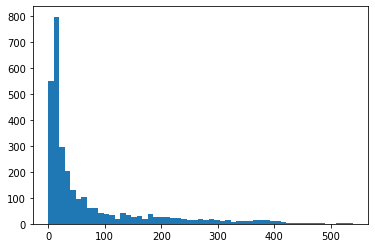

(array([552., 798., 296., 205., 131., 95., 102., 59., 62., 42., 38.,
 33., 20., 42., 34., 28., 31., 19., 39., 25., 28., 28.,
 22., 24., 17., 14., 15., 18., 13., 20., 15., 10., 14.,
 8., 9., 10., 10., 14., 16., 14., 10., 11., 6., 3.,
 4., 4., 3., 2., 4., 4., 1., 0., 3., 2., 3.]),
 array([ 0. , 9.79820116, 19.59640232, 29.39460348,
 39.19280464, 48.9910058 , 58.78920696, 68.58740812,
 78.38560928, 88.18381044, 97.9820116 , 107.78021276,
 117.57841392, 127.37661508, 137.17481624, 146.9730174 ,
 156.77121856, 166.56941972, 176.36762088, 186.16582204,
 195.9640232 , 205.76222436, 215.56042552, 225.35862668,
 235.15682784, 244.955029 , 254.75323016, 264.55143132,
 274.34963248, 284.14783364, 293.9460348 , 303.74423596,
 313.54243712, 323.34063828, 333.13883944, 342.9370406 ,
 352.73524176, 362.53344292, 372.33164408, 382.12984524,
 391.9280464 , 401.72624756, 411.52444872, 421.32264988,
 431.12085104, 440.9190522 , 450.71725336, 460.51545452,
 470.31365568, 480.11185684, 489.910058 , 499.70825916,
 509.50646032, 519.30466148, 529.10286264, 538.9010638 ]),
 <BarContainer object of 55 artists>)

In [0]:
plt.hist(y_test, bins='auto')

Out[252]:

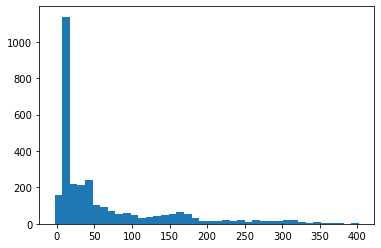

(array([ 158., 1137., 219., 211., 243., 101., 90., 70., 52.,
 61., 49., 34., 40., 42., 48., 54., 67., 56.,
 34., 18., 18., 17., 21., 13., 20., 12., 19.,
 18., 16., 13., 21., 21., 8., 6., 9., 3.,
 4., 3., 0., 4.]),
 array([ -2.93637784, 7.18594708, 17.30827201, 27.43059694,
 37.55292186, 47.67524679, 57.79757172, 67.91989665,
 78.04222157, 88.1645465 , 98.28687143, 108.40919636,
 118.53152128, 128.65384621, 138.77617114, 148.89849606,
 159.02082099, 169.14314592, 179.26547085, 189.38779577,
 199.5101207 , 209.63244563, 219.75477055, 229.87709548,
 239.99942041, 250.12174534, 260.24407026, 270.36639519,
 280.48872012, 290.61104505, 300.73336997, 310.8556949 ,
 320.97801983, 331.10034475, 341.22266968, 351.34499461,
 361.46731954, 371.58964446, 381.71196939, 391.83429432,
 401.95661925]),
 <BarContainer object of 40 artists>)

In [0]:
plt.hist(pred, bins='auto')

## TabNet

In [0]:
!pip install pytorch-tabnet

Collecting pytorch-tabnet
 Downloading pytorch_tabnet-3.1.1-py3-none-any.whl (39 kB)
Requirement already satisfied: scikit_learn>0.21 in /databricks/python3/lib/python3.8/site-packages (from pytorch-tabnet) (0.24.1)
Requirement already satisfied: tqdm<5.0,>=4.36 in /databricks/python3/lib/python3.8/site-packages (from pytorch-tabnet) (4.59.0)
Requirement already satisfied: scipy>1.4 in /databricks/python3/lib/python3.8/site-packages (from pytorch-tabnet) (1.6.2)
Requirement already satisfied: numpy<2.0,>=1.17 in /databricks/python3/lib/python3.8/site-packages (from pytorch-tabnet) (1.20.1)
Requirement already satisfied: torch<2.0,>=1.2 in /databricks/python3/lib/python3.8/site-packages (from pytorch-tabnet) (1.10.2+cpu)
Requirement already satisfied: joblib>=0.11 in /databricks/python3/lib/python3.8/site-packages (from scikit_learn>0.21->pytorch-tabnet) (1.0.1)
Requirement already satisfied: threadpoolctl>=2.0.0 in /databricks/python3/lib/python3.8/site-packages (from scikit_learn>0.21->pytorch-tabnet) (2.1.0)
Requirement already satisfied: typing-extensions in /databricks/python3/lib/python3.8/site-packages (from torch<2.0,>=1.2->pytorch-tabnet) (3.7.4.3)
Installing collected packages: pytorch-tabnet
Successfully installed pytorch-tabnet-3.1.1
 WARNING: You are using pip version 21.0.1; however, version 22.0.4 is available.
You should consider upgrading via the '/databricks/python3/bin/python -m pip install --upgrade pip' command.

In [0]:
%load_ext autoreload
%autoreload 2

In [0]:
from pytorch_tabnet.tab_model import TabNetRegressor
from pytorch_tabnet.pretraining import TabNetPretrainer
import tensorflow as tf


#### Pretrain

In [0]:
# TabNetPretrainer
unsupervised_model = TabNetPretrainer(
    cat_idxs=cat_idxs,
    cat_dims=cat_dims,
    cat_emb_dim=3,
    optimizer_fn=torch.optim.Adam,
    optimizer_params=dict(lr=2e-2),
    mask_type='entmax', # "sparsemax",
#     n_shared_decoder=1, # nb shared glu for decoding
#     n_indep_decoder=1, # nb independent glu for decoding
)

Device used : cpu

In [0]:
max_epochs = 1000 if not os.getenv("CI", False) else 2

In [0]:
unsupervised_model.fit(
    X_train=X_train,
    eval_set=[X_valid],
    max_epochs=max_epochs , patience=50,
    batch_size=2048, virtual_batch_size=128,
    num_workers=0,
    drop_last=False,
    pretraining_ratio=0.8,
) 

epoch 0 | loss: 37.1084 | val_0_unsup_loss: 6.23753 | 0:00:01s
epoch 1 | loss: 34.81254| val_0_unsup_loss: 5.10302 | 0:00:02s
epoch 2 | loss: 30.74901| val_0_unsup_loss: 4.79431 | 0:00:03s
epoch 3 | loss: 25.4345 | val_0_unsup_loss: 4.98649 | 0:00:04s
epoch 4 | loss: 19.19361| val_0_unsup_loss: 5.0439 | 0:00:06s
epoch 5 | loss: 11.84782| val_0_unsup_loss: 4.62475 | 0:00:07s
epoch 6 | loss: 5.57117 | val_0_unsup_loss: 4.57448 | 0:00:08s
epoch 7 | loss: 1.71777 | val_0_unsup_loss: 4.47711 | 0:00:09s
epoch 8 | loss: 1.23285 | val_0_unsup_loss: 4.78073 | 0:00:10s
epoch 9 | loss: 1.16365 | val_0_unsup_loss: 4.28203 | 0:00:12s
epoch 10 | loss: 1.11312 | val_0_unsup_loss: 4.1978 | 0:00:13s
epoch 11 | loss: 1.06071 | val_0_unsup_loss: 4.00104 | 0:00:14s
epoch 12 | loss: 1.00951 | val_0_unsup_loss: 3.70277 | 0:00:15s
epoch 13 | loss: 0.96475 | val_0_unsup_loss: 3.36161 | 0:00:16s
epoch 14 | loss: 0.92848 | val_0_unsup_loss: 3.09479 | 0:00:18s
epoch 15 | loss: 0.91353 | val_0_unsup_loss: 2.92334 | 0:00:19s
epoch 16 | loss: 0.89411 | val_0_unsup_loss: 5.25289 | 0:00:20s
epoch 17 | loss: 0.88138 | val_0_unsup_loss: 3.38481 | 0:00:21s
epoch 18 | loss: 0.86194 | val_0_unsup_loss: 1.88387 | 0:00:23s
epoch 19 | loss: 0.85823 | val_0_unsup_loss: 1.85396 | 0:00:24s
epoch 20 | loss: 0.84131 | val_0_unsup_loss: 1.92272 | 0:00:25s
epoch 21 | loss: 0.84291 | val_0_unsup_loss: 1.69616 | 0:00:26s
epoch 22 | loss: 0.83087 | val_0_unsup_loss: 1.47273 | 0:00:28s
epoch 23 | loss: 0.82458 | val_0_unsup_loss: 1.81053 | 0:00:29s
epoch 24 | loss: 0.81941 | val_0_unsup_loss: 1.70247 | 0:00:30s
epoch 25 | loss: 0.82188 | val_0_unsup_loss: 1.62762 | 0:00:31s
epoch 26 | loss: 0.81027 | val_0_unsup_loss: 1.52179 | 0:00:32s
epoch 27 | loss: 0.79655 | val_0_unsup_loss: 1.52536 | 0:00:34s
epoch 28 | loss: 0.79459 | val_0_unsup_loss: 1.50892 | 0:00:35s
epoch 29 | loss: 0.79617 | val_0_unsup_loss: 1.37968 | 0:00:36s
epoch 30 | loss: 0.79352 | val_0_unsup_loss: 1.22575 | 0:00:37s
epoch 31 | loss: 0.77883 | val_0_unsup_loss: 1.08871 | 0:00:38s
epoch 32 | loss: 0.7814 | val_0_unsup_loss: 1.00989 | 0:00:40s
epoch 33 | loss: 0.77516 | val_0_unsup_loss: 1.0753 | 0:00:41s
epoch 34 | loss: 0.75983 | val_0_unsup_loss: 1.57843 | 0:00:42s
epoch 35 | loss: 0.76192 | val_0_unsup_loss: 1.21706 | 0:00:43s
epoch 36 | loss: 0.75737 | val_0_unsup_loss: 0.89141 | 0:00:45s
epoch 37 | loss: 0.7478 | val_0_unsup_loss: 1.15701 | 0:00:46s
epoch 38 | loss: 0.74638 | val_0_unsup_loss: 1.19871 | 0:00:47s
epoch 39 | loss: 0.74762 | val_0_unsup_loss: 1.20846 | 0:00:48s
epoch 40 | loss: 0.74153 | val_0_unsup_loss: 1.26426 | 0:00:50s
epoch 41 | loss: 0.74514 | val_0_unsup_loss: 1.41073 | 0:00:51s
epoch 42 | loss: 0.74333 | val_0_unsup_loss: 1.39589 | 0:00:52s
epoch 43 | loss: 0.73299 | val_0_unsup_loss: 1.6846 | 0:00:53s
epoch 44 | loss: 0.72843 | val_0_unsup_loss: 1.59878 | 0:00:54s
epoch 45 | loss: 0.71959 | val_0_unsup_loss: 1.52787 | 0:00:56s
epoch 46 | loss: 0.71801 | val_0_unsup_loss: 1.49468 | 0:00:57s
epoch 47 | loss: 0.72213 | val_0_unsup_loss: 1.48518 | 0:00:58s
epoch 48 | loss: 0.71616 | val_0_unsup_loss: 1.50901 | 0:00:59s
epoch 49 | loss: 0.71819 | val_0_unsup_loss: 1.51307 | 0:01:00s
epoch 50 | loss: 0.70767 | val_0_unsup_loss: 1.43204 | 0:01:02s
epoch 51 | loss: 0.7124 | val_0_unsup_loss: 1.34408 | 0:01:03s
epoch 52 | loss: 0.70241 | val_0_unsup_loss: 1.42441 | 0:01:04s
epoch 53 | loss: 0.70505 | val_0_unsup_loss: 1.25786 | 0:01:06s
epoch 54 | loss: 0.70191 | val_0_unsup_loss: 1.15502 | 0:01:07s
epoch 55 | loss: 0.6957 | val_0_unsup_loss: 1.20274 | 0:01:08s
epoch 56 | loss: 0.6978 | val_0_unsup_loss: 1.40968 | 0:01:09s
epoch 57 | loss: 0.69485 | val_0_unsup_loss: 1.35861 | 0:01:10s
epoch 58 | loss: 0.68925 | val_0_unsup_loss: 1.24425 | 0:01:12s
epoch 59 | loss: 0.68791 | val_0_unsup_loss: 1.26134 | 0:01:13s
epoch 60 | loss: 0.68242 | val_0_unsup_loss: 1.08632 | 0:01:14s
epoch 61 | loss: 0.68368 | val_0_unsup_loss: 1.11017 | 0:01:15s
epoch 62 | loss: 0.68051 | val_0_unsup_loss: 0.8917

In [0]:
# # Make reconstruction from a dataset
# reconstructed_X, embedded_X = unsupervised_model.predict(X_valid)
# assert(reconstructed_X.shape==embedded_X.shape)

In [0]:
# unsupervised_explain_matrix, unsupervised_masks = unsupervised_model.explain(X_valid)

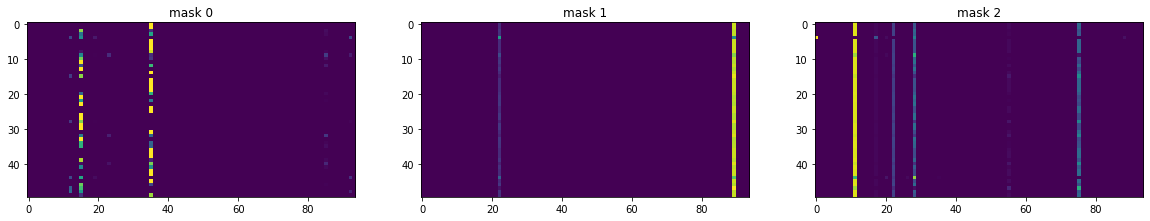

In [0]:
# fig, axs = plt.subplots(1, 3, figsize=(20,20))

# for i in range(3):
#     axs[i].imshow(unsupervised_masks[i][:50])
#     axs[i].set_title(f"mask {i}")

In [0]:
# unsupervised_model.save_model('/mnt/capstone/model/test_pretrain')
# loaded_pretrain = TabNetPretrainer()
# loaded_pretrain.load_model('/mnt/capstone/model/test_pretrain.zip')

Successfully saved model at /mnt/capstone/model/test_pretrain.zip
Device used : cpu
Device used : cpu

#### Supervised

In [0]:
max_epochs = 1000 if not os.getenv("CI", False) else 2
batch_size = 1024

In [0]:
tabnet = TabNetRegressor(cat_dims=cat_dims, 
                         cat_emb_dim=cat_emb_dim, 
                         cat_idxs=cat_idxs, 
                         optimizer_fn=torch.optim.Adam, # Any optimizer works here
                         optimizer_params=dict(lr=2e-2),
                         scheduler_fn=torch.optim.lr_scheduler.OneCycleLR,
                         scheduler_params={"is_batch_level":True,
                                         "max_lr":5e-2,
                                         "steps_per_epoch":int(train.shape[0] / batch_size)+1,
                                         "epochs":max_epochs
                                          },
                         mask_type='entmax',seed=0) # "sparsemax",)

Device used : cpu

In [0]:
tabnet.fit(
    X_train=X_train, y_train=y_train,
    eval_set=[(X_train, y_train), (X_valid, y_valid)],
    eval_name=['train', 'valid'],
    eval_metric=['rmse'],
    max_epochs=max_epochs,
    patience=50,
    batch_size=256, virtual_batch_size=128,
    num_workers=0,
    drop_last=False, 
    #Load pretrained model
#     from_unsupervised=loaded_pretrain
) 

epoch 0 | loss: 8640.61623| train_rmse: 89.49244| valid_rmse: 86.74605| 0:00:02s
epoch 1 | loss: 7408.05333| train_rmse: 82.91578| valid_rmse: 81.69549| 0:00:05s
epoch 2 | loss: 5528.81871| train_rmse: 67.52701| valid_rmse: 68.2796 | 0:00:08s
epoch 3 | loss: 3489.75755| train_rmse: 49.12505| valid_rmse: 53.11363| 0:00:11s
epoch 4 | loss: 2251.49773| train_rmse: 42.87233| valid_rmse: 49.54759| 0:00:14s
epoch 5 | loss: 1952.34022| train_rmse: 41.59341| valid_rmse: 55.13904| 0:00:17s
epoch 6 | loss: 1837.90872| train_rmse: 41.93615| valid_rmse: 45.25808| 0:00:20s
epoch 7 | loss: 1832.06098| train_rmse: 40.24772| valid_rmse: 45.3775 | 0:00:23s
epoch 8 | loss: 1771.82899| train_rmse: 39.53389| valid_rmse: 50.65038| 0:00:26s
epoch 9 | loss: 1691.61265| train_rmse: 39.4028 | valid_rmse: 52.68382| 0:00:29s
epoch 10 | loss: 1691.76698| train_rmse: 40.04576| valid_rmse: 42.25942| 0:00:32s
epoch 11 | loss: 1689.22099| train_rmse: 38.60549| valid_rmse: 42.757 | 0:00:35s
epoch 12 | loss: 1627.43613| train_rmse: 37.87168| valid_rmse: 41.85831| 0:00:38s
epoch 13 | loss: 1599.24625| train_rmse: 38.18567| valid_rmse: 42.8194 | 0:00:41s
epoch 14 | loss: 1572.39351| train_rmse: 37.2005 | valid_rmse: 46.36197| 0:00:44s
epoch 15 | loss: 1569.50333| train_rmse: 38.87806| valid_rmse: 41.01714| 0:00:47s
epoch 16 | loss: 1599.96189| train_rmse: 37.29782| valid_rmse: 42.00085| 0:00:50s
epoch 17 | loss: 1532.65564| train_rmse: 36.9299 | valid_rmse: 49.03972| 0:00:54s
epoch 18 | loss: 1559.24478| train_rmse: 36.75486| valid_rmse: 111.01001| 0:00:57s
epoch 19 | loss: 1482.4387| train_rmse: 39.38428| valid_rmse: 291.44183| 0:00:59s
epoch 20 | loss: 1520.27641| train_rmse: 36.72296| valid_rmse: 582.84786| 0:01:02s
epoch 21 | loss: 1520.66702| train_rmse: 37.52539| valid_rmse: 470.69709| 0:01:05s
epoch 22 | loss: 1476.52574| train_rmse: 35.90049| valid_rmse: 548.81008| 0:01:08s
epoch 23 | loss: 1462.43836| train_rmse: 36.29452| valid_rmse: 110.79335| 0:01:11s
epoch 24 | loss: 1469.78524| train_rmse: 36.6742 | valid_rmse: 49.0774 | 0:01:14s
epoch 25 | loss: 1511.33198| train_rmse: 37.94145| valid_rmse: 542.02732| 0:01:17s
epoch 26 | loss: 1457.98375| train_rmse: 37.01114| valid_rmse: 41.43511| 0:01:20s
epoch 27 | loss: 1463.20704| train_rmse: 36.64665| valid_rmse: 46.35235| 0:01:23s
epoch 28 | loss: 1497.20351| train_rmse: 36.82475| valid_rmse: 44.34584| 0:01:26s
epoch 29 | loss: 1505.45917| train_rmse: 38.69701| valid_rmse: 41.55299| 0:01:29s
epoch 30 | loss: 1447.05766| train_rmse: 37.52733| valid_rmse: 46.05745| 0:01:32s
epoch 31 | loss: 1479.41128| train_rmse: 35.81972| valid_rmse: 57.65338| 0:01:35s
epoch 32 | loss: 1465.07944| train_rmse: 36.09109| valid_rmse: 358.26908| 0:01:38s
epoch 33 | loss: 1439.75037| train_rmse: 37.77476| valid_rmse: 51.98154| 0:01:41s
epoch 34 | loss: 1465.98328| train_rmse: 35.97004| valid_rmse: 43.35492| 0:01:44s
epoch 35 | loss: 1406.07696| train_rmse: 36.55999| valid_rmse: 306.76068| 0:01:47s
epoch 36 | loss: 1468.749| train_rmse: 35.99412| valid_rmse: 44.87667| 0:01:50s
epoch 37 | loss: 1444.36968| train_rmse: 36.18231| valid_rmse: 286.41418| 0:01:53s
epoch 38 | loss: 1446.38865| train_rmse: 35.34101| valid_rmse: 42.33848| 0:01:57s
epoch 39 | loss: 1459.57896| train_rmse: 37.35105| valid_rmse: 259.24946| 0:02:00s
epoch 40 | loss: 1432.72587| train_rmse: 36.03021| valid_rmse: 43.16517| 0:02:03s
epoch 41 | loss: 1411.40812| train_rmse: 35.50555| valid_rmse: 48.40412| 0:02:06s
epoch 42 | loss: 1378.28747| train_rmse: 36.79406| valid_rmse: 48.31526| 0:02:09s
epoch 43 | loss: 1411.94162| train_rmse: 35.85048| valid_rmse: 44.73009| 0:02:12s
epoch 44 | loss: 1408.16888| train_rmse: 37.139 | valid_rmse: 41.94244| 0:02:15s
epoch 45 | loss: 1377.11018| train_rmse: 37.27525| valid_rmse: 47.80903| 0:02:18s
epoch 46 | loss: 1410.43571| train_rmse: 35.5472 | valid_rmse: 45.74529| 0:02:21s
epoch 47 | loss: 1363.74365| train_rmse: 35.59906| valid_rmse: 41.55731| 0:02:24s
epoch 48 | loss: 1368.13524| train_rmse: 34.95051| valid_rmse: 44.03

In [0]:
preds = tabnet.predict(X_test)

y_true = y_test

test_score = r2_score(y_pred=preds, y_true=y_true)
valid_score = r2_score(y_pred=tabnet.predict(X_valid), y_true=y_valid)
train_score = r2_score(y_pred=tabnet.predict(X_train), y_true=y_train)
print(f"TRAIN SCORE FOR : {train_score}")
print(f"VALID SCORE FOR : {valid_score}")
print(f"TEST SCORE FOR: {test_score}")

TRAIN SCORE FOR : 0.7408818430963786
VALID SCORE FOR : 0.6849929041408043
TEST SCORE FOR: 0.6200693894804916

In [0]:
#tabnet.save_model('/mnt/capstone/model/tabnet_03_13')

## XGBoost

In [0]:
from xgboost import XGBRegressor

In [0]:
clf_xgb = XGBRegressor(base_score=0.5, booster='dart',
             colsample_bylevel=0.3959137968655604,
             colsample_bynode=0.38427772092378626,
             colsample_bytree=0.7366289714335655, enable_categorical=False,
             gamma=14.0281111983136, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.5386955173692471,
             max_delta_step=6, max_depth=8, min_child_weight=0.4016920074761443,
             monotone_constraints='()', n_estimators=900, n_jobs=8,
             num_parallel_tree=1, predictor='auto', random_state=0,
             reg_alpha=22, reg_lambda=204, scale_pos_weight=1,
             subsample=0.8783345980525217, tree_method='exact',
             validate_parameters=1, verbosity=None)


# XGBRegressor(base_score=0.5, 
#                        booster='gbtree',
#                        colsample_bylevel=0.4572943401260166,
#                        colsample_bynode=0.9817802074404147,
#                        colsample_bytree=0.385678979854995, 
#                        enable_categorical=False,
#                        gamma=100,   # 4.263935519930179, 
#                        gpu_id=-1, 
#                        importance_type=None,
#                        interaction_constraints='', 
#                        learning_rate=0.1716282906637911,
#                        max_delta_step=10, 
#                        max_depth=5,  #11
#                        min_child_weight=0.4733776751261309, 
#                        #missing=nan,
#                        monotone_constraints='()', 
#                        n_estimators=500, 
#                        n_jobs=8,
#                        num_parallel_tree=1, 
#                        objective='reg:linear', 
#                        predictor='auto',
#                        random_state=0, 
#                        reg_alpha=100, 
#                        reg_lambda=200, #111
#                        scale_pos_weight=1,
#                        subsample=0.8941730932476202, 
#                        tree_method='approx',
#                        validate_parameters=1, 
#                        verbosity=None)


clf_xgb.fit(X_train, y_train,
        eval_set=[(X_valid, y_valid)],
        early_stopping_rounds=40,
        verbose=10)


[0]	validation_0-rmse:121.02889
[10]	validation_0-rmse:102.09203
[20]	validation_0-rmse:86.27978
[30]	validation_0-rmse:72.95778
[40]	validation_0-rmse:62.06956
[50]	validation_0-rmse:52.88206
[60]	validation_0-rmse:46.42342
[70]	validation_0-rmse:39.99871
[80]	validation_0-rmse:34.73305
[90]	validation_0-rmse:30.21233
[100]	validation_0-rmse:26.61163
[110]	validation_0-rmse:23.84068
[120]	validation_0-rmse:21.84400
[130]	validation_0-rmse:20.44072
[140]	validation_0-rmse:19.32235
[150]	validation_0-rmse:18.58442
[160]	validation_0-rmse:17.97242
[170]	validation_0-rmse:17.31619
[180]	validation_0-rmse:16.72401
[190]	validation_0-rmse:16.29717
[200]	validation_0-rmse:15.85713
[210]	validation_0-rmse:15.43020
[220]	validation_0-rmse:15.05630
[230]	validation_0-rmse:14.68600
[240]	validation_0-rmse:14.36871
[250]	validation_0-rmse:14.06245
[260]	validation_0-rmse:13.69809
[270]	validation_0-rmse:13.24274
[280]	validation_0-rmse:12.92600
[290]	validation_0-rmse:12.66220
[300]	validation_0-rmse:12.41274
[310]	validation_0-rmse:12.17217
[320]	validation_0-rmse:11.92511
[330]	validation_0-rmse:11.70261
[340]	validation_0-rmse:11.54075
[350]	validation_0-rmse:11.26165
[360]	validation_0-rmse:11.04490
[370]	validation_0-rmse:10.84108
[380]	validation_0-rmse:10.65300
[390]	validation_0-rmse:10.43230
[400]	validation_0-rmse:10.25338
[410]	validation_0-rmse:10.08462

In [0]:
preds = np.array(clf_xgb.predict(X_train))
train_r2 = r2_score(y_pred=preds, y_true=y_train)
print(train_r2)

preds = np.array(clf_xgb.predict(X_valid))
valid_r2 = r2_score(y_pred=preds, y_true=y_valid)
print(valid_r2)

preds = np.array(clf_xgb.predict(X_test))
test_r2 = r2_score(y_pred=preds, y_true=y_test)
print(test_r2)

--------------------------------------------------------------------------- 
 NotFittedError Traceback (most recent call last)
 <command-91131904349306> in <module> 
 ----> 1 preds = np . array ( clf_xgb . predict ( X_train ) ) 
 2 train_r2 = r2_score ( y_pred = preds , y_true = y_train ) 
 3 print ( train_r2 ) 
 4 
 5 preds = np . array ( clf_xgb . predict ( X_valid ) ) 

 /databricks/python/lib/python3.8/site-packages/mlflow/utils/autologging_utils/safety.py in safe_patch_function (*args, **kwargs) 
 546 patch_function . call ( call_original , * args , ** kwargs ) 
 547 else : 
 --> 548 patch_function ( call_original , * args , ** kwargs ) 
 549 
 550 session . state = "succeeded" 

 /databricks/python/lib/python3.8/site-packages/mlflow/sklearn/__init__.py in patched_predict (original, self, *args, **kwargs) 
 1516 return predict_result
 1517 else : 
 -> 1518 return original ( self , * args , ** kwargs ) 
 1519 
 1520 def patched_metric_api ( original , * args , ** kwargs ) : 

 /databricks/python/lib/python3.8/site-packages/mlflow/utils/autologging_utils/safety.py in call_original (*og_args, **og_kwargs) 
 527 return original_result
 528 
 --> 529 return call_original_fn_with_event_logging ( _original_fn , og_args , og_kwargs ) 
 530 
 531 # Apply the name, docstring, and signature of `original` to `call_original`. 

 /databricks/python/lib/python3.8/site-packages/mlflow/utils/autologging_utils/safety.py in call_original_fn_with_event_logging (original_fn, og_args, og_kwargs) 
 469 og_kwargs , 
 470 )
 --> 471 original_fn_result = original_fn ( * og_args , ** og_kwargs ) 
 472 
 473 try_log_autologging_event(

 /databricks/python/lib/python3.8/site-packages/mlflow/utils/autologging_utils/safety.py in _original_fn (*_og_args, **_og_kwargs) 
 524 reroute_warnings = False , 
 525 ):
 --> 526 original_result = original ( * _og_args , ** _og_kwargs ) 
 527 return original_result
 528 

 /databricks/python/lib/python3.8/site-packages/xgboost/sklearn.py in predict (self, X, output_margin, ntree_limit, validate_features, base_margin, iteration_range) 
 874 """
 875 iteration_range = _convert_ntree_limit(
 --> 876 self . get_booster ( ) , ntree_limit , iteration_range
 877 )
 878 iteration_range = self . _get_iteration_range ( iteration_range ) 

 /databricks/python/lib/python3.8/site-packages/xgboost/sklearn.py in get_booster (self) 
 457 if not self . __sklearn_is_fitted__ ( ) : 
 458 from sklearn . exceptions import NotFittedError
 --> 459 raise NotFittedError ( 'need to call fit or load_model beforehand' ) 
 460 return self . _Booster
 461 

 NotFittedError : need to call fit or load_model beforehand

## Tuning

In [0]:
!pip install hyperopt

Collecting hyperopt
 Downloading hyperopt-0.2.7-py2.py3-none-any.whl (1.6 MB)
▏ | 10 kB 31.8 MB/s eta 0:00:01 |▍ | 20 kB 8.0 MB/s eta 0:00:01 |▋ | 30 kB 7.3 MB/s eta 0:00:01 |▉ | 40 kB 3.5 MB/s eta 0:00:01 |█ | 51 kB 3.5 MB/s eta 0:00:01 |█▎ | 61 kB 4.2 MB/s eta 0:00:01 |█▌ | 71 kB 4.4 MB/s eta 0:00:01 |█▋ | 81 kB 3.4 MB/s eta 0:00:01 |█▉ | 92 kB 3.8 MB/s eta 0:00:01 |██ | 102 kB 4.0 MB/s eta 0:00:01 |██▎ | 112 kB 4.0 MB/s eta 0:00:01 |██▌ | 122 kB 4.0 MB/s eta 0:00:01 |██▊ | 133 kB 4.0 MB/s eta 0:00:01 |███ | 143 kB 4.0 MB/s eta 0:00:01 |███ | 153 kB 4.0 MB/s eta 0:00:01 |███▎ | 163 kB 4.0 MB/s eta 0:00:01 |███▌ | 174 kB 4.0 MB/s eta 0:00:01 |███▊ | 184 kB 4.0 MB/s eta 0:00:01 |████ | 194 kB 4.0 MB/s eta 0:00:01 |████▏ | 204 kB 4.0 MB/s eta 0:00:01 |████▍ | 215 kB 4.0 MB/s eta 0:00:01 |████▌ | 225 kB 4.0 MB/s eta 0:00:01 |████▊ | 235 kB 4.0 MB/s eta 0:00:01 |█████ | 245 kB 4.0 MB/s eta 0:00:01 |█████▏ | 256 kB 4.0 MB/s eta 0:00:01 |█████▍ | 266 kB 4.0 MB/s eta 0:00:01 |█████▋ | 276 kB 4.0 MB/s eta 0:00:01 |█████▉ | 286 kB 4.0 MB/s eta 0:00:01 |██████ | 296 kB 4.0 MB/s eta 0:00:01 |██████▏ | 307 kB 4.0 MB/s eta 0:00:01 |██████▍ | 317 kB 4.0 MB/s eta 0:00:01 |██████▋ | 327 kB 4.0 MB/s eta 0:00:01 |██████▉ | 337 kB 4.0 MB/s eta 0:00:01 |███████ | 348 kB 4.0 MB/s eta 0:00:01 |███████▎ | 358 kB 4.0 MB/s eta 0:00:01 |███████▌ | 368 kB 4.0 MB/s eta 0:00:01 |███████▋ | 378 kB 4.0 MB/s eta 0:00:01 |███████▉ | 389 kB 4.0 MB/s eta 0:00:01 |████████ | 399 kB 4.0 MB/s eta 0:00:01 |████████▎ | 409 kB 4.0 MB/s eta 0:00:01 |████████▌ | 419 kB 4.0 MB/s eta 0:00:01 |████████▊ | 430 kB 4.0 MB/s eta 0:00:01 |█████████ | 440 kB 4.0 MB/s eta 0:00:01 |█████████ | 450 kB 4.0 MB/s eta 0:00:01 |█████████▎ | 460 kB 4.0 MB/s eta 0:00:01 |█████████▌ | 471 kB 4.0 MB/s eta 0:00:01 |█████████▊ | 481 kB 4.0 MB/s eta 0:00:01 |██████████ | 491 kB 4.0 MB/s eta 0:00:01 |██████████▏ | 501 kB 4.0 MB/s eta 0:00:01 |██████████▍ | 512 kB 4.0 MB/s eta 0:00:01 |██████████▌ | 522 kB 4.0 MB/s eta 0:00:01 |██████████▊ | 532 kB 4.0 MB/s eta 0:00:01 |███████████ | 542 kB 4.0 MB/s eta 0:00:01 |███████████▏ | 552 kB 4.0 MB/s eta 0:00:01 |███████████▍ | 563 kB 4.0 MB/s eta 0:00:01 |███████████▋ | 573 kB 4.0 MB/s eta 0:00:01 |███████████▉ | 583 kB 4.0 MB/s eta 0:00:01 |████████████ | 593 kB 4.0 MB/s eta 0:00:01 |████████████▏ | 604 kB 4.0 MB/s eta 0:00:01 |████████████▍ | 614 kB 4.0 MB/s eta 0:00:01 |████████████▋ | 624 kB 4.0 MB/s eta 0:00:01 |████████████▉ | 634 kB 4.0 MB/s eta 0:00:01 |█████████████ | 645 kB 4.0 MB/s eta 0:00:01 |█████████████▎ | 655 kB 4.0 MB/s eta 0:00:01 |█████████████▌ | 665 kB 4.0 MB/s eta 0:00:01 |█████████████▋ | 675 kB 4.0 MB/s eta 0:00:01 |█████████████▉ | 686 kB 4.0 MB/s eta 0:00:01 |██████████████ | 696 kB 4.0 MB/s eta 0:00:01 |██████████████▎ | 706 kB 4.0 MB/s eta 0:00:01 |██████████████▌ | 716 kB 4.0 MB/s eta 0:00:01 |██████████████▊ | 727 kB 4.0 MB/s eta 0:00:01 |███████████████ | 737 kB 4.0 MB/s eta 0:00:01 |███████████████ | 747 kB 4.0 MB/s eta 0:00:01 |███████████████▎ | 757 kB 4.0 MB/s eta 0:00:01 |███████████████▌ | 768 kB 4.0 MB/s eta 0:00:01 |███████████████▊ | 778 kB 4.0 MB/s eta 0:00:01 |████████████████ | 788 kB 4.0 MB/s eta 0:00:01 |████████████████▏ | 798 kB 4.0 MB/s eta 0:00:01 |████████████████▍ | 808 kB 4.0 MB/s eta 0:00:01 |████████████████▌ | 819 kB 4.0 MB/s eta 0:00:01 |████████████████▊ | 829 kB 4.0 MB/s eta 0:00:01 |█████████████████ | 839 kB 4.0 MB/s eta 0:00:01 |█████████████████▏ | 849 kB 4.0 MB/s eta 0:00:01 |█████████████████▍ | 860 kB 4.0 MB/s eta 0:00:01 |█████████████████▋ | 870 kB 4.0 MB/s eta 0:00:01 |█████████████████▉ | 880 kB 4.0 MB/s eta 0:00:01 |██████████████████ | 890 kB 4.0 MB/s eta 0:00:01 |██████████████████▏ | 901 kB 4.0 MB/s eta 0:00:01 |██████████████████▍ | 911 kB 4.0 MB/s eta 0:00:01 |██████████████████▋ | 921 kB 4.0 MB/s eta 0:00:01 |██████████████████▉ | 931 kB 4.0 MB/s eta 0:00:01 |███████████████████ | 94

In [0]:
from hyperopt import hp
from hyperopt import fmin, tpe, space_eval
from hyperopt import SparkTrials, STATUS_OK, Trials, fmin, hp, tpe
from sklearn import base


In [0]:
space={'max_depth': hp.quniform("max_depth", 3, 18, 1),
       'objective': hp.choice('objective', ['reg:squarederror', 'reg:linear']), 
       'booster': hp.choice('booster', ['gbtree','dart']), #'gblinear' doesnt work with shap for explainability
       'max_delta_step': hp.quniform('max_delta_step', 0, 10, 1),
       'subsample': hp.uniform('subsample', 0, 1), 
        'gamma': hp.uniform('gamma', 0,120),
        'reg_alpha' : hp.quniform('reg_alpha', 0,120,1),
        'reg_lambda' : hp.quniform('reg_lambda', 100,250, 1),
        'colsample_bytree' : hp.uniform('colsample_bytree', 0.2,1),
        'colsample_bylevel' : hp.uniform('colsample_bylevel', 0.2,1), 
        'colsample_bynode' : hp.uniform('colsample_bynode', 0.2,1), 
        'min_child_weight' : hp.uniform('min_child_weight', 0, 1),
        'n_estimators': hp.quniform("n_estimators", 100, 1200, 100),
        'learning_rate': hp.uniform("learning_rate", 0.01, 1), 
        'tree_method': hp.choice('tree_method', ['exact', 'approx']),
        'seed': 0
    }

In [0]:
def objective(space):
    clf=XGBRegressor(
                    max_depth = int(space['max_depth']), 
                    objective = space['objective'], 
                    booster = space['booster'], 
                    max_delta_step = int(space['max_delta_step']), 
                    subsample = space['subsample'], 
                    gamma = space['gamma'],
                    reg_alpha = int(space['reg_alpha']),
                    reg_lambda = int(space['reg_lambda']), 
                    colsample_bytree= space['colsample_bytree'], 
                    colsample_bylevel= space['colsample_bylevel'], 
                    colsample_bynode = space['colsample_bynode'], 
                    min_child_weight= space['min_child_weight'],
                    n_estimators =int(space['n_estimators']),
                    learning_rate = space['learning_rate'], 
                    tree_method = space['tree_method']
                    )
    
    evaluation_all = [( X_train, y_train), ( X_valid, y_valid)]
    
    clf.fit(X_train, y_train,
            eval_set=[(X_valid, y_valid)],
            eval_metric="rmse", 
            early_stopping_rounds=40, 
            verbose = 100)
    

    pred = np.array(clf.predict(X_test))
    test_r2 = r2_score(y_pred=pred, y_true=y_test)
    print("SCORE:", test_r2)
    return {'loss': -test_r2, 'model': clf, 'status': STATUS_OK }

In [0]:
def objective_CV(space):
    clf=XGBRegressor(
                    max_depth = int(space['max_depth']), 
                    objective = space['objective'], 
                    booster = space['booster'], 
                    max_delta_step = int(space['max_delta_step']), 
                    subsample = space['subsample'], 
                    gamma = space['gamma'],
                    reg_alpha = int(space['reg_alpha']),
                    reg_lambda = int(space['reg_lambda']), 
                    colsample_bytree= space['colsample_bytree'], 
                    colsample_bylevel= space['colsample_bylevel'], 
                    colsample_bynode = space['colsample_bynode'], 
                    min_child_weight= space['min_child_weight'],
                    n_estimators =int(space['n_estimators']),
                    learning_rate = space['learning_rate'], 
                    )
    
    clf_2 = base.clone(clf)

    evaluation_all = [( X_train, y_train), ( X_valid, y_valid), 
                     (X_train_2, y_train_2), (X_valid_2, y_valid_2)]

    clf.fit(X_train, y_train,
            eval_set=[(X_valid, y_valid)],
            eval_metric="rmse", 
            early_stopping_rounds=40, 
            verbose = 100)
    
    train_pred = np.array(clf.predict(X_train))
    pred = np.array(clf.predict(X_test))

    clf_2.fit(X_train_2, y_train_2,
            eval_set=[(X_valid_2, y_valid_2)],
            eval_metric="rmse", 
            early_stopping_rounds=40, 
            verbose = 100)
    
    train_pred_2 = np.array(clf_2.predict(X_train_2))
    pred_2 = np.array(clf_2.predict(X_test_2))
    

    
    train_r2 = r2_score(y_pred=train_pred, y_true=y_train)
    train_r2_2 = r2_score(y_pred=train_pred_2, y_true=y_train_2)
    
    test_r2 = r2_score(y_pred=pred, y_true=y_test)
    test_r2_2 = r2_score(y_pred=pred_2, y_true=y_test_2)
    
    avg_train_r2 = (train_r2 + train_r2_2) / 2
    avg_r2 = (test_r2 + test_r2_2) / 2
    
    expected = test_r2 - (train_r2 - test_r2)
    expected_2 = test_r2_2 - (train_r2_2 - test_r2_2)
    
    avg_expected = (expected + expected_2) / 2

    print(f'TRAIN SCORE1: {train_r2} TEST SCORE1: {test_r2} VARIANCE1: {test_r2 - train_r2}  EXPECTED1: {expected}, TRAIN SCORE2: {train_r2_2} TEST SCORE2: {test_r2_2} VARIANCE2: {test_r2_2 - train_r2_2} EXPECTED2: {expected_2}')
    return {'loss': -avg_r2, 'model1': clf, 'model2':clf_2, 'status': STATUS_OK }

In [0]:
if split_strategy != '2_fold': 
    trials = Trials()

    best_hyperparams = fmin(fn = objective,
                            space = space,
                            algo = tpe.suggest,
                            max_evals = 40,
                            trials = trials)

    print("The best hyperparameters are : ","\n")
    print(best_hyperparams)

    best_model_new = trials.results[np.argmin([r['loss'] for r in  trials.results])]['model']
else: 
    trials = Trials()

    best_hyperparams = fmin(fn = objective_CV,
                            space = space,
                            algo = tpe.suggest,
                            max_evals = 40,
                            trials = trials)

    print("The best hyperparameters are : ","\n")
    print(best_hyperparams)

    best_model_new = trials.results[np.argmin([r['loss'] for r in  trials.results])]['model1']

    best_model_new_2 = trials.results[np.argmin([r['loss'] for r in  trials.results])]['model2']

0%| | 0/40 [00:00<?, ?trial/s, best loss=?] [0]	validation_0-rmse:118.28368
 0%| | 0/40 [00:00<?, ?trial/s, best loss=?] [82]	validation_0-rmse:51.28574
 0%| | 0/40 [00:07<?, ?trial/s, best loss=?] SCORE:
 0%| | 0/40 [00:12<?, ?trial/s, best loss=?] 0.6986601851019079
 0%| | 0/40 [00:12<?, ?trial/s, best loss=?] 2%|▎ | 1/40 [00:12<07:58, 12.27s/trial, best loss: -0.6986601851019079] [20:06:51] WARNING: ../src/objective/regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.
 2%|▎ | 1/40 [00:12<07:58, 12.27s/trial, best loss: -0.6986601851019079] [0]	validation_0-rmse:121.43943
 2%|▎ | 1/40 [00:12<07:58, 12.27s/trial, best loss: -0.6986601851019079] [100]	validation_0-rmse:49.09002
 2%|▎ | 1/40 [00:18<07:58, 12.27s/trial, best loss: -0.6986601851019079] [171]	validation_0-rmse:48.69661
 2%|▎ | 1/40 [00:23<07:58, 12.27s/trial, best loss: -0.6986601851019079] SCORE:
 2%|▎ | 1/40 [00:26<07:58, 12.27s/trial, best loss: -0.6986601851019079] 0.6747346907203661
 2%|▎ | 1/40 [00:26<07:58, 12.27s/trial, best loss: -0.6986601851019079] 5%|▌ | 2/40 [00:26<08:39, 13.67s/trial, best loss: -0.6986601851019079] [20:07:06] WARNING: ../src/objective/regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.
 5%|▌ | 2/40 [00:27<08:39, 13.67s/trial, best loss: -0.6986601851019079] [0]	validation_0-rmse:122.87858
 5%|▌ | 2/40 [00:27<08:39, 13.67s/trial, best loss: -0.6986601851019079] [100]	validation_0-rmse:98.49401
 5%|▌ | 2/40 [00:35<08:39, 13.67s/trial, best loss: -0.6986601851019079] [200]	validation_0-rmse:79.82125
 5%|▌ | 2/40 [01:00<08:39, 13.67s/trial, best loss: -0.6986601851019079] [300]	validation_0-rmse:66.69540
 5%|▌ | 2/40 [01:39<08:39, 13.67s/trial, best loss: -0.6986601851019079] [400]	validation_0-rmse:58.60425
 5%|▌ | 2/40 [02:34<08:39, 13.67s/trial, best loss: -0.6986601851019079] [500]	validation_0-rmse:54.74008
 5%|▌ | 2/40 [03:45<08:39, 13.67s/trial, best loss: -0.6986601851019079] [600]	validation_0-rmse:52.98421
 5%|▌ | 2/40 [05:11<08:39, 13.67s/trial, best loss: -0.6986601851019079] [700]	validation_0-rmse:51.42995
 5%|▌ | 2/40 [06:52<08:39, 13.67s/trial, best loss: -0.6986601851019079] [800]	validation_0-rmse:50.27185
 5%|▌ | 2/40 [08:47<08:39, 13.67s/trial, best loss: -0.6986601851019079] [899]	validation_0-rmse:49.73980
 5%|▌ | 2/40 [10:53<08:39, 13.67s/trial, best loss: -0.6986601851019079] SCORE:
 5%|▌ | 2/40 [10:57<08:39, 13.67s/trial, best loss: -0.6986601851019079] 0.6890319794748254
 5%|▌ | 2/40 [10:57<08:39, 13.67s/trial, best loss: -0.6986601851019079] 8%|▊ | 3/40 [10:57<3:02:12, 295.47s/trial, best loss: -0.6986601851019079] [20:17:37] WARNING: ../src/objective/regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.
 8%|▊ | 3/40 [10:58<3:02:12, 295.47s/trial, best loss: -0.6986601851019079] [0]	validation_0-rmse:122.34309
 8%|▊ | 3/40 [10:58<3:02:12, 295.47s/trial, best loss: -0.6986601851019079] [100]	validation_0-rmse:65.57698
 8%|▊ | 3/40 [11:13<3:02:12, 295.47s/trial, best loss: -0.6986601851019079] [200]	validation_0-rmse:49.67330
 8%|▊ | 3/40 [11:49<3:02:12, 295.47s/trial, best loss: -0.6986601851019079] [300]	validation_0-rmse:48.11446
 8%|▊ | 3/40 [12:46<3:02:12, 295.47s/trial, best loss: -0.6986601851019079] [391]	validation_0-rmse:48.21942
 8%|▊ | 3/40 [13:56<3:02:12, 295.47s/trial, best loss: -0.6986601851019079] SCORE:
 8%|▊ | 3/40 [14:01<3:02:12, 295.47s/trial, best loss: -0.6986601851019079] 0.7099533389712185
 8%|▊ | 3/40 [14:01<3:02:12, 295.47s/trial, best loss: -0.6986601851019079] 10%|█ | 4/40 [14:01<2:30:55, 251.54s/trial, best loss: -0.7099533389712185] [20:20:41] WARNING: ../src/objective/regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.
 10%|█ | 4/40 [14:02<2:30:55, 251.54s/trial, best loss: -0.7099533389712185] [0]	validation_0-rmse:122.55878
 10%|█ | 4/40 [14:02<2:30:55, 251.54s/t

In [0]:
best_model_new

Out[119]: XGBRegressor(base_score=0.5, booster='dart',
 colsample_bylevel=0.3959137968655604,
 colsample_bynode=0.38427772092378626,
 colsample_bytree=0.7366289714335655, enable_categorical=False,
 gamma=14.0281111983136, gpu_id=-1, importance_type=None,
 interaction_constraints='', learning_rate=0.5386955173692471,
 max_delta_step=6, max_depth=8, min_child_weight=0.4016920074761443,
 missing=nan, monotone_constraints='()', n_estimators=900, n_jobs=8,
 num_parallel_tree=1, predictor='auto', random_state=0,
 reg_alpha=22, reg_lambda=204, scale_pos_weight=1,
 subsample=0.8783345980525217, tree_method='exact',
 validate_parameters=1, verbosity=None)

In [0]:
if split_strategy != '2_fold':   
    preds = np.array(best_model_new.predict(X_train))
    train_r2 = r2_score(y_pred=preds, y_true=y_train)
    print(train_r2)

    preds = np.array(best_model_new.predict(X_valid))
    valid_r2 = r2_score(y_pred=preds, y_true=y_valid)
    print(valid_r2)

    preds = np.array(best_model_new.predict(X_test))
    test_r2 = r2_score(y_pred=preds, y_true=y_test)
    print(test_r2)
else: 
    clf_xgb = best_model_new
    clf_xgb_2 = best_model_new_2

    clf_xgb.fit(X_train, y_train,
            eval_set=[(X_valid, y_valid)],
            early_stopping_rounds=40,
            verbose=10)

    clf_xgb_2.fit(X_train_2, y_train_2,
            eval_set=[(X_valid_2, y_valid_2)],
            early_stopping_rounds=40,
            verbose=10)
    
    train_preds = np.array(clf_xgb.predict(X_train))
    train_preds_2 = np.array(clf_xgb_2.predict(X_train_2))
    train_r2 = r2_score(y_pred=train_preds, y_true=y_train)
    train_r2_2 = r2_score(y_pred=train_preds_2, y_true=y_train_2)
    print(f'1: {train_r2}, 2: {train_r2_2}')
    print((train_r2 + train_r2_2) / 2)

    val_preds = np.array(clf_xgb.predict(X_valid))
    val_preds_2 = np.array(clf_xgb_2.predict(X_valid_2))
    valid_r2 = r2_score(y_pred=val_preds, y_true=y_valid)
    valid_r2_2 = r2_score(y_pred=val_preds_2, y_true=y_valid_2)
    print(f'1: {valid_r2}, 2: {valid_r2_2}')
    print((valid_r2 + valid_r2_2) / 2)

    test_preds = np.array(clf_xgb.predict(X_test))
    test_preds_2 = np.array(clf_xgb_2.predict(X_test_2))
    test_r2 = r2_score(y_pred=test_preds, y_true=y_test)
    test_r2_2 = r2_score(y_pred=test_preds_2, y_true=y_test_2)
    print(f'1: {test_r2}, 2: {test_r2_2}')
    print((test_r2 + test_r2_2) / 2)

--------------------------------------------------------------------------- 
 NameError Traceback (most recent call last)
 <command-91131904349314> in <module> 
 1 if split_strategy != '2_fold' : 
 ----> 2 preds = np . array ( best_model_new . predict ( X_train ) ) 
 3 train_r2 = r2_score ( y_pred = preds , y_true = y_train ) 
 4 print ( train_r2 ) 
 5 

 NameError : name 'best_model_new' is not defined

In [0]:
# best_model_new.save_model('/mnt/capstone/model/aod_filtered_gfs_elev_wlabels_joined_randomsplit.json')

--------------------------------------------------------------------------- 
 XGBoostError Traceback (most recent call last)
 <command-417799108929567> in <module> 
 ----> 1 best_model_new . save_model ( '/mnt/capstone/model/aod_filtered_gfs_elev_wlabels_joined_randomsplit.json' ) 

 /databricks/python/lib/python3.8/site-packages/xgboost/sklearn.py in save_model (self, fname) 
 587 meta_str = json . dumps ( meta ) 
 588 self . get_booster ( ) . set_attr ( scikit_learn = meta_str ) 
 --> 589 self . get_booster ( ) . save_model ( fname ) 
 590 # Delete the attribute after save 
 591 self . get_booster ( ) . set_attr ( scikit_learn = None ) 

 /databricks/python/lib/python3.8/site-packages/xgboost/core.py in save_model (self, fname) 
 2127 if isinstance ( fname , ( STRING_TYPES , os . PathLike ) ) : # assume file name 
 2128 fname = os . fspath ( os . path . expanduser ( fname ) ) 
 -> 2129 _check_call(_LIB.XGBoosterSaveModel(
 2130 self.handle, c_str(fname)))
 2131 else : 

 /databricks/python/lib/python3.8/site-packages/xgboost/core.py in _check_call (ret) 
 216 """
 217 if ret != 0 : 
 --> 218 raise XGBoostError ( py_str ( _LIB . XGBGetLastError ( ) ) ) 
 219 
 220 

 XGBoostError : [09:49:34] ../dmlc-core/src/io/local_filesys.cc:209: Check failed: allow_null: LocalFileSystem::Open "/mnt/capstone/model/aod_filtered_gfs_elev_wlabels_joined_randomsplit.json": No such file or directory
Stack trace:
 [bt] (0) /databricks/python/lib/python3.8/site-packages/xgboost/lib/libxgboost.so(+0x58d73d) [0x7f44ab64173d]
 [bt] (1) /databricks/python/lib/python3.8/site-packages/xgboost/lib/libxgboost.so(+0x58df18) [0x7f44ab641f18]
 [bt] (2) /databricks/python/lib/python3.8/site-packages/xgboost/lib/libxgboost.so(+0x562e59) [0x7f44ab616e59]
 [bt] (3) /databricks/python/lib/python3.8/site-packages/xgboost/lib/libxgboost.so(XGBoosterSaveModel+0x48) [0x7f44ab14e248]
 [bt] (4) /lib/x86_64-linux-gnu/libffi.so.7(+0x6ff5) [0x7f451b171ff5]
 [bt] (5) /lib/x86_64-linux-gnu/libffi.so.7(+0x640a) [0x7f451b17140a]
 [bt] (6) /usr/lib/python3.8/lib-dynload/_ctypes.cpython-38-x86_64-linux-gnu.so(_ctypes_callproc+0x5b6) [0x7f451b18a316]
 [bt] (7) /usr/lib/python3.8/lib-dynload/_ctypes.cpython-38-x86_64-linux-gnu.so(+0x139ec) [0x7f451b18a9ec]
 [bt] (8) /databricks/python/bin/python(_PyObject_MakeTpCall+0x296) [0x5f6a46]

In [0]:
# saved_model = XGBRegressor()
# saved_model.load_model('dbfs:/mnt/capstone/model/aod_filtered_gfs_elev_wlabels_joined_prepostsplit.json')

--------------------------------------------------------------------------- 
 XGBoostError Traceback (most recent call last)
 <command-1710495960871325> in <module> 
 1 saved_model = XGBRegressor ( ) 
 ----> 2 saved_model . load_model ( 'dbfs:/mnt/capstone/model/aod_filtered_gfs_elev_wlabels_joined_prepostsplit.json' ) 

 /databricks/python/lib/python3.8/site-packages/xgboost/sklearn.py in load_model (self, fname) 
 597 if not hasattr ( self , '_Booster' ) : 
 598 self . _Booster = Booster ( { 'n_jobs' : self . n_jobs } ) 
 --> 599 self . get_booster ( ) . load_model ( fname ) 
 600 meta_str = self . get_booster ( ) . attr ( 'scikit_learn' ) 
 601 if meta_str is None : 

 /databricks/python/lib/python3.8/site-packages/xgboost/core.py in load_model (self, fname) 
 2167 # from URL. 
 2168 fname = os . fspath ( os . path . expanduser ( fname ) ) 
 -> 2169 _check_call(_LIB.XGBoosterLoadModel(
 2170 self.handle, c_str(fname)))
 2171 elif isinstance ( fname , bytearray ) : 

 /databricks/python/lib/python3.8/site-packages/xgboost/core.py in _check_call (ret) 
 216 """
 217 if ret != 0 : 
 --> 218 raise XGBoostError ( py_str ( _LIB . XGBGetLastError ( ) ) ) 
 219 
 220 

 XGBoostError : [04:18:45] ../src/common/io.cc:102: Opening dbfs:/mnt/capstone/model/aod_filtered_gfs_elev_wlabels_joined_prepostsplit.json failed: No such file or directory
Stack trace:
 [bt] (0) /databricks/python/lib/python3.8/site-packages/xgboost/lib/libxgboost.so(+0xc94ed) [0x7fca799594ed]
 [bt] (1) /databricks/python/lib/python3.8/site-packages/xgboost/lib/libxgboost.so(+0xc9ada) [0x7fca79959ada]
 [bt] (2) /databricks/python/lib/python3.8/site-packages/xgboost/lib/libxgboost.so(XGBoosterLoadModel+0x379) [0x7fca7992e9b9]
 [bt] (3) /lib/x86_64-linux-gnu/libffi.so.7(+0x6ff5) [0x7fcae9933ff5]
 [bt] (4) /lib/x86_64-linux-gnu/libffi.so.7(+0x640a) [0x7fcae993340a]
 [bt] (5) /usr/lib/python3.8/lib-dynload/_ctypes.cpython-38-x86_64-linux-gnu.so(_ctypes_callproc+0x5b6) [0x7fcae994c316]
 [bt] (6) /usr/lib/python3.8/lib-dynload/_ctypes.cpython-38-x86_64-linux-gnu.so(+0x139ec) [0x7fcae994c9ec]
 [bt] (7) /databricks/python/bin/python(_PyObject_MakeTpCall+0x296) [0x5f6a46]
 [bt] (8) /databricks/python/bin/python(_PyEval_EvalFrameDefault+0x5d3f) [0x570a1f]

## Explainability

In [0]:
import shap

In [0]:
shap_values = shap.TreeExplainer(best_model_new).shap_values(train_2[features_2])

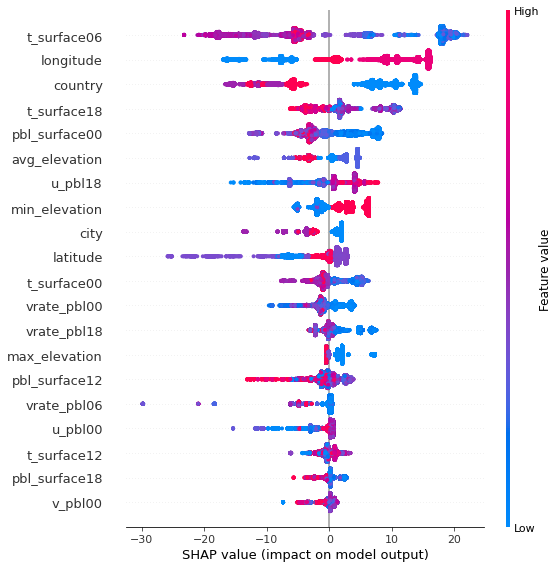

In [0]:
shap.summary_plot(shap_values, train_2[features_2])

In [0]:
shap.plots.force(shap_values)

--------------------------------------------------------------------------- 
 Exception Traceback (most recent call last)
 <command-776984683792415> in <module> 
 ----> 1 shap . plots . force ( shap_values ) 

 /databricks/python/lib/python3.8/site-packages/shap/plots/_force.py in force (base_value, shap_values, features, feature_names, out_names, link, plot_cmap, matplotlib, show, figsize, ordering_keys, ordering_keys_time_format, text_rotation, contribution_threshold) 
 96 if ( isinstance ( base_value , np . ndarray ) or type ( base_value ) == list ) : 
 97 if not isinstance ( shap_values , list ) or len ( shap_values ) != len ( base_value ) : 
 ---> 98 raise Exception("In v0.20 force_plot now requires the base value as the first parameter! " \
 99 "Try shap.force_plot(explainer.expected_value, shap_values) or " \ 
 100 "for multi-output models try " \ 

 Exception : In v0.20 force_plot now requires the base value as the first parameter! Try shap.force_plot(explainer.expected_value, shap_values) or for multi-output models try shap.force_plot(explainer.expected_value[0], shap_values[0]).

## Submission

#### Retrain Best Model on all Train Data

In [0]:
test_aod_gfs_joined_with_labels_read = aod_gfs_joined_with_labels_test

test_aod_gfs_joined_with_labels_read = test_aod_gfs_joined_with_labels_read.drop(*['datetime_utc'])
test_aod_gfs_joined_with_labels_read = test_aod_gfs_joined_with_labels_read.withColumn('year',sf.year(test_aod_gfs_joined_with_labels_read['date_utc']))\
                         .withColumn('month',sf.month(test_aod_gfs_joined_with_labels_read['date_utc']))\
                         .withColumn('day',sf.month(test_aod_gfs_joined_with_labels_read['date_utc']))
test_aod_gfs_joined_with_labels_read = test_aod_gfs_joined_with_labels_read.drop(*['date_utc'])
    

In [0]:
#Comparison point: Calculate R2 using trailing1day PM2.5 value as prediction 
preds_mean = test_aod_gfs_joined_with_labels_read.select(sf.avg('value_lag1day')).toPandas().values[0][0]
actual_mean = test_aod_gfs_joined_with_labels_read.select(sf.avg('value')).toPandas().values[0][0]

preds = np.array(test_aod_gfs_joined_with_labels_read.select('value_lag1day').fillna(preds_mean).toPandas())
y_true = np.array(test_aod_gfs_joined_with_labels_read.select('value').fillna(actual_mean).toPandas())
test_r2 = r2_score(y_pred=preds, y_true=y_true)
print(test_r2)

0.7507847889304426

In [0]:
preds_mean

Out[62]: 66.09713372316038

In [0]:
display(test_aod_gfs_joined_with_labels_read)

location parameter country city latitude longitude value value_lag1day difflag value_lag7day value_lag30day difflag_lag1day difflag_lag7day difflag_lag30day grid_id min_elevation max_elevation avg_elevation t_surface00 pbl_surface00 hindex_surface00 gust_surface00 r_atmosphere00 pwat_atmosphere00 u_pbl00 v_pbl00 vrate_pbl00 t_surface06 pbl_surface06 hindex_surface06 gust_surface06 r_atmosphere06 pwat_atmosphere06 u_pbl06 v_pbl06 vrate_pbl06 t_surface12 pbl_surface12 hindex_surface12 gust_surface12 r_atmosphere12 pwat_atmosphere12 u_pbl12 v_pbl12 vrate_pbl12 t_surface18 pbl_surface18 hindex_surface18 gust_surface18 r_atmosphere18 pwat_atmosphere18 u_pbl18 v_pbl18 vrate_pbl18 day_of_month day_of_week day_of_year week_of_year month year Optical_Depth_047_scaled day Anaheim pm25 US la 33.830586 -117.938509 12.949999999999996 11.6 -1.349999999999996 5.690909090909091 10.670588235294119 -1.1058823529411779 2.8140909090909076 -5.737254901960786 3S31A -8.44 1723.8 236.60681898148147 311.0091857910156 1794.98095703125 6.0 6.804688930511475 14.199999809265137 8.160148620605469 -0.22432556748390198 -0.9954773187637329 10000.0 306.6000061035156 2732.588623046875 6.0 6.805068016052246 13.199999809265137 8.789175033569336 2.4296905994415283 -1.9810699224472046 17000.0 290.9365539550781 158.49542236328125 6.0 8.401636123657227 16.600000381469727 10.1616792678833 0.29455262422561646 0.3315368592739105 1000.0 285.8634033203125 39.448768615722656 6.0 4.135039806365967 16.600000381469727 9.323342323303223 0.3477233946323395 0.6680237054824829 0.0 7 4 97 14 4 2021 10481.1493 4 Punjabi Bagh, Delhi - DPCC pm25 IN dl 28.674045 77.131023 123.5 154.75 31.25 93.77777777777777 128.73333333333332 -67.08333333333333 34.0138888888889 -20.73333333333332 SZLMT 176.04 336.64 209.25515617283952 293.7561340332031 291.5259704589844 6.0 5.713051795959473 32.0 22.200000762939453 -2.715179443359375 3.705127000808716 1600.0 291.29998779296875 105.79766082763672 6.0 5.5040669441223145 29.0 18.799999237060547 -0.5306732058525085 4.329736232757568 1000.0 308.32525634765625 4691.7666015625 6.0 25.105175018310547 26.299999237060547 15.261248588562012 23.980571746826172 9.975860595703125 118000.0 299.2815246582031 3304.9189453125 6.0 17.807819366455078 3.9000000953674316 2.330446720123291 20.428356170654297 -1.577551245689392 68000.0 21 1 80 11 3 2021 30178.378050000003 3 Shadipur, Delhi - CPCB pm25 IN dl 28.6514781 77.1473105 104.43 65.69416666666666 -38.735833333333346 88.31400000000001 70.21333333333332 -21.568284313725478 -45.6849090909091 -16.846060606060597 KZ9W9 176.04 336.64 209.25515617283952 288.3339538574219 176.0374298095703 6.0 11.205700874328613 12.199999809265137 7.66572380065918 6.008889675140381 -1.150933861732483 2000.0 283.1725769042969 11.440587997436523 6.0 2.9000000953674316 6.199999809265137 3.745638847351074 1.5138641595840454 2.3865904808044434 0.0 321.45849609375 2897.86279296875 6.0 10.10439682006836 6.400000095367432 4.242483139038086 9.857345581054688 4.799487113952637 31900.0 301.92938232421875 2429.18994140625 6.0 8.71498966217041 6.199999809265137 4.2634806632995605 8.836349487304688 1.2026550769805908 20300.0 27 7 86 12 3 2021 23456.771800000002 3 Shadipur, Delhi - CPCB pm25 IN dl 28.6514781 77.1473105 133.07000000000002 86.54000000000002 -46.53 70.21333333333332 92.9632 -50.91045454545456 -16.846060606060597 -18.754563636363628 KZ9W9 176.04 336.64 209.25515617283952 293.0352783203125 409.86993408203125 6.0 13.902103424072266 17.0 11.800000190734863 7.845542907714844 -1.8921546936035156 6000.0 286.800048828125 119.14691162109375 5.0 7.199999809265137 11.0 6.900000095367432 4.542987823486328 -2.7311019897460938 1000.0 306.4443359375 1588.410888671875 5.0 9.910789489746094 11.0 6.800859451293945 4.271724700927734 -7.585655212402344 18000.0 295.7477111816406 1852.909912109375 6.0 9.901237487792969 14.0 8.399999618530273 1.62408447265625 -8.477149963378906 21000.0 4 5 63 9 3 2021 18313.2818 3 Anand Vihar, Delhi - DPCC pm25 IN dl 28.6508 77.315

In [0]:
#averaging gfs time based features
# cols_00 = [col for col in test_aod_gfs_joined_with_labels_read.columns if '00' in col]
# cols_06 = [col for col in test_aod_gfs_joined_with_labels_read.columns if '06' in col]
# cols_12 = [col for col in test_aod_gfs_joined_with_labels_read.columns if '12' in col]
# cols_18 = [col for col in test_aod_gfs_joined_with_labels_read.columns if '18' in col]
# for i in range(len(cols_00)):
#     colName = cols_00[i].replace("00","")
#     test_aod_gfs_joined_with_labels_read = test_aod_gfs_joined_with_labels_read.withColumn(colName, avg_cols(sf.array(cols_00[i], cols_06[i],cols_12[i],cols_18[i])))

In [0]:
# test_aod_gfs_joined_with_labels_read = test_aod_gfs_joined_with_labels_read.drop(*cols_00)
# test_aod_gfs_joined_with_labels_read = test_aod_gfs_joined_with_labels_read.drop(*cols_06)
# test_aod_gfs_joined_with_labels_read = test_aod_gfs_joined_with_labels_read.drop(*cols_12)
# test_aod_gfs_joined_with_labels_read = test_aod_gfs_joined_with_labels_read.drop(*cols_18)

In [0]:
# if FEATURE_ENG_TIME: 
#     test_aod_gfs_joined_with_labels_read = feature_eng_time(test_aod_gfs_joined_with_labels_read)

# test_aod_gfs_joined_with_labels_read = test_aod_gfs_joined_with_labels_read.withColumn('day_of_month', dayofmonth(test_aod_gfs_joined_with_labels_read.datetime))
# test_aod_gfs_joined_with_labels_read = test_aod_gfs_joined_with_labels_read.withColumn('day_of_week', dayofweek(test_aod_gfs_joined_with_labels_read.datetime))
# test_aod_gfs_joined_with_labels_read = test_aod_gfs_joined_with_labels_read.withColumn('day_of_year', dayofyear(test_aod_gfs_joined_with_labels_read.datetime))
# test_aod_gfs_joined_with_labels_read = test_aod_gfs_joined_with_labels_read.withColumn('week_of_year', weekofyear(test_aod_gfs_joined_with_labels_read.datetime))
# test_aod_gfs_joined_with_labels_read = test_aod_gfs_joined_with_labels_read.withColumn('month', month(test_aod_gfs_joined_with_labels_read.datetime))
# test_aod_gfs_joined_with_labels_read = test_aod_gfs_joined_with_labels_read.withColumn('year', year(test_aod_gfs_joined_with_labels_read.datetime))

In [0]:
# test_cols_aod = [col for col in test_aod_gfs_joined_with_labels_read.columns if '_047' in col or '_055' in col]
# test_cols_aod = test_cols_aod + ['Aerosol_Optical_Depth','Absorption_Aerosol_Optical_Depth','Nonspherical_Aerosol_Optical_Depth',
#                  'Small_Mode_Aerosol_Optical_Depth','Medium_Mode_Aerosol_Optical_Depth','Large_Mode_Aerosol_Optical_Depth']

# for col_aod in test_cols_aod:
#     test_aod_gfs_joined_with_labels_read = test_aod_gfs_joined_with_labels_read.withColumn(col_aod+'_scaled',aod_scale_udf(test_aod_gfs_joined_with_labels_read[col_aod]))
# test_aod_gfs_joined_with_labels_read = test_aod_gfs_joined_with_labels_read.drop(*test_cols_aod)

In [0]:
# if FEATURE_ENG_TRAILING: 
#     test_aod_gfs_joined_with_labels_read = trailing_features(test_aod_gfs_joined_with_labels_read,['min_Optical_Depth_047_scaled',
#                                                                                'max_Optical_Depth_047_scaled',
#                                                                                'median_Optical_Depth_047_scaled',
#                                                                                'min_Optical_Depth_055_scaled',
#                                                                                'max_Optical_Depth_055_scaled',
#                                                                                'median_Optical_Depth_055_scaled'])

In [0]:
# test_aod_gfs_joined_with_labels_read = test_aod_gfs_joined_with_labels_read.withColumn('wind_speed', 
#                    (((test_aod_gfs_joined_with_labels_read['avg(max(u_pbl_new))']**2)+
#                     (test_aod_gfs_joined_with_labels_read['avg(max(v_pbl_new))'])**2)**(1/2)))

In [0]:
# test_aod_gfs_joined_with_labels = test_aod_gfs_joined_with_labels_read.select(*['trailing1d_min_Optical_Depth_047_scaled',
#                                                                       'trailing1d_max_Optical_Depth_047_scaled',
#                                                                       'trailing1d_median_Optical_Depth_047_scaled',
#                                                                         'day_of_year',
#                                                                         'month',
#                                                                         'week_of_year',
#                                                                         'Aerosol_Optical_Depth_scaled',
#                                                                         'min_Optical_Depth_047_scaled',
#                                                                         'max_Optical_Depth_047_scaled',
#                                                                         'median_Optical_Depth_047_scaled',
#                                                                         'min_Optical_Depth_055_scaled',
#                                                                         'max_Optical_Depth_055_scaled',
#                                                                         'median_Optical_Depth_055_scaled',
#                                                                         'Angstrom_Exponent_550_860nm',
#                                                                         'min_elevation',
#                                                                         'max_elevation',
#                                                                         'avg_elevation',
#                                                                         'avg(max(t_surface_new))',
#                                                                         'avg(max(pbl_surface_new))',
#                                                                         'avg(max(hindex_surface_new))',
#                                                                         'avg(max(gust_surface_new))',
#                                                                         'avg(max(r_atmosphere_new))',
#                                                                         'avg(max(pwat_atmosphere_new))',
#                                                                         'avg(max(vrate_pbl_new))',
#                                                                         'wind_speed',
#                                                                         'value',
#                                                                         'datetime',
#                                                                         'grid_id'
#                                                                         ])

In [0]:
test_full = test_aod_gfs_joined_with_labels_read.toPandas()
features_clean = [ col for col in test_full.columns ] 
test_clean = test_full[features_clean].values
# aod_gfs_joined_with_labels_test = aod_gfs_joined_with_labels_test.drop(*['datetime_utc','date_utc','grid_id','difflag'])

In [0]:
test_full.columns

Out[106]: Index(['location', 'parameter', 'country', 'city', 'latitude', 'longitude',
 'value', 'value_lag1day', 'difflag', 'value_lag7day', 'value_lag30day',
 'difflag_lag1day', 'difflag_lag7day', 'difflag_lag30day', 'grid_id',
 'Optical_Depth_047', 'min_elevation', 'max_elevation', 'avg_elevation',
 't_surface00', 'pbl_surface00', 'hindex_surface00', 'gust_surface00',
 'r_atmosphere00', 'pwat_atmosphere00', 'u_pbl00', 'v_pbl00',
 'vrate_pbl00', 't_surface06', 'pbl_surface06', 'hindex_surface06',
 'gust_surface06', 'r_atmosphere06', 'pwat_atmosphere06', 'u_pbl06',
 'v_pbl06', 'vrate_pbl06', 't_surface12', 'pbl_surface12',
 'hindex_surface12', 'gust_surface12', 'r_atmosphere12',
 'pwat_atmosphere12', 'u_pbl12', 'v_pbl12', 'vrate_pbl12', 't_surface18',
 'pbl_surface18', 'hindex_surface18', 'gust_surface18', 'r_atmosphere18',
 'pwat_atmosphere18', 'u_pbl18', 'v_pbl18', 'vrate_pbl18', 'year',
 'month', 'day'],
 dtype='object')

In [0]:
train = tabnet_df.drop(*['Set']).toPandas()
test = test_aod_gfs_joined_with_labels_read.toPandas()
target = 'value'

In [0]:
USE_LAG = True

In [0]:
# Whether or not to use trailingPM2.5 data. 
if USE_LAG: 
    lag_feats = []
else: 
    lag_feats = [c for c in train.columns if 'lag' in c]

for col in train.columns[train.dtypes != object]:
    if col != target :#and col not in ['year','month','day']:
        train[col].fillna(train[col].mean(), inplace=True)
        test[col].fillna(train[col].mean(), inplace=True)
        
categorical_columns = []
# categorical_dims =  {}
for col in train.columns[train.dtypes == object]:
    l_enc = LabelEncoderExt()
    print(col, train[col].nunique())
    train[col] = train[col].fillna("VV_likely")
    test[col] = test[col].fillna("VV_likely")
    l_enc.fit(train[col])
    train[col] = l_enc.transform(train[col])
    test[col] = l_enc.transform(test[col])
    categorical_columns.append(col)
#     categorical_dims[col] = len(l_enc.classes_)

unused_feat = ['Set', 'rank', 'location', 'parameter', 'difflag'] + lag_feats

#Drop all categorical features as location based features can be learned through lat, lon. 
# features = [ col for col in train.columns if col not in unused_feat+categorical_columns+[target]] 
features = [ col for col in train.columns if col not in unused_feat+[target]] 

# categorical_columns = []
# categorical_dims =  {}
# for col in train.columns[train.dtypes == object]:
#     print(col, train[col].nunique())
#     l_enc = LabelEncoder()
#     train[col] = train[col].fillna("VV_likely")
#     if col != 'Set' and col != 'pm25_reading_date':
#         test[col] = test[col].fillna("VV_likely")
#     train[col] = l_enc.fit_transform(train[col].values)
#     if col != 'Set' and col != 'pm25_reading_date': 
#         test[col] = l_enc.transform(test[col].values)
#     categorical_columns.append(col)
#     categorical_dims[col] = len(l_enc.classes_)

# for col in train.columns[train.dtypes == 'float64']:
#     train.fillna(train[col].mean(), inplace=True)
#     test.fillna(train[col].mean(), inplace = True)

location 64
parameter 1
country 3
city 3
grid_id 9

In [0]:
# unused_feat = ['Set', 'rank', 'location', 'parameter']

# features = [ col for col in train.columns if col not in unused_feat+[target]] 

# cat_idxs = [ i for i, f in enumerate(features) if f in categorical_columns]

# cat_dims = [ categorical_dims[f] for i, f in enumerate(features) if f in categorical_columns]

# # define your embedding sizes : here just a random choice
# cat_emb_dim = cat_dims

In [0]:
features

Out[118]: ['country',
 'city',
 'latitude',
 'longitude',
 'value_lag1day',
 'value_lag7day',
 'value_lag30day',
 'difflag_lag1day',
 'difflag_lag7day',
 'difflag_lag30day',
 'grid_id',
 'Optical_Depth_047',
 'min_elevation',
 'max_elevation',
 'avg_elevation',
 't_surface00',
 'pbl_surface00',
 'hindex_surface00',
 'gust_surface00',
 'r_atmosphere00',
 'pwat_atmosphere00',
 'u_pbl00',
 'v_pbl00',
 'vrate_pbl00',
 't_surface06',
 'pbl_surface06',
 'hindex_surface06',
 'gust_surface06',
 'r_atmosphere06',
 'pwat_atmosphere06',
 'u_pbl06',
 'v_pbl06',
 'vrate_pbl06',
 't_surface12',
 'pbl_surface12',
 'hindex_surface12',
 'gust_surface12',
 'r_atmosphere12',
 'pwat_atmosphere12',
 'u_pbl12',
 'v_pbl12',
 'vrate_pbl12',
 't_surface18',
 'pbl_surface18',
 'hindex_surface18',
 'gust_surface18',
 'r_atmosphere18',
 'pwat_atmosphere18',
 'u_pbl18',
 'v_pbl18',
 'vrate_pbl18',
 'year',
 'month',
 'day']

In [0]:
X_train = train[features].values
y_train = train[target].values.reshape(-1, 1)

X_test = test[features].values
y_test = test[target].values.reshape(-1, 1)

In [0]:
clf_xgb = XGBRegressor(base_score=0.5, booster='dart', colsample_bylevel=0.3959137968655604, colsample_bynode=0.38427772092378626, colsample_bytree=0.7366289714335655, enable_categorical=False, gamma=14.0281111983136, gpu_id=-1, importance_type=None, interaction_constraints='', learning_rate=0.5386955173692471, max_delta_step=6, max_depth=8, min_child_weight=0.4016920074761443, monotone_constraints='()', n_estimators=900, n_jobs=8, num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=22, reg_lambda=204, scale_pos_weight=1, subsample=0.8783345980525217, tree_method='exact', validate_parameters=1, verbosity=None)

In [0]:
clf_xgb.fit(X_train, y_train,
        verbose=10)

Out[122]: XGBRegressor(base_score=0.5, booster='dart',
 colsample_bylevel=0.3959137968655604,
 colsample_bynode=0.38427772092378626,
 colsample_bytree=0.7366289714335655, enable_categorical=False,
 gamma=14.0281111983136, gpu_id=-1, importance_type=None,
 interaction_constraints='', learning_rate=0.5386955173692471,
 max_delta_step=6, max_depth=8, min_child_weight=0.4016920074761443,
 missing=nan, monotone_constraints='()', n_estimators=900, n_jobs=8,
 num_parallel_tree=1, predictor='auto', random_state=0,
 reg_alpha=22, reg_lambda=204, scale_pos_weight=1,
 subsample=0.8783345980525217, tree_method='exact',
 validate_parameters=1, verbosity=None)

#### Make predictions on test data.

In [0]:
preds = np.array(clf_xgb.predict(X_train))
train_r2 = r2_score(y_pred=preds, y_true=y_train)
print(train_r2)

preds = np.array(clf_xgb.predict(X_test))
test_r2 = r2_score(y_pred=preds, y_true=y_test)
print(test_r2)

0.9963619301760076
0.6901027733260381

In [0]:
len(X_test)

Out[124]: 10225

In [0]:
len(preds)

Out[125]: 10225

Out[126]:

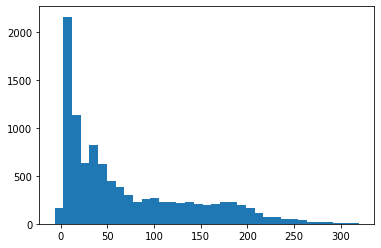

(array([ 169., 2162., 1131., 639., 826., 628., 445., 381., 297.,
 227., 260., 267., 224., 232., 222., 225., 205., 197.,
 211., 224., 230., 194., 161., 112., 71., 76., 54.,
 47., 35., 23., 17., 15., 6., 6., 6.]),
 array([ -6.2926283, 3.0105278, 12.313684 , 21.61684 , 30.919996 ,
 40.223152 , 49.52631 , 58.829464 , 68.13262 , 77.435776 ,
 86.73894 , 96.04209 , 105.345245 , 114.6484 , 123.95156 ,
 133.25471 , 142.55788 , 151.86102 , 161.16418 , 170.46735 ,
 179.7705 , 189.07365 , 198.37682 , 207.67996 , 216.98312 ,
 226.28629 , 235.58943 , 244.8926 , 254.19574 , 263.4989 ,
 272.80206 , 282.10522 , 291.4084 , 300.71152 , 310.01468 ,
 319.31784 ], dtype=float32),
 <BarContainer object of 35 artists>)

In [0]:
plt.hist(preds, bins='auto')

In [0]:
df = pd.DataFrame(data = X_test, columns = features)

In [0]:
df['prediction'] = preds
df['actual'] = y_test
df

Out[128]:

country 
 city 
 latitude 
 longitude 
 value_lag1day 
 value_lag7day 
 value_lag30day 
 difflag_lag1day 
 difflag_lag7day 
 difflag_lag30day 
 grid_id 
 Optical_Depth_047 
 min_elevation 
 max_elevation 
 avg_elevation 
 t_surface00 
 pbl_surface00 
 hindex_surface00 
 gust_surface00 
 r_atmosphere00 
 pwat_atmosphere00 
 u_pbl00 
 v_pbl00 
 vrate_pbl00 
 t_surface06 
 pbl_surface06 
 hindex_surface06 
 gust_surface06 
 r_atmosphere06 
 pwat_atmosphere06 
 u_pbl06 
 v_pbl06 
 vrate_pbl06 
 t_surface12 
 pbl_surface12 
 hindex_surface12 
 gust_surface12 
 r_atmosphere12 
 pwat_atmosphere12 
 u_pbl12 
 v_pbl12 
 vrate_pbl12 
 t_surface18 
 pbl_surface18 
 hindex_surface18 
 gust_surface18 
 r_atmosphere18 
 pwat_atmosphere18 
 u_pbl18 
 v_pbl18 
 vrate_pbl18 
 year 
 month 
 day 
 prediction 
 actual 
 
 
 
 
 0 
 2.0 
 2.0 
 33.830586 
 -117.938509 
 11.600000 
 5.690909 
 10.670588 
 -1.105882 
 2.814091 
 -5.737255 
 0.0 
 224.00000 
 -8.44 
 1723.80 
 236.606819 
 311.009186 
 1794.980957 
 6.000000 
 6.804689 
 14.200000 
 8.160149 
 -0.224326 
 -0.995477 
 10000.000000 
 306.600006 
 2732.588623 
 6.000000 
 6.805068 
 13.200000 
 8.789175 
 2.429691 
 -1.981070 
 17000.000000 
 290.936554 
 158.495422 
 6.000000 
 8.401636 
 16.600000 
 10.161679 
 0.294553 
 0.331537 
 1000.000000 
 285.863403 
 39.448769 
 6.000000 
 4.135040 
 16.600000 
 9.323342 
 0.347723 
 0.668024 
 0.000000 
 2021.0 
 4.0 
 4.0 
 9.592319 
 12.950000 
 
 
 1 
 0.0 
 1.0 
 28.636429 
 77.201067 
 50.000000 
 83.666667 
 46.000000 
 3.000000 
 -34.666667 
 36.000000 
 9.0 
 496.87469 
 176.04 
 336.64 
 209.255156 
 299.428131 
 502.309631 
 4.000000 
 11.310083 
 34.200001 
 30.536022 
 -3.178662 
 4.725616 
 5400.000000 
 296.319916 
 80.211388 
 4.000000 
 2.109406 
 35.900002 
 28.560877 
 -0.057150 
 0.830170 
 100.000000 
 326.200012 
 1586.413696 
 6.000000 
 4.116429 
 35.900002 
 30.231409 
 0.793378 
 3.785465 
 7600.000000 
 303.224426 
 857.771606 
 5.000000 
 19.722095 
 53.000000 
 43.685635 
 2.178445 
 22.889572 
 18300.000000 
 2021.0 
 5.0 
 5.0 
 34.208134 
 14.000000 
 
 
 2 
 0.0 
 1.0 
 28.732528 
 77.119920 
 17.000000 
 74.500000 
 104.500000 
 93.000000 
 -17.000000 
 80.500000 
 9.0 
 496.87469 
 176.04 
 336.64 
 209.255156 
 285.958527 
 338.112946 
 3.000000 
 10.801519 
 24.000000 
 15.810654 
 -0.390480 
 7.042221 
 3000.000000 
 283.108459 
 52.986744 
 2.000000 
 3.412154 
 20.400000 
 13.067833 
 -0.526352 
 2.200249 
 0.000000 
 327.158508 
 2071.051514 
 6.000000 
 6.415729 
 16.900000 
 11.924983 
 5.873151 
 2.761560 
 13000.000000 
 304.958496 
 2649.159912 
 6.000000 
 5.017095 
 14.200000 
 11.136108 
 4.049676 
 2.640280 
 10000.000000 
 2021.0 
 4.0 
 4.0 
 50.392708 
 57.000000 
 
 
 3 
 0.0 
 1.0 
 28.695381 
 77.181665 
 80.000000 
 53.000000 
 100.090909 
 -56.000000 
 53.000000 
 3.000000 
 9.0 
 496.87469 
 176.04 
 336.64 
 209.255156 
 298.509064 
 255.071182 
 6.000000 
 9.710378 
 16.600000 
 15.345829 
 -2.403667 
 3.896507 
 2000.000000 
 293.700012 
 94.934998 
 6.000000 
 6.117109 
 15.200000 
 12.986067 
 0.663647 
 4.553131 
 1000.000000 
 329.611053 
 2622.209961 
 6.000000 
 7.036039 
 12.100000 
 10.683254 
 6.539238 
 4.078350 
 18000.000000 
 313.500000 
 3568.745605 
 6.000000 
 5.814854 
 19.299999 
 18.650097 
 4.545998 
 2.988220 
 16000.000000 
 2021.0 
 5.0 
 5.0 
 73.560715 
 35.000000 
 
 
 4 
 0.0 
 1.0 
 28.628624 
 77.241060 
 34.000000 
 303.000000 
 80.000000 
 -9.000000 
 -205.000000 
 41.000000 
 9.0 
 496.87469 
 176.04 
 336.64 
 209.255156 
 298.397186 
 641.277039 
 5.000000 
 11.120284 
 36.299999 
 29.414637 
 -3.742443 
 7.555801 
 7000.000000 
 293.778198 
 220.584488 
 6.000000 
 7.533391 
 33.299999 
 24.780643 
 -0.173855 
 5.564163 
 2000.000000 
 325.448181 
 2070.057617 
 6.000000 
 7.103868 
 23.200001 
 19.442608 
 4.085060 
 6.615265 
 17000.000000 
 306.481720 
 749.180542 
 6.000000 
 6.312491 
 33.299999 
 27.135366 
 -0.303046 
 6.240655 
 5000.0000

In [0]:
df.sort_values(by = 'actual')

Out[129]:

country 
 city 
 latitude 
 longitude 
 value_lag1day 
 value_lag7day 
 value_lag30day 
 difflag_lag1day 
 difflag_lag7day 
 difflag_lag30day 
 grid_id 
 Optical_Depth_047 
 min_elevation 
 max_elevation 
 avg_elevation 
 t_surface00 
 pbl_surface00 
 hindex_surface00 
 gust_surface00 
 r_atmosphere00 
 pwat_atmosphere00 
 u_pbl00 
 v_pbl00 
 vrate_pbl00 
 t_surface06 
 pbl_surface06 
 hindex_surface06 
 gust_surface06 
 r_atmosphere06 
 pwat_atmosphere06 
 u_pbl06 
 v_pbl06 
 vrate_pbl06 
 t_surface12 
 pbl_surface12 
 hindex_surface12 
 gust_surface12 
 r_atmosphere12 
 pwat_atmosphere12 
 u_pbl12 
 v_pbl12 
 vrate_pbl12 
 t_surface18 
 pbl_surface18 
 hindex_surface18 
 gust_surface18 
 r_atmosphere18 
 pwat_atmosphere18 
 u_pbl18 
 v_pbl18 
 vrate_pbl18 
 year 
 month 
 day 
 prediction 
 actual 
 
 
 
 
 3313 
 2.0 
 2.0 
 33.830586 
 -117.938509 
 10.150000 
 9.894444 
 2.411111 
 -1.403333 
 -4.155314 
 -0.391111 
 0.0 
 149.50000 
 -8.44 
 1723.80 
 236.606819 
 328.841492 
 2225.843018 
 6.000000 
 17.100000 
 18.299999 
 18.137987 
 -2.168720 
 0.477124 
 25000.000000 
 320.222412 
 3884.824951 
 6.000000 
 16.423193 
 18.400000 
 18.622080 
 1.428009 
 -1.082047 
 31900.000000 
 300.399994 
 809.628906 
 6.000000 
 22.036623 
 16.700001 
 17.371572 
 -1.076358 
 -2.090649 
 15900.000000 
 295.994751 
 672.360779 
 6.000000 
 20.317595 
 15.700000 
 15.576422 
 -0.694556 
 -0.513574 
 12900.000000 
 2021.0 
 7.0 
 7.0 
 3.392522 
 0.700000 
 
 
 5970 
 2.0 
 2.0 
 34.199200 
 -118.533100 
 2.873684 
 8.433333 
 8.668182 
 3.482838 
 2.175362 
 -1.829051 
 9.0 
 496.87469 
 -5.24 
 2438.08 
 735.564355 
 296.217438 
 841.814819 
 6.000000 
 3.600342 
 21.000000 
 9.090587 
 1.657480 
 1.957031 
 3000.000000 
 295.603882 
 1634.493408 
 6.000000 
 2.607422 
 18.100000 
 8.191526 
 2.338470 
 1.247086 
 3900.000000 
 284.425507 
 14.492914 
 6.000000 
 2.025409 
 20.799999 
 10.106883 
 1.570309 
 1.817267 
 0.000000 
 284.437103 
 43.628326 
 6.000000 
 3.502878 
 28.100000 
 12.879522 
 0.870279 
 1.847498 
 0.000000 
 2022.0 
 3.0 
 3.0 
 8.942677 
 1.333333 
 
 
 5163 
 0.0 
 1.0 
 28.588333 
 77.221667 
 99.260000 
 406.380000 
 47.181667 
 0.010000 
 -367.990000 
 11.420833 
 9.0 
 496.87469 
 176.04 
 336.64 
 209.255156 
 285.958527 
 338.112946 
 3.000000 
 10.801519 
 24.000000 
 15.810654 
 -0.390480 
 7.042221 
 3000.000000 
 282.045105 
 98.735207 
 3.000000 
 4.600000 
 26.200001 
 15.035318 
 -0.426914 
 0.468742 
 0.000000 
 327.600006 
 1615.306274 
 4.000000 
 6.722412 
 29.100000 
 16.866970 
 -0.334839 
 5.873520 
 11000.000000 
 302.700012 
 997.102966 
 6.000000 
 6.903613 
 27.400000 
 18.747356 
 -1.423260 
 3.506180 
 8000.000000 
 2021.0 
 4.0 
 4.0 
 89.336937 
 1.360000 
 
 
 9122 
 0.0 
 1.0 
 28.591825 
 77.227307 
 18.480000 
 19.082500 
 21.023333 
 19.220000 
 -2.672500 
 -11.003333 
 9.0 
 496.87469 
 176.04 
 336.64 
 209.255156 
 301.663025 
 1087.861694 
 5.000000 
 11.501315 
 36.500000 
 31.989460 
 -3.801733 
 7.107666 
 14300.000000 
 298.394653 
 218.906631 
 5.000000 
 6.032136 
 47.599998 
 36.557770 
 -1.591971 
 2.225854 
 1000.000000 
 327.641052 
 2440.278320 
 6.000000 
 5.719923 
 42.700001 
 36.404922 
 -1.822260 
 2.733685 
 13000.000000 
 311.522675 
 2081.208984 
 6.000000 
 8.507729 
 32.400002 
 29.877724 
 -7.287539 
 5.597486 
 21600.000000 
 2021.0 
 8.0 
 8.0 
 17.108608 
 1.430000 
 
 
 8903 
 1.0 
 3.0 
 25.182722 
 121.529583 
 6.500000 
 7.333333 
 10.521739 
 7.250000 
 0.393939 
 -3.416476 
 9.0 
 496.87469 
 -11.52 
 1087.12 
 23.344317 
 297.257965 
 1165.474731 
 5.328774 
 7.705701 
 34.599998 
 23.753798 
 5.679339 
 -4.965833 
 9000.000000 
 297.119324 
 1083.064331 
 5.152496 
 4.122833 
 26.700001 
 19.109058 
 1.294287 
 -3.507935 
 5000.000000 
 298.100006 
 1166.702026 
 5.433229 
 4.700147 
 26.900000 
 19.900499 
 2.904816 
 -2.385513 
 5000.000000 
 297.000000 
 907.839539 
 5.605024 
 1.717533 
 21.299999 
 16.670996 
 0.196814 
 -1.072476 

## Calculate AQI Classification Error

In [0]:
def getAQIClassification(value): 
    if value <= 30.0: 
        aqi = 'Good'
    elif value <= 60.0: 
        aqi = 'Satisfactory'
    elif value <= 90.0: 
        aqi = 'Moderately Polluted'
    elif value <= 120.0: 
        aqi = 'Poor'
    elif value <= 250.0: 
        aqi = 'Very Poor'
    else: 
        aqi = 'Severe'
    
    return aqi 

In [0]:
actual_aqi = []
pred_aqi = []
aqi_hit = [] 

for index, row in df.iterrows():
    pred = row['prediction']
    actual = row['actual']
    
    act_aqi_class = getAQIClassification(actual)
    pred_aqi_class = getAQIClassification(pred)
    
    if act_aqi_class == pred_aqi_class: 
        aqi_class_hit = 1
    else: 
        aqi_class_hit = 0
   
    actual_aqi.append(act_aqi_class)
    pred_aqi.append(pred_aqi_class)
    aqi_hit.append(aqi_class_hit)
    
df['actual_aqi'] = actual_aqi
df['pred_aqi'] = pred_aqi
df['aqi_hit'] = aqi_hit
df['count'] = 1

In [0]:
import datetime

dates = []
for index, row in df.iterrows():
    dates.append(datetime.datetime(int(row['year']), int(row['month']), int(row['day'])))
    
df['date'] = dates

In [0]:
df

Out[138]:

country 
 city 
 latitude 
 longitude 
 value_lag1day 
 value_lag7day 
 value_lag30day 
 difflag_lag1day 
 difflag_lag7day 
 difflag_lag30day 
 grid_id 
 Optical_Depth_047 
 min_elevation 
 max_elevation 
 avg_elevation 
 t_surface00 
 pbl_surface00 
 hindex_surface00 
 gust_surface00 
 r_atmosphere00 
 pwat_atmosphere00 
 u_pbl00 
 v_pbl00 
 vrate_pbl00 
 t_surface06 
 pbl_surface06 
 hindex_surface06 
 gust_surface06 
 r_atmosphere06 
 pwat_atmosphere06 
 u_pbl06 
 v_pbl06 
 vrate_pbl06 
 t_surface12 
 pbl_surface12 
 hindex_surface12 
 gust_surface12 
 r_atmosphere12 
 pwat_atmosphere12 
 u_pbl12 
 v_pbl12 
 vrate_pbl12 
 t_surface18 
 pbl_surface18 
 hindex_surface18 
 gust_surface18 
 r_atmosphere18 
 pwat_atmosphere18 
 u_pbl18 
 v_pbl18 
 vrate_pbl18 
 year 
 month 
 day 
 prediction 
 actual 
 actual_aqi 
 pred_aqi 
 aqi_hit 
 count 
 date 
 
 
 
 
 0 
 2.0 
 2.0 
 33.830586 
 -117.938509 
 11.600000 
 5.690909 
 10.670588 
 -1.105882 
 2.814091 
 -5.737255 
 0.0 
 224.00000 
 -8.44 
 1723.80 
 236.606819 
 311.009186 
 1794.980957 
 6.000000 
 6.804689 
 14.200000 
 8.160149 
 -0.224326 
 -0.995477 
 10000.000000 
 306.600006 
 2732.588623 
 6.000000 
 6.805068 
 13.200000 
 8.789175 
 2.429691 
 -1.981070 
 17000.000000 
 290.936554 
 158.495422 
 6.000000 
 8.401636 
 16.600000 
 10.161679 
 0.294553 
 0.331537 
 1000.000000 
 285.863403 
 39.448769 
 6.000000 
 4.135040 
 16.600000 
 9.323342 
 0.347723 
 0.668024 
 0.000000 
 2021.0 
 4.0 
 4.0 
 9.592319 
 12.950000 
 Good 
 Good 
 1 
 1 
 2021-04-04 
 
 
 1 
 0.0 
 1.0 
 28.636429 
 77.201067 
 50.000000 
 83.666667 
 46.000000 
 3.000000 
 -34.666667 
 36.000000 
 9.0 
 496.87469 
 176.04 
 336.64 
 209.255156 
 299.428131 
 502.309631 
 4.000000 
 11.310083 
 34.200001 
 30.536022 
 -3.178662 
 4.725616 
 5400.000000 
 296.319916 
 80.211388 
 4.000000 
 2.109406 
 35.900002 
 28.560877 
 -0.057150 
 0.830170 
 100.000000 
 326.200012 
 1586.413696 
 6.000000 
 4.116429 
 35.900002 
 30.231409 
 0.793378 
 3.785465 
 7600.000000 
 303.224426 
 857.771606 
 5.000000 
 19.722095 
 53.000000 
 43.685635 
 2.178445 
 22.889572 
 18300.000000 
 2021.0 
 5.0 
 5.0 
 34.208134 
 14.000000 
 Good 
 Satisfactory 
 0 
 1 
 2021-05-05 
 
 
 2 
 0.0 
 1.0 
 28.732528 
 77.119920 
 17.000000 
 74.500000 
 104.500000 
 93.000000 
 -17.000000 
 80.500000 
 9.0 
 496.87469 
 176.04 
 336.64 
 209.255156 
 285.958527 
 338.112946 
 3.000000 
 10.801519 
 24.000000 
 15.810654 
 -0.390480 
 7.042221 
 3000.000000 
 283.108459 
 52.986744 
 2.000000 
 3.412154 
 20.400000 
 13.067833 
 -0.526352 
 2.200249 
 0.000000 
 327.158508 
 2071.051514 
 6.000000 
 6.415729 
 16.900000 
 11.924983 
 5.873151 
 2.761560 
 13000.000000 
 304.958496 
 2649.159912 
 6.000000 
 5.017095 
 14.200000 
 11.136108 
 4.049676 
 2.640280 
 10000.000000 
 2021.0 
 4.0 
 4.0 
 50.392708 
 57.000000 
 Satisfactory 
 Satisfactory 
 1 
 1 
 2021-04-04 
 
 
 3 
 0.0 
 1.0 
 28.695381 
 77.181665 
 80.000000 
 53.000000 
 100.090909 
 -56.000000 
 53.000000 
 3.000000 
 9.0 
 496.87469 
 176.04 
 336.64 
 209.255156 
 298.509064 
 255.071182 
 6.000000 
 9.710378 
 16.600000 
 15.345829 
 -2.403667 
 3.896507 
 2000.000000 
 293.700012 
 94.934998 
 6.000000 
 6.117109 
 15.200000 
 12.986067 
 0.663647 
 4.553131 
 1000.000000 
 329.611053 
 2622.209961 
 6.000000 
 7.036039 
 12.100000 
 10.683254 
 6.539238 
 4.078350 
 18000.000000 
 313.500000 
 3568.745605 
 6.000000 
 5.814854 
 19.299999 
 18.650097 
 4.545998 
 2.988220 
 16000.000000 
 2021.0 
 5.0 
 5.0 
 73.560715 
 35.000000 
 Satisfactory 
 Moderately Polluted 
 0 
 1 
 2021-05-05 
 
 
 4 
 0.0 
 1.0 
 28.628624 
 77.241060 
 34.000000 
 303.000000 
 80.000000 
 -9.000000 
 -205.000000 
 41.000000 
 9.0 
 496.87469 
 176.04 
 336.64 
 209.255156 
 298.397186 
 641.277039 
 5.000000 
 11.120284 
 36.299999 
 29.414637 
 -3.742443 
 7.555801 
 7000.000000 
 293.778198 
 220.584488 
 6.000000 
 7.533391 
 33.299999 
 24.780643 
 -0.173855 
 5.5

In [0]:
spark_df = spark.createDataFrame(df) 

In [0]:
#Plot trailing 10 day by location
def get_past_10_days(lat, lon):
    where_condition = "round(latitude,2) =="+str(round(lat,2))+" and round(longitude,2) =="+str(round(lon,2))+ " and date >= date_sub(current_date(), 20)"
    df_trailing = spark_df.where(where_condition).sort('date', ascending = False)
    df_trailing = df_trailing.select('date', 'actual')
    df_trailing = df_trailing.toPandas()
    plt.bar(df_trailing['date'], df_trailing['actual'])

In [0]:
where_condition = "round(latitude,2) =="+str(round(33.830,2))+" and round(longitude,2) =="+str(round(-117.94,2))#+ " and date >= date_sub(current_date(), 20)"
spark_df.where(where_condition).agg({'date':'max'}).show()#count()

+-------------------+
 max(date)|
+-------------------+
2022-03-03 00:00:00|
+-------------------+

In [0]:
spark_df.agg({'date':'max'}).show()

+-------------------+
 max(date)|
+-------------------+
2022-03-03 00:00:00|
+-------------------+

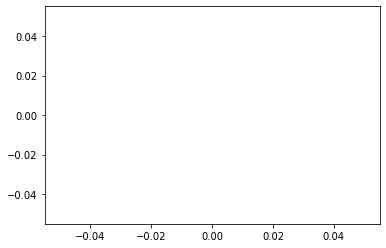

In [0]:
get_past_10_days(33.830,	-117.94)

In [0]:
df_mean = df[['prediction', 'actual']].mean()
df_mean['rmse'] = ((df_mean['prediction'] - df_mean['actual'])**2)**0.5
df_mean

Out[172]: prediction 68.772636
actual 75.038454
rmse 6.265818
dtype: float64

In [0]:
df_hits = df[['actual_aqi', 'aqi_hit', 'count']].groupby('actual_aqi').sum()
df_hits['percentage'] = df_hits['aqi_hit'] / df_hits['count']
df_hits

Out[163]:

aqi_hit 
 count 
 percentage 
 
 
 actual_aqi 
 
 
 
 
 
 
 
 Good 
 3684 
 4519 
 0.815225 
 
 
 Moderately Polluted 
 277 
 969 
 0.285862 
 
 
 Poor 
 154 
 658 
 0.234043 
 
 
 Satisfactory 
 974 
 1783 
 0.546270 
 
 
 Severe 
 32 
 598 
 0.053512 
 
 
 Very Poor 
 1245 
 1698 
 0.733216

In [0]:
import seaborn as sns

Out[166]:

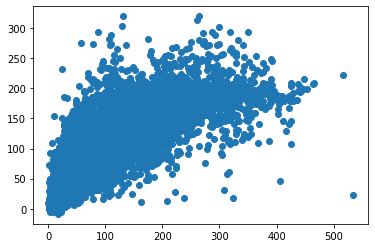

<matplotlib.collections.PathCollection at 0x7efbf8b6b850>

In [0]:
plt.scatter(df['actual'], df['prediction'])


In [0]:
prediction = df['prediction']
actual = df['actual']

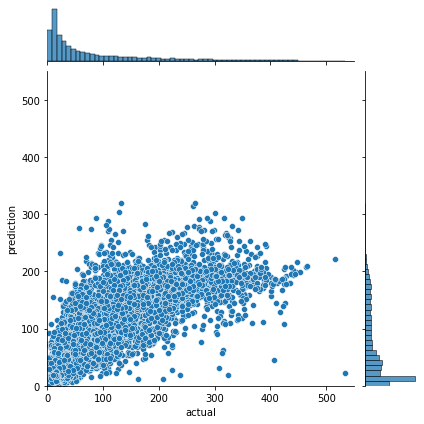

--------------------------------------------------------------------------- 
 AttributeError Traceback (most recent call last)
 <command-3187311660709932> in <module> 
 1 fig = sns . jointplot ( x = actual , y = prediction , xlim = [ 0 , 550 ] , ylim = [ 0 , 550 ] ) 
 ----> 2 fig . set_xlabel ( 'Actual PM2.5' ) 
 3 fig . set_ylabel ( 'Predicted PM2.5' ) 
 4 plt . ax_joint
 5 plt . show ( ) 

 AttributeError : 'JointGrid' object has no attribute 'set_xlabel'

In [0]:
fig = sns.jointplot(x = actual, y = prediction, xlim = [0, 550], ylim = [0, 550])
fig.set_xlabel('Actual PM2.5')
fig.set_ylabel('Predicted PM2.5')
plt.ax_joint
plt.show()

Out[242]:

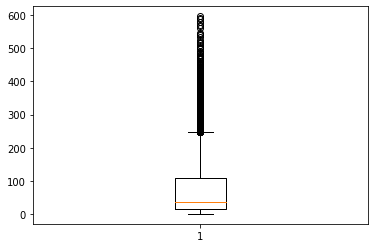

{'whiskers': [<matplotlib.lines.Line2D at 0x7fb41ce950d0>,
 <matplotlib.lines.Line2D at 0x7fb41ce95460>],
 'caps': [<matplotlib.lines.Line2D at 0x7fb41ce957f0>,
 <matplotlib.lines.Line2D at 0x7fb41ce95b80>],
 'boxes': [<matplotlib.lines.Line2D at 0x7fb41ce86d00>],
 'medians': [<matplotlib.lines.Line2D at 0x7fb41ce95f10>],
 'fliers': [<matplotlib.lines.Line2D at 0x7fb41cea02e0>],
 'means': []}

In [0]:
plt.boxplot(df['actual'])

In [0]:
submission_df = df[['latitude', 'longitude', '', 'value']]
submission_df = submission_df.sort_values(by = ['datetime', 'grid_id'])

In [0]:
submission_df

Out[63]:

datetime 
 grid_id 
 value 
 
 
 
 
 0 
 2017-01-07T16:00:00Z 
 1X116 
 15.739528 
 
 
 2007 
 2017-01-07T16:00:00Z 
 9Q6TA 
 15.739528 
 
 
 7318 
 2017-01-07T16:00:00Z 
 KW43U 
 15.734378 
 
 
 10133 
 2017-01-07T16:00:00Z 
 VR4WG 
 15.739528 
 
 
 11595 
 2017-01-07T16:00:00Z 
 XJF9O 
 15.739528 
 
 
 ... 
 ... 
 ... 
 ... 
 
 
 9613 
 2021-08-24T08:00:00Z 
 QJHW4 
 13.185921 
 
 
 10132 
 2021-08-24T08:00:00Z 
 VBLD0 
 16.705843 
 
 
 11287 
 2021-08-24T08:00:00Z 
 WT52R 
 8.207011 
 
 
 12966 
 2021-08-24T08:00:00Z 
 ZP1FZ 
 14.471803 
 
 
 13503 
 2021-08-24T08:00:00Z 
 ZZ8JF 
 15.292356 
 
 
 
 13504 rows × 3 columns

In [0]:
submission_df_sp = spark.createDataFrame(submission_df)

In [0]:
display(submission_df_sp)

datetime grid_id value 2017-01-07T16:00:00Z 1X116 15.739528 2017-01-07T16:00:00Z 9Q6TA 15.739528 2017-01-07T16:00:00Z KW43U 15.734378 2017-01-07T16:00:00Z VR4WG 15.739528 2017-01-07T16:00:00Z XJF9O 15.739528 2017-01-08T08:00:00Z 3S31A 17.158041 2017-01-08T08:00:00Z A2FBI 10.432888 2017-01-08T08:00:00Z DJN0F 10.673202 2017-01-08T08:00:00Z E5P9N 10.323779 2017-01-08T08:00:00Z FRITQ 33.28955 2017-01-08T08:00:00Z H96P6 10.031703 2017-01-08T08:00:00Z PG3MI 10.787577 2017-01-08T08:00:00Z QJHW4 10.41301 2017-01-08T08:00:00Z WT52R 9.91628 2017-01-08T08:00:00Z X5DKW 10.134565 2017-01-08T08:00:00Z ZP1FZ 11.059643 2017-01-08T08:00:00Z ZZ8JF 11.104716 2017-01-08T16:00:00Z 1X116 16.898829 2017-01-08T16:00:00Z 9Q6TA 16.898829 2017-01-08T16:00:00Z KW43U 16.816854 2017-01-08T16:00:00Z VR4WG 16.898829 2017-01-08T16:00:00Z XJF9O 16.898829 2017-01-09T08:00:00Z 3S31A 22.035374 2017-01-09T08:00:00Z A2FBI 10.330819 2017-01-09T08:00:00Z DJN0F 9.78291 2017-01-09T08:00:00Z E5P9N 9.804489 2017-01-09T08:00:00Z FRITQ 30.316973 2017-01-09T08:00:00Z H96P6 7.9247375 2017-01-09T08:00:00Z PG3MI 8.192876 2017-01-09T08:00:00Z QJHW4 7.819911 2017-01-09T08:00:00Z WT52R 7.833931 2017-01-09T08:00:00Z X5DKW 9.606367 2017-01-09T08:00:00Z ZP1FZ 10.126272 2017-01-09T08:00:00Z ZZ8JF 14.569944 2017-01-09T16:00:00Z 1X116 16.819336 2017-01-09T16:00:00Z 9Q6TA 16.819336 2017-01-09T16:00:00Z KW43U 16.814629 2017-01-09T16:00:00Z VR4WG 16.819336 2017-01-09T16:00:00Z XJF9O 16.819336 2017-01-10T08:00:00Z 3S31A 17.717194 2017-01-10T08:00:00Z A2FBI 12.660088 2017-01-10T08:00:00Z DJN0F 11.057751 2017-01-10T08:00:00Z E5P9N 11.951618 2017-01-10T08:00:00Z FRITQ 32.2156 2017-01-10T08:00:00Z H96P6 9.237262 2017-01-10T08:00:00Z PG3MI 12.44649 2017-01-10T08:00:00Z QJHW4 8.312582 2017-01-10T08:00:00Z WT52R 7.386692 2017-01-10T08:00:00Z X5DKW 11.58081 2017-01-10T08:00:00Z ZP1FZ 11.790546 2017-01-10T08:00:00Z ZZ8JF 10.002527 2017-01-10T16:00:00Z 1X116 16.582087 2017-01-10T16:00:00Z 9Q6TA 16.582087 2017-01-10T16:00:00Z KW43U 16.451115 2017-01-10T16:00:00Z VR4WG 16.582087 2017-01-10T16:00:00Z XJF9O 16.582087 2017-01-11T16:00:00Z 1X116 20.922039 2017-01-11T16:00:00Z 9Q6TA 20.922039 2017-01-11T16:00:00Z KW43U 20.932873 2017-01-11T16:00:00Z VR4WG 20.922039 2017-01-11T16:00:00Z XJF9O 20.922039 2017-01-12T08:00:00Z 3S31A 12.311306 2017-01-12T08:00:00Z A2FBI 13.191194 2017-01-12T08:00:00Z E5P9N 13.337594 2017-01-12T08:00:00Z FRITQ 25.503277 2017-01-12T08:00:00Z H96P6 7.6848717 2017-01-12T08:00:00Z PG3MI 7.2749796 2017-01-12T08:00:00Z QJHW4 7.331043 2017-01-12T08:00:00Z WT52R 7.0268574 2017-01-12T08:00:00Z X5DKW 13.263033 2017-01-12T08:00:00Z ZP1FZ 12.883132 2017-01-12T08:00:00Z ZZ8JF 13.406719 2017-01-12T16:00:00Z 1X116 19.344059 2017-01-12T16:00:00Z 9Q6TA 19.344059 2017-01-12T16:00:00Z KW43U 19.17619 2017-01-12T16:00:00Z VR4WG 19.344059 2017-01-12T16:00:00Z XJF9O 19.344059 2017-01-13T08:00:00Z 3S31A 9.0499325 2017-01-13T08:00:00Z A2FBI 11.204483 2017-01-13T08:00:00Z DJN0F 11.697805 2017-01-13T08:00:00Z E5P9N 8.944758 2017-01-13T08:00:00Z FRITQ 26.734179 2017-01-13T08:00:00Z H96P6 8.061701 2017-01-13T08:00:00Z PG3MI 8.803898 2017-01-13T08:00:00Z WT52R 7.2178583 2017-01-13T08:00:00Z X5DKW 9.077866 2017-01-13T08:00:00Z ZP1FZ 9.752256 2017-01-13T08:00:00Z ZZ8JF 10.948872 2017-01-13T16:00:00Z 1X116 15.543512 2017-01-13T16:00:00Z 9Q6TA 15.543512 2017-01-13T16:00:00Z KW43U 15.58008 2017-01-13T16:00:00Z VR4WG 15.543512 2017-01-13T16:00:00Z XJF9O 15.543512 2017-01-14T08:00:00Z 3S31A 6.511307 2017-01-14T08:00:00Z A2FBI 8.800697 2017-01-14T08:00:00Z DJN0F 8.142208 2017-01-14T08:00:00Z E5P9N 8.645229 2017-01-14T08:00:00Z FRITQ 14.564608 2017-01-14T08:00:00Z H96P6 6.917345 2017-01-14T08:00:00Z PG3MI 7.0014925 2017-01-14T08:00:00Z QJHW4 7.323536 2017-01-14T08:00:00Z WT52R 8.000711 2017-01-14T08:00:00Z X5DKW 8.24253 2017-01-14T08:00:00Z ZP1FZ 7.6713624 2017-01-14T08:00:00Z ZZ8JF 7.659655 2017-01-14T16:00:00Z 1X116 15.685506 2017-01-14T16:00:00Z 9Q6TA 15.685506 2017-01-14T16:00:00Z KW43U 15.7168255 2017-01-14T16:00

In [0]:
submission_df_sp.coalesce(1).write.option("header",True).mode("overwrite").csv("/mnt/capstone/test/submission_03_21_featsel_tn_agg_allaod_randomday.csv") 